In [1]:
!pip install torch torchaudio librosa soundfile tqdm matplotlib datasets huggingface_hub


In [2]:
from huggingface_hub import login

# 🔑 Paste your Hugging Face token here (you can get it from https://huggingface.co/settings/tokens)
login()


In [4]:
from getpass import getpass

HF_TOKEN = getpass("Enter your Hugging Face token: ")
login(token=HF_TOKEN)
print("✓ Successfully logged in to Hugging Face Hub!")

Enter your Hugging Face token: ··········
✓ Successfully logged in to Hugging Face Hub!


In [3]:
from datasets import load_dataset

DATASET_NAME = "cdli/kenyan_swahili_nonstandard_speech_v0.9"

dataset = load_dataset(DATASET_NAME, split="train")  # or "test" / "validation" if you prefer
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['audio', 'audio_id', 'speaker_id', 'language', 'prompt_type', 'prompt_id', 'recording_date', 'recording_time', 'recording_environment', 'recording_device', 'transcription', 'audio_length', 'transcript_length'],
    num_rows: 3949
})


In [4]:
import random, torch, torchaudio, librosa, numpy as np

class DataAugmentation:
    def __init__(self, sampling_rate=16000, verbose=False):
        self.sampling_rate = sampling_rate
        self.verbose = verbose

        # Load room impulse response for reverb
        rir_sample = torchaudio.utils.download_asset(
            "tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav"
        )
        rir_raw, sr = torchaudio.load(rir_sample)
        rir = rir_raw[:, int(sr * 1.01) : int(sr * 1.3)]
        self.rir = rir / torch.linalg.vector_norm(rir, ord=2)

    def pitch_shift(self, audio):
        n_steps = random.choice([-3, -2, -1, 1, 2, 3])
        if self.verbose: print(f"Pitch shift: {n_steps}")
        return librosa.effects.pitch_shift(audio, sr=self.sampling_rate, n_steps=n_steps)

    def time_stretch(self, audio):
        rate = random.choice([0.8, 0.9, 1.1, 1.2])
        if self.verbose: print(f"Time stretch: {rate}")
        return librosa.effects.time_stretch(audio, rate=rate)

    def add_noise(self, audio):
        noise = np.random.normal(0, 0.005, audio.shape)
        return audio + noise

    def add_reverb(self, audio):
        audio_t = torch.tensor(audio, dtype=torch.float32).unsqueeze(0)
        return torchaudio.functional.fftconvolve(audio_t, self.rir)[0].numpy()

    def augment(self, audio):
        if random.random() < 0.5: audio = self.pitch_shift(audio)
        if random.random() < 0.5: audio = self.time_stretch(audio)
        if random.random() < 0.3: audio = self.add_noise(audio)
        if random.random() < 0.4: audio = self.add_reverb(audio)
        return audio


In [5]:
import os, soundfile as sf
from tqdm import tqdm

AUGMENTER = DataAugmentation(verbose=True)
OUTPUT_DIR = "augmented_swahili"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for i in tqdm(range(len(dataset)), desc="Augmenting"):
    try:
        sample = dataset[i]
        audio = np.array(sample["audio"]["array"], dtype=np.float32)
        sr = sample["audio"]["sampling_rate"]

        if sr != AUGMENTER.sampling_rate:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=AUGMENTER.sampling_rate)

        augmented_audio = AUGMENTER.augment(audio)
        output_path = os.path.join(OUTPUT_DIR, f"swahili_sample_{i:05d}_aug.wav")
        sf.write(output_path, augmented_audio, AUGMENTER.sampling_rate)
    except Exception as e:
        print(f"Error on sample {i}: {e}")


/tmp/ipython-input-1235940444.py:9: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  rir_sample = torchaudio.utils.download_asset(
100%|██████████| 31.3k/31.3k [00:00<00:00, 12.8MB/s]
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packag

Pitch shift: -3


Augmenting:   0%|          | 1/3949 [00:20<22:13:01, 20.26s/it]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   0%|          | 2/3949 [00:20<9:28:09,  8.64s/it] 

Pitch shift: 3


Augmenting:   0%|          | 3/3949 [00:21<5:24:02,  4.93s/it]

Pitch shift: -3


Augmenting:   0%|          | 4/3949 [00:21<3:30:48,  3.21s/it]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   0%|          | 6/3949 [00:22<1:50:09,  1.68s/it]

Pitch shift: 3


Augmenting:   0%|          | 10/3949 [00:23<50:36,  1.30it/s]

Pitch shift: -1


Augmenting:   0%|          | 11/3949 [00:23<48:32,  1.35it/s]

Time stretch: 0.9


Augmenting:   0%|          | 12/3949 [00:24<49:05,  1.34it/s]

Time stretch: 1.2


Augmenting:   0%|          | 13/3949 [00:25<43:23,  1.51it/s]

Pitch shift: -3


Augmenting:   0%|          | 15/3949 [00:26<40:43,  1.61it/s]

Pitch shift: -1


Augmenting:   0%|          | 17/3949 [00:26<29:49,  2.20it/s]

Pitch shift: -1


Augmenting:   0%|          | 19/3949 [00:27<28:06,  2.33it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   1%|          | 20/3949 [00:27<27:00,  2.43it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   1%|          | 21/3949 [00:28<27:44,  2.36it/s]

Time stretch: 1.1


Augmenting:   1%|          | 22/3949 [00:28<26:18,  2.49it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:   1%|          | 24/3949 [00:29<22:55,  2.85it/s]

Time stretch: 0.8


Augmenting:   1%|          | 26/3949 [00:30<37:09,  1.76it/s]

Pitch shift: 3


Augmenting:   1%|          | 27/3949 [00:31<42:44,  1.53it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:   1%|          | 28/3949 [00:33<1:06:20,  1.02s/it]

Time stretch: 1.2


Augmenting:   1%|          | 29/3949 [00:34<1:00:58,  1.07it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   1%|          | 30/3949 [00:34<51:42,  1.26it/s]  

Pitch shift: 3
Time stretch: 0.8


Augmenting:   1%|          | 32/3949 [00:35<36:55,  1.77it/s]

Pitch shift: 1


Augmenting:   1%|          | 35/3949 [00:35<19:32,  3.34it/s]

Pitch shift: 1
Pitch shift: -2
Time stretch: 0.8


Augmenting:   1%|          | 36/3949 [00:36<20:34,  3.17it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   1%|          | 38/3949 [00:37<20:42,  3.15it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   1%|          | 39/3949 [00:37<23:16,  2.80it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   1%|          | 41/3949 [00:37<19:04,  3.41it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   1%|          | 42/3949 [00:38<20:12,  3.22it/s]

Pitch shift: 2


Augmenting:   1%|          | 44/3949 [00:38<18:41,  3.48it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   1%|          | 46/3949 [00:39<21:34,  3.02it/s]

Pitch shift: -2


Augmenting:   1%|          | 47/3949 [00:40<23:33,  2.76it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   1%|          | 48/3949 [00:40<30:00,  2.17it/s]

Time stretch: 1.2


Augmenting:   1%|          | 49/3949 [00:41<25:31,  2.55it/s]

Pitch shift: 3


Augmenting:   1%|▏         | 50/3949 [00:41<29:26,  2.21it/s]

Pitch shift: -3


Augmenting:   1%|▏         | 51/3949 [00:41<25:08,  2.58it/s]

Time stretch: 1.1


Augmenting:   1%|▏         | 52/3949 [00:42<22:15,  2.92it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   1%|▏         | 53/3949 [00:43<32:37,  1.99it/s]

Time stretch: 0.8


Augmenting:   1%|▏         | 54/3949 [00:43<38:52,  1.67it/s]

Time stretch: 1.1


Augmenting:   1%|▏         | 57/3949 [00:44<23:21,  2.78it/s]

Pitch shift: 1


Augmenting:   1%|▏         | 58/3949 [00:44<21:24,  3.03it/s]

Time stretch: 0.8


Augmenting:   2%|▏         | 62/3949 [00:45<13:09,  4.93it/s]

Pitch shift: -3
Pitch shift: -3
Time stretch: 0.8


Augmenting:   2%|▏         | 64/3949 [00:45<14:51,  4.36it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   2%|▏         | 65/3949 [00:46<18:59,  3.41it/s]

Pitch shift: -1


Augmenting:   2%|▏         | 66/3949 [00:46<19:56,  3.25it/s]

Pitch shift: -2


Augmenting:   2%|▏         | 67/3949 [00:46<19:30,  3.32it/s]

Time stretch: 0.9


Augmenting:   2%|▏         | 69/3949 [00:47<20:10,  3.21it/s]

Time stretch: 0.9


Augmenting:   2%|▏         | 70/3949 [00:47<18:37,  3.47it/s]

Time stretch: 0.8


Augmenting:   2%|▏         | 71/3949 [00:48<30:31,  2.12it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 72/3949 [00:49<30:48,  2.10it/s]

Pitch shift: 1


Augmenting:   2%|▏         | 73/3949 [00:49<30:05,  2.15it/s]

Time stretch: 1.1


Augmenting:   2%|▏         | 75/3949 [00:50<26:26,  2.44it/s]

Pitch shift: -1


Augmenting:   2%|▏         | 81/3949 [00:51<15:31,  4.15it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   2%|▏         | 83/3949 [00:52<14:14,  4.52it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:   2%|▏         | 84/3949 [00:52<14:24,  4.47it/s]

Time stretch: 1.2


Augmenting:   2%|▏         | 85/3949 [00:52<14:41,  4.38it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   2%|▏         | 86/3949 [00:53<25:24,  2.53it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:   2%|▏         | 87/3949 [00:54<28:53,  2.23it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   2%|▏         | 89/3949 [00:54<24:45,  2.60it/s]

Pitch shift: 1


Augmenting:   2%|▏         | 91/3949 [00:55<17:35,  3.66it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   2%|▏         | 94/3949 [00:55<14:02,  4.58it/s]

Pitch shift: 2
Pitch shift: 1
Time stretch: 1.2


Augmenting:   2%|▏         | 95/3949 [00:56<19:25,  3.31it/s]

Pitch shift: 3


Augmenting:   2%|▏         | 96/3949 [00:56<19:17,  3.33it/s]

Time stretch: 0.8


Augmenting:   2%|▏         | 98/3949 [00:57<22:08,  2.90it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:   3%|▎         | 101/3949 [00:57<17:06,  3.75it/s]

Pitch shift: 2


Augmenting:   3%|▎         | 104/3949 [00:58<13:22,  4.79it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:   3%|▎         | 106/3949 [00:58<12:56,  4.95it/s]

Pitch shift: 3


Augmenting:   3%|▎         | 108/3949 [00:59<14:22,  4.45it/s]

Pitch shift: -3
Pitch shift: -1
Time stretch: 0.9


Augmenting:   3%|▎         | 109/3949 [00:59<18:57,  3.37it/s]

Pitch shift: 3


Augmenting:   3%|▎         | 110/3949 [01:00<18:59,  3.37it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:   3%|▎         | 111/3949 [01:00<22:39,  2.82it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 112/3949 [01:01<21:42,  2.95it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 113/3949 [01:01<20:41,  3.09it/s]

Pitch shift: 3


Augmenting:   3%|▎         | 114/3949 [01:01<20:33,  3.11it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   3%|▎         | 115/3949 [01:02<31:09,  2.05it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   3%|▎         | 116/3949 [01:03<33:18,  1.92it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 117/3949 [01:03<39:29,  1.62it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   3%|▎         | 118/3949 [01:04<41:39,  1.53it/s]

Pitch shift: -1


Augmenting:   3%|▎         | 120/3949 [01:04<26:33,  2.40it/s]

Time stretch: 1.1


Augmenting:   3%|▎         | 122/3949 [01:05<21:05,  3.02it/s]

Pitch shift: 1


Augmenting:   3%|▎         | 123/3949 [01:06<25:44,  2.48it/s]

Time stretch: 1.1


Augmenting:   3%|▎         | 124/3949 [01:06<24:00,  2.66it/s]

Pitch shift: 3


Augmenting:   3%|▎         | 125/3949 [01:06<21:43,  2.93it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   3%|▎         | 126/3949 [01:07<29:14,  2.18it/s]

Pitch shift: 2


Augmenting:   3%|▎         | 127/3949 [01:07<25:35,  2.49it/s]

Time stretch: 0.8


Augmenting:   3%|▎         | 128/3949 [01:08<29:59,  2.12it/s]

Pitch shift: -2


Augmenting:   3%|▎         | 130/3949 [01:08<20:18,  3.13it/s]

Pitch shift: -1


Augmenting:   3%|▎         | 132/3949 [01:08<17:48,  3.57it/s]

Pitch shift: -2
Pitch shift: 2
Time stretch: 0.8


Augmenting:   3%|▎         | 133/3949 [01:09<23:50,  2.67it/s]

Pitch shift: -1


Augmenting:   3%|▎         | 134/3949 [01:10<24:48,  2.56it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:   3%|▎         | 136/3949 [01:10<20:44,  3.06it/s]

Time stretch: 0.8
Pitch shift: -1


Augmenting:   3%|▎         | 137/3949 [01:10<19:42,  3.22it/s]

Time stretch: 0.8
Pitch shift: 3


Augmenting:   3%|▎         | 138/3949 [01:11<18:30,  3.43it/s]

Pitch shift: 3


Augmenting:   4%|▎         | 139/3949 [01:11<17:48,  3.56it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:   4%|▎         | 142/3949 [01:11<13:36,  4.66it/s]

Pitch shift: 2
Pitch shift: 1


Augmenting:   4%|▎         | 143/3949 [01:12<13:57,  4.54it/s]

Time stretch: 0.9
Pitch shift: -2


Augmenting:   4%|▎         | 144/3949 [01:12<16:25,  3.86it/s]

Time stretch: 0.9


Augmenting:   4%|▎         | 145/3949 [01:12<14:35,  4.34it/s]

Pitch shift: -3


Augmenting:   4%|▎         | 146/3949 [01:13<15:39,  4.05it/s]

Time stretch: 0.9


Augmenting:   4%|▎         | 147/3949 [01:13<16:52,  3.76it/s]

Pitch shift: 3


Augmenting:   4%|▎         | 148/3949 [01:13<16:08,  3.92it/s]

Time stretch: 1.1


Augmenting:   4%|▍         | 150/3949 [01:14<15:52,  3.99it/s]

Time stretch: 1.1
Pitch shift: 2
Time stretch: 0.9


Augmenting:   4%|▍         | 151/3949 [01:14<21:25,  2.95it/s]

Time stretch: 1.2


Augmenting:   4%|▍         | 152/3949 [01:14<19:51,  3.19it/s]

Time stretch: 1.1


Augmenting:   4%|▍         | 155/3949 [01:15<16:17,  3.88it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.8


Augmenting:   4%|▍         | 156/3949 [01:15<19:49,  3.19it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   4%|▍         | 157/3949 [01:16<23:10,  2.73it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   4%|▍         | 158/3949 [01:17<26:50,  2.35it/s]

Time stretch: 1.1


Augmenting:   4%|▍         | 159/3949 [01:17<24:43,  2.55it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   4%|▍         | 160/3949 [01:17<24:25,  2.59it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   4%|▍         | 166/3949 [01:18<12:30,  5.04it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.9


Augmenting:   4%|▍         | 168/3949 [01:19<13:46,  4.58it/s]

Pitch shift: 2


Augmenting:   4%|▍         | 169/3949 [01:19<15:48,  3.99it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   4%|▍         | 170/3949 [01:20<19:08,  3.29it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   4%|▍         | 172/3949 [01:20<19:04,  3.30it/s]

Time stretch: 0.8


Augmenting:   4%|▍         | 173/3949 [01:20<16:55,  3.72it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:   4%|▍         | 175/3949 [01:21<15:35,  4.04it/s]

Time stretch: 1.1


Augmenting:   5%|▍         | 178/3949 [01:21<10:45,  5.84it/s]

Time stretch: 1.2


Augmenting:   5%|▍         | 180/3949 [01:22<10:50,  5.80it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:   5%|▍         | 181/3949 [01:22<13:45,  4.57it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:   5%|▍         | 182/3949 [01:22<14:57,  4.20it/s]

Pitch shift: 3


Augmenting:   5%|▍         | 186/3949 [01:23<10:44,  5.84it/s]

Pitch shift: -3


Augmenting:   5%|▍         | 188/3949 [01:23<11:01,  5.68it/s]

Time stretch: 0.8
Time stretch: 1.1


Augmenting:   5%|▍         | 190/3949 [01:23<10:05,  6.21it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:   5%|▍         | 192/3949 [01:24<11:38,  5.38it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   5%|▍         | 193/3949 [01:24<14:21,  4.36it/s]

Pitch shift: 3


Augmenting:   5%|▍         | 195/3949 [01:25<16:13,  3.85it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   5%|▍         | 196/3949 [01:25<18:04,  3.46it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:   5%|▌         | 198/3949 [01:26<17:56,  3.49it/s]

Pitch shift: 2
Pitch shift: -2


Augmenting:   5%|▌         | 199/3949 [01:26<16:13,  3.85it/s]

Time stretch: 1.2


Augmenting:   5%|▌         | 200/3949 [01:26<17:24,  3.59it/s]

Time stretch: 0.9


Augmenting:   5%|▌         | 201/3949 [01:27<18:41,  3.34it/s]

Pitch shift: 2


Augmenting:   5%|▌         | 202/3949 [01:27<20:10,  3.10it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:   5%|▌         | 203/3949 [01:28<27:04,  2.31it/s]

Time stretch: 0.8


Augmenting:   5%|▌         | 208/3949 [01:29<14:23,  4.33it/s]

Time stretch: 1.2


Augmenting:   5%|▌         | 209/3949 [01:29<15:53,  3.92it/s]

Pitch shift: 3


Augmenting:   5%|▌         | 211/3949 [01:30<15:41,  3.97it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   5%|▌         | 212/3949 [01:30<13:56,  4.47it/s]

Time stretch: 0.9


Augmenting:   5%|▌         | 213/3949 [01:30<15:45,  3.95it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   5%|▌         | 215/3949 [01:31<16:28,  3.78it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:   5%|▌         | 216/3949 [01:31<17:45,  3.50it/s]

Time stretch: 1.2


Augmenting:   5%|▌         | 217/3949 [01:31<17:27,  3.56it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   6%|▌         | 218/3949 [01:32<17:04,  3.64it/s]

Pitch shift: 1


Augmenting:   6%|▌         | 219/3949 [01:32<18:27,  3.37it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   6%|▌         | 221/3949 [01:32<15:05,  4.12it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:   6%|▌         | 223/3949 [01:33<13:08,  4.72it/s]

Time stretch: 0.8


Augmenting:   6%|▌         | 224/3949 [01:33<12:12,  5.08it/s]

Pitch shift: 1
Pitch shift: 1


Augmenting:   6%|▌         | 225/3949 [01:33<14:42,  4.22it/s]

Time stretch: 0.9


Augmenting:   6%|▌         | 227/3949 [01:34<16:10,  3.83it/s]

Pitch shift: 2
Pitch shift: -2


Augmenting:   6%|▌         | 229/3949 [01:34<16:22,  3.79it/s]

Pitch shift: 3


Augmenting:   6%|▌         | 230/3949 [01:34<14:49,  4.18it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:   6%|▌         | 232/3949 [01:35<13:49,  4.48it/s]

Pitch shift: 3


Augmenting:   6%|▌         | 233/3949 [01:35<16:56,  3.66it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   6%|▌         | 234/3949 [01:36<15:32,  3.99it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:   6%|▌         | 235/3949 [01:36<15:49,  3.91it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   6%|▌         | 236/3949 [01:36<15:29,  3.99it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   6%|▌         | 238/3949 [01:36<14:14,  4.34it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   6%|▌         | 240/3949 [01:37<11:56,  5.18it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:   6%|▌         | 242/3949 [01:37<11:56,  5.18it/s]

Time stretch: 1.2


Augmenting:   6%|▌         | 244/3949 [01:37<10:50,  5.69it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:   6%|▌         | 245/3949 [01:38<12:23,  4.99it/s]

Time stretch: 0.8


Augmenting:   6%|▋         | 248/3949 [01:38<11:54,  5.18it/s]

Pitch shift: -2
Time stretch: 1.2
Time stretch: 0.9


Augmenting:   6%|▋         | 251/3949 [01:39<09:22,  6.57it/s]

Pitch shift: -2
Pitch shift: 1


Augmenting:   6%|▋         | 255/3949 [01:39<07:34,  8.13it/s]

Pitch shift: 3
Time stretch: 1.2
Time stretch: 1.1


Augmenting:   7%|▋         | 257/3949 [01:40<12:13,  5.03it/s]

Pitch shift: 3
Pitch shift: -2
Time stretch: 1.1


Augmenting:   7%|▋         | 258/3949 [01:40<14:09,  4.34it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   7%|▋         | 260/3949 [01:41<17:26,  3.52it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   7%|▋         | 261/3949 [01:41<17:41,  3.47it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   7%|▋         | 262/3949 [01:42<19:21,  3.17it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:   7%|▋         | 265/3949 [01:42<15:14,  4.03it/s]

Pitch shift: 3


Augmenting:   7%|▋         | 266/3949 [01:42<13:18,  4.61it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:   7%|▋         | 267/3949 [01:42<11:46,  5.21it/s]

Time stretch: 0.9


Augmenting:   7%|▋         | 268/3949 [01:43<12:35,  4.87it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   7%|▋         | 269/3949 [01:43<14:38,  4.19it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   7%|▋         | 270/3949 [01:43<18:40,  3.28it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   7%|▋         | 272/3949 [01:44<15:40,  3.91it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:   7%|▋         | 274/3949 [01:44<13:31,  4.53it/s]

Pitch shift: -3
Pitch shift: 3
Time stretch: 0.9


Augmenting:   7%|▋         | 275/3949 [01:45<16:19,  3.75it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   7%|▋         | 277/3949 [01:45<15:10,  4.03it/s]

Time stretch: 1.1


Augmenting:   7%|▋         | 278/3949 [01:45<13:48,  4.43it/s]

Time stretch: 0.8
Pitch shift: 3


Augmenting:   7%|▋         | 279/3949 [01:46<14:33,  4.20it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:   7%|▋         | 280/3949 [01:46<16:28,  3.71it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:   7%|▋         | 281/3949 [01:46<16:41,  3.66it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:   7%|▋         | 282/3949 [01:46<14:17,  4.28it/s]

Time stretch: 0.8


Augmenting:   7%|▋         | 285/3949 [01:47<11:15,  5.42it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:   7%|▋         | 286/3949 [01:47<11:56,  5.11it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:   7%|▋         | 289/3949 [01:47<09:18,  6.55it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:   7%|▋         | 290/3949 [01:48<09:47,  6.23it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:   7%|▋         | 291/3949 [01:48<11:34,  5.27it/s]

Pitch shift: -1


Augmenting:   7%|▋         | 292/3949 [01:48<12:10,  5.01it/s]

Time stretch: 0.9


Augmenting:   7%|▋         | 294/3949 [01:48<11:23,  5.35it/s]

Time stretch: 1.1


Augmenting:   7%|▋         | 296/3949 [01:49<10:15,  5.93it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:   8%|▊         | 298/3949 [01:49<09:01,  6.74it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:   8%|▊         | 299/3949 [01:49<10:29,  5.80it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:   8%|▊         | 301/3949 [01:50<10:16,  5.91it/s]

Pitch shift: 1
Pitch shift: -1


Augmenting:   8%|▊         | 303/3949 [01:50<09:41,  6.27it/s]

Time stretch: 0.8
Pitch shift: -1


Augmenting:   8%|▊         | 305/3949 [01:50<10:25,  5.83it/s]

Pitch shift: -1
Pitch shift: 1


Augmenting:   8%|▊         | 307/3949 [01:51<10:58,  5.53it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 309/3949 [01:51<08:04,  7.51it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:   8%|▊         | 312/3949 [01:51<10:01,  6.05it/s]

Pitch shift: -1
Time stretch: 1.2
Pitch shift: 3


Augmenting:   8%|▊         | 313/3949 [01:52<10:33,  5.74it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:   8%|▊         | 315/3949 [01:52<12:48,  4.73it/s]

Pitch shift: -1


Augmenting:   8%|▊         | 316/3949 [01:52<12:22,  4.90it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:   8%|▊         | 318/3949 [01:53<18:02,  3.35it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   8%|▊         | 320/3949 [01:54<19:10,  3.16it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 322/3949 [01:54<17:26,  3.47it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:   8%|▊         | 323/3949 [01:55<22:41,  2.66it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   8%|▊         | 325/3949 [01:55<19:41,  3.07it/s]

Pitch shift: 2


Augmenting:   8%|▊         | 326/3949 [01:56<20:32,  2.94it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   8%|▊         | 328/3949 [01:56<19:48,  3.05it/s]

Time stretch: 0.9


Augmenting:   8%|▊         | 330/3949 [01:57<16:46,  3.60it/s]

Time stretch: 1.2


Augmenting:   8%|▊         | 331/3949 [01:57<17:33,  3.44it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   8%|▊         | 333/3949 [01:58<17:23,  3.46it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   8%|▊         | 335/3949 [01:58<13:25,  4.49it/s]

Pitch shift: -1
Pitch shift: -1


Augmenting:   9%|▊         | 337/3949 [01:59<11:11,  5.38it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:   9%|▊         | 339/3949 [01:59<10:53,  5.52it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:   9%|▊         | 341/3949 [01:59<10:48,  5.57it/s]

Time stretch: 0.8
Pitch shift: 2


Augmenting:   9%|▊         | 342/3949 [02:00<12:58,  4.63it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:   9%|▊         | 344/3949 [02:00<11:08,  5.39it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:   9%|▊         | 345/3949 [02:00<12:09,  4.94it/s]

Time stretch: 0.8
Time stretch: 0.8


Augmenting:   9%|▉         | 347/3949 [02:01<13:04,  4.59it/s]

Pitch shift: 1
Time stretch: 1.2
Pitch shift: 3
Time stretch: 1.2


Augmenting:   9%|▉         | 349/3949 [02:01<12:54,  4.65it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:   9%|▉         | 350/3949 [02:01<14:08,  4.24it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:   9%|▉         | 351/3949 [02:02<15:12,  3.94it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:   9%|▉         | 353/3949 [02:02<14:12,  4.22it/s]

Pitch shift: 3
Pitch shift: -1


Augmenting:   9%|▉         | 355/3949 [02:03<14:17,  4.19it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:   9%|▉         | 356/3949 [02:03<13:18,  4.50it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:   9%|▉         | 358/3949 [02:03<14:20,  4.18it/s]

Pitch shift: -1


Augmenting:   9%|▉         | 361/3949 [02:04<12:17,  4.87it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:   9%|▉         | 362/3949 [02:04<13:56,  4.29it/s]

Time stretch: 0.9
Pitch shift: 1


Augmenting:   9%|▉         | 364/3949 [02:05<13:12,  4.52it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:   9%|▉         | 365/3949 [02:05<17:33,  3.40it/s]

Pitch shift: 1


Augmenting:   9%|▉         | 366/3949 [02:06<21:45,  2.74it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:   9%|▉         | 368/3949 [02:06<19:55,  3.00it/s]

Pitch shift: -3


Augmenting:   9%|▉         | 369/3949 [02:07<17:04,  3.50it/s]

Pitch shift: -1


Augmenting:   9%|▉         | 370/3949 [02:07<22:44,  2.62it/s]

Pitch shift: 2


Augmenting:   9%|▉         | 371/3949 [02:07<20:16,  2.94it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:   9%|▉         | 372/3949 [02:08<24:55,  2.39it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:   9%|▉         | 373/3949 [02:08<22:45,  2.62it/s]

Time stretch: 1.2


Augmenting:   9%|▉         | 374/3949 [02:08<20:12,  2.95it/s]

Time stretch: 0.9


Augmenting:  10%|▉         | 376/3949 [02:09<15:41,  3.80it/s]

Pitch shift: 3


Augmenting:  10%|▉         | 378/3949 [02:09<14:00,  4.25it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  10%|▉         | 379/3949 [02:10<14:41,  4.05it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  10%|▉         | 380/3949 [02:10<21:12,  2.81it/s]

Time stretch: 0.8


Augmenting:  10%|▉         | 381/3949 [02:10<20:28,  2.90it/s]

Time stretch: 1.2


Augmenting:  10%|▉         | 382/3949 [02:11<19:05,  3.11it/s]

Time stretch: 1.1


Augmenting:  10%|▉         | 384/3949 [02:11<15:01,  3.95it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  10%|▉         | 386/3949 [02:12<17:13,  3.45it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  10%|▉         | 390/3949 [02:12<11:11,  5.30it/s]

Pitch shift: 3
Pitch shift: 2


Augmenting:  10%|▉         | 393/3949 [02:13<11:23,  5.20it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.8


Augmenting:  10%|█         | 395/3949 [02:14<13:54,  4.26it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  10%|█         | 396/3949 [02:14<18:02,  3.28it/s]

Pitch shift: -2


Augmenting:  10%|█         | 400/3949 [02:15<12:51,  4.60it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  10%|█         | 401/3949 [02:15<15:14,  3.88it/s]

Time stretch: 0.8


Augmenting:  10%|█         | 403/3949 [02:16<14:13,  4.16it/s]

Pitch shift: 2
Pitch shift: -3
Time stretch: 1.2


Augmenting:  10%|█         | 406/3949 [02:16<12:13,  4.83it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  10%|█         | 407/3949 [02:17<16:43,  3.53it/s]

Pitch shift: 2


Augmenting:  10%|█         | 409/3949 [02:17<12:47,  4.61it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  10%|█         | 410/3949 [02:18<16:53,  3.49it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  10%|█         | 412/3949 [02:18<19:50,  2.97it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  10%|█         | 413/3949 [02:19<24:23,  2.42it/s]

Pitch shift: 2


Augmenting:  10%|█         | 414/3949 [02:19<22:39,  2.60it/s]

Pitch shift: -1


Augmenting:  11%|█         | 416/3949 [02:20<19:35,  3.01it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  11%|█         | 418/3949 [02:21<20:33,  2.86it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  11%|█         | 421/3949 [02:21<14:41,  4.00it/s]

Pitch shift: 2
Pitch shift: 1


Augmenting:  11%|█         | 422/3949 [02:21<14:18,  4.11it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  11%|█         | 424/3949 [02:22<13:22,  4.39it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  11%|█         | 426/3949 [02:22<13:29,  4.35it/s]

Pitch shift: -1
Pitch shift: -3


Augmenting:  11%|█         | 427/3949 [02:23<12:54,  4.54it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  11%|█         | 428/3949 [02:23<16:32,  3.55it/s]

Pitch shift: -3


Augmenting:  11%|█         | 429/3949 [02:23<16:24,  3.57it/s]

Pitch shift: -3


Augmenting:  11%|█         | 432/3949 [02:24<13:25,  4.37it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  11%|█         | 435/3949 [02:24<09:02,  6.47it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  11%|█         | 436/3949 [02:25<12:04,  4.85it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  11%|█         | 439/3949 [02:25<10:45,  5.43it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  11%|█         | 441/3949 [02:26<12:39,  4.62it/s]

Time stretch: 0.8
Time stretch: 0.9


Augmenting:  11%|█         | 443/3949 [02:26<13:25,  4.35it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:  11%|█         | 444/3949 [02:27<16:01,  3.65it/s]

Time stretch: 1.2


Augmenting:  11%|█▏        | 446/3949 [02:27<12:41,  4.60it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  11%|█▏        | 448/3949 [02:27<12:33,  4.64it/s]

Time stretch: 0.8


Augmenting:  11%|█▏        | 449/3949 [02:27<11:06,  5.25it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  11%|█▏        | 451/3949 [02:28<11:24,  5.11it/s]

Time stretch: 0.8


Augmenting:  11%|█▏        | 454/3949 [02:28<08:57,  6.51it/s]

Time stretch: 0.8
Pitch shift: -3


Augmenting:  12%|█▏        | 456/3949 [02:28<09:23,  6.20it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  12%|█▏        | 458/3949 [02:29<09:30,  6.12it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  12%|█▏        | 461/3949 [02:29<08:37,  6.74it/s]

Pitch shift: -3
Pitch shift: -2


Augmenting:  12%|█▏        | 463/3949 [02:30<11:00,  5.28it/s]

Time stretch: 1.2


Augmenting:  12%|█▏        | 464/3949 [02:30<10:30,  5.52it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.9


Augmenting:  12%|█▏        | 466/3949 [02:31<14:11,  4.09it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  12%|█▏        | 467/3949 [02:31<15:20,  3.78it/s]

Pitch shift: 1


Augmenting:  12%|█▏        | 468/3949 [02:31<15:41,  3.70it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  12%|█▏        | 469/3949 [02:32<20:43,  2.80it/s]

Time stretch: 0.8


Augmenting:  12%|█▏        | 470/3949 [02:32<19:29,  2.97it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  12%|█▏        | 472/3949 [02:33<20:10,  2.87it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  12%|█▏        | 473/3949 [02:33<22:52,  2.53it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  12%|█▏        | 475/3949 [02:34<18:50,  3.07it/s]

Time stretch: 1.1


Augmenting:  12%|█▏        | 477/3949 [02:34<16:28,  3.51it/s]

Time stretch: 0.8
Pitch shift: -3
Time stretch: 0.8


Augmenting:  12%|█▏        | 480/3949 [02:35<13:33,  4.26it/s]

Time stretch: 0.9


Augmenting:  12%|█▏        | 482/3949 [02:35<09:22,  6.17it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  12%|█▏        | 483/3949 [02:35<11:03,  5.22it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  12%|█▏        | 484/3949 [02:36<13:41,  4.22it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  12%|█▏        | 486/3949 [02:36<14:02,  4.11it/s]

Time stretch: 0.9
Time stretch: 1.1


Augmenting:  12%|█▏        | 487/3949 [02:36<12:33,  4.59it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  12%|█▏        | 489/3949 [02:37<11:45,  4.90it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:  12%|█▏        | 490/3949 [02:37<10:32,  5.47it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  12%|█▏        | 491/3949 [02:37<11:37,  4.96it/s]

Time stretch: 0.8


Augmenting:  12%|█▏        | 493/3949 [02:38<11:35,  4.97it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  13%|█▎        | 494/3949 [02:38<12:40,  4.55it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  13%|█▎        | 495/3949 [02:38<13:13,  4.35it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  13%|█▎        | 497/3949 [02:39<11:33,  4.98it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  13%|█▎        | 499/3949 [02:39<11:08,  5.16it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  13%|█▎        | 501/3949 [02:39<12:18,  4.67it/s]

Pitch shift: -3
Pitch shift: 2


Augmenting:  13%|█▎        | 502/3949 [02:40<13:18,  4.32it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:  13%|█▎        | 503/3949 [02:40<12:30,  4.59it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  13%|█▎        | 505/3949 [02:40<09:12,  6.24it/s]

Pitch shift: 1


Augmenting:  13%|█▎        | 506/3949 [02:40<11:02,  5.20it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  13%|█▎        | 507/3949 [02:41<11:55,  4.81it/s]

Time stretch: 0.9


Augmenting:  13%|█▎        | 509/3949 [02:41<13:05,  4.38it/s]

Pitch shift: -3
Time stretch: 1.2
Pitch shift: 1


Augmenting:  13%|█▎        | 510/3949 [02:41<13:20,  4.30it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  13%|█▎        | 511/3949 [02:42<13:40,  4.19it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  13%|█▎        | 512/3949 [02:42<15:27,  3.71it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  13%|█▎        | 514/3949 [02:42<12:24,  4.61it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  13%|█▎        | 516/3949 [02:43<13:45,  4.16it/s]

Pitch shift: 3
Time stretch: 0.9
Pitch shift: 2


Augmenting:  13%|█▎        | 517/3949 [02:43<13:11,  4.33it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  13%|█▎        | 521/3949 [02:44<09:05,  6.29it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  13%|█▎        | 523/3949 [02:44<08:48,  6.49it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  13%|█▎        | 524/3949 [02:44<12:11,  4.68it/s]

Pitch shift: -1


Augmenting:  13%|█▎        | 526/3949 [02:45<12:59,  4.39it/s]

Time stretch: 0.8
Time stretch: 0.9


Augmenting:  13%|█▎        | 528/3949 [02:45<12:12,  4.67it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  13%|█▎        | 529/3949 [02:46<13:49,  4.12it/s]

Time stretch: 0.8


Augmenting:  13%|█▎        | 530/3949 [02:46<13:57,  4.08it/s]

Pitch shift: 1


Augmenting:  14%|█▎        | 534/3949 [02:46<09:20,  6.09it/s]

Time stretch: 0.9
Pitch shift: 1


Augmenting:  14%|█▎        | 535/3949 [02:47<10:18,  5.52it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  14%|█▎        | 539/3949 [02:47<06:56,  8.19it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  14%|█▎        | 540/3949 [02:47<09:34,  5.93it/s]

Time stretch: 1.1


Augmenting:  14%|█▎        | 542/3949 [02:48<10:28,  5.42it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  14%|█▍        | 545/3949 [02:48<10:30,  5.40it/s]

Time stretch: 1.1
Pitch shift: -3
Time stretch: 0.8


Augmenting:  14%|█▍        | 547/3949 [02:49<10:26,  5.43it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  14%|█▍        | 549/3949 [02:49<13:28,  4.20it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  14%|█▍        | 550/3949 [02:50<13:00,  4.35it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  14%|█▍        | 552/3949 [02:50<15:12,  3.72it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  14%|█▍        | 554/3949 [02:51<13:10,  4.29it/s]

Pitch shift: -2
Time stretch: 0.9
Pitch shift: -1
Time stretch: 1.2


Augmenting:  14%|█▍        | 555/3949 [02:51<14:00,  4.04it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 1.1


Augmenting:  14%|█▍        | 557/3949 [02:51<12:17,  4.60it/s]

Pitch shift: 3


Augmenting:  14%|█▍        | 559/3949 [02:52<10:33,  5.35it/s]

Time stretch: 0.8


Augmenting:  14%|█▍        | 561/3949 [02:52<12:25,  4.54it/s]

Pitch shift: -2
Time stretch: 0.8
Pitch shift: -3


Augmenting:  14%|█▍        | 562/3949 [02:52<11:48,  4.78it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  14%|█▍        | 565/3949 [02:53<10:34,  5.34it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  14%|█▍        | 566/3949 [02:53<11:28,  4.92it/s]

Time stretch: 1.1


Augmenting:  14%|█▍        | 567/3949 [02:53<11:02,  5.11it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  14%|█▍        | 568/3949 [02:54<14:12,  3.97it/s]

Pitch shift: 3


Augmenting:  14%|█▍        | 570/3949 [02:54<14:12,  3.96it/s]

Time stretch: 0.9
Time stretch: 1.1


Augmenting:  15%|█▍        | 574/3949 [02:55<08:12,  6.86it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:  15%|█▍        | 575/3949 [02:55<09:08,  6.16it/s]

Time stretch: 1.2


Augmenting:  15%|█▍        | 576/3949 [02:55<11:24,  4.93it/s]

Time stretch: 0.8


Augmenting:  15%|█▍        | 579/3949 [02:56<09:08,  6.15it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:  15%|█▍        | 580/3949 [02:56<10:25,  5.38it/s]

Pitch shift: 1


Augmenting:  15%|█▍        | 582/3949 [02:57<13:25,  4.18it/s]

Time stretch: 0.9


Augmenting:  15%|█▍        | 584/3949 [02:57<14:25,  3.89it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  15%|█▍        | 586/3949 [02:58<16:08,  3.47it/s]

Pitch shift: 2


Augmenting:  15%|█▍        | 587/3949 [02:58<19:47,  2.83it/s]

Pitch shift: -1


Augmenting:  15%|█▍        | 589/3949 [02:59<14:36,  3.83it/s]

Pitch shift: 3


Augmenting:  15%|█▍        | 592/3949 [02:59<11:54,  4.70it/s]

Pitch shift: 3


Augmenting:  15%|█▌        | 594/3949 [03:00<11:40,  4.79it/s]

Pitch shift: -2


Augmenting:  15%|█▌        | 597/3949 [03:00<09:29,  5.89it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  15%|█▌        | 599/3949 [03:01<11:44,  4.76it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  15%|█▌        | 602/3949 [03:02<15:50,  3.52it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  15%|█▌        | 603/3949 [03:02<15:55,  3.50it/s]

Time stretch: 0.8


Augmenting:  15%|█▌        | 605/3949 [03:03<15:02,  3.71it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.8


Augmenting:  15%|█▌        | 610/3949 [03:04<14:15,  3.91it/s]

Pitch shift: -3


Augmenting:  16%|█▌        | 613/3949 [03:04<09:06,  6.10it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  16%|█▌        | 617/3949 [03:05<06:20,  8.76it/s]

Time stretch: 0.8
Pitch shift: -2


Augmenting:  16%|█▌        | 621/3949 [03:05<04:31, 12.27it/s]

Time stretch: 1.1
Pitch shift: -2


Augmenting:  16%|█▌        | 624/3949 [03:05<04:22, 12.68it/s]

Time stretch: 0.8
Time stretch: 0.9


Augmenting:  16%|█▌        | 627/3949 [03:05<03:46, 14.65it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  16%|█▌        | 629/3949 [03:06<05:10, 10.69it/s]

Pitch shift: -1
Time stretch: 0.8
Pitch shift: -3


Augmenting:  16%|█▌        | 633/3949 [03:06<05:41,  9.71it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  16%|█▌        | 635/3949 [03:06<05:05, 10.85it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  16%|█▌        | 637/3949 [03:07<06:19,  8.74it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  16%|█▌        | 639/3949 [03:07<05:26, 10.13it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  16%|█▌        | 641/3949 [03:07<06:39,  8.29it/s]

Pitch shift: 3
Pitch shift: 3


Augmenting:  16%|█▋        | 645/3949 [03:07<05:29, 10.03it/s]

Time stretch: 1.2
Time stretch: 1.1
Pitch shift: 2
Time stretch: 1.1
Pitch shift: 2


Augmenting:  16%|█▋        | 647/3949 [03:08<07:36,  7.23it/s]

Time stretch: 0.8


Augmenting:  16%|█▋        | 649/3949 [03:08<07:10,  7.66it/s]

Pitch shift: -2
Time stretch: 1.2
Pitch shift: 1


Augmenting:  16%|█▋        | 651/3949 [03:08<07:03,  7.79it/s]

Pitch shift: 1
Time stretch: 0.9
Time stretch: 1.1


Augmenting:  17%|█▋        | 653/3949 [03:09<07:40,  7.16it/s]

Pitch shift: 3
Time stretch: 1.2
Time stretch: 1.2


Augmenting:  17%|█▋        | 656/3949 [03:09<06:35,  8.33it/s]

Pitch shift: -2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  17%|█▋        | 657/3949 [03:09<07:10,  7.64it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  17%|█▋        | 659/3949 [03:10<13:02,  4.20it/s]

Pitch shift: -3


Augmenting:  17%|█▋        | 660/3949 [03:10<17:13,  3.18it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 661/3949 [03:11<19:04,  2.87it/s]

Pitch shift: 3


Augmenting:  17%|█▋        | 663/3949 [03:11<18:04,  3.03it/s]

Time stretch: 0.9


Augmenting:  17%|█▋        | 664/3949 [03:12<19:47,  2.77it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 666/3949 [03:12<15:40,  3.49it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 667/3949 [03:13<15:21,  3.56it/s]

Time stretch: 0.9


Augmenting:  17%|█▋        | 668/3949 [03:13<15:10,  3.60it/s]

Time stretch: 0.9


Augmenting:  17%|█▋        | 669/3949 [03:13<16:00,  3.41it/s]

Pitch shift: -2


Augmenting:  17%|█▋        | 670/3949 [03:13<15:52,  3.44it/s]

Pitch shift: -1


Augmenting:  17%|█▋        | 671/3949 [03:14<15:43,  3.48it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  17%|█▋        | 672/3949 [03:14<23:28,  2.33it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  17%|█▋        | 673/3949 [03:15<26:23,  2.07it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 674/3949 [03:16<25:14,  2.16it/s]

Time stretch: 0.8


Augmenting:  17%|█▋        | 677/3949 [03:16<15:45,  3.46it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  17%|█▋        | 679/3949 [03:17<20:46,  2.62it/s]

Pitch shift: 1


Augmenting:  17%|█▋        | 681/3949 [03:18<17:06,  3.18it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 682/3949 [03:18<17:41,  3.08it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  17%|█▋        | 685/3949 [03:19<18:34,  2.93it/s]

Time stretch: 0.9


Augmenting:  17%|█▋        | 686/3949 [03:20<21:30,  2.53it/s]

Pitch shift: -2


Augmenting:  17%|█▋        | 687/3949 [03:20<19:33,  2.78it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 690/3949 [03:21<15:34,  3.49it/s]

Time stretch: 1.1


Augmenting:  17%|█▋        | 691/3949 [03:21<20:59,  2.59it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 692/3949 [03:22<20:27,  2.65it/s]

Pitch shift: -3


Augmenting:  18%|█▊        | 693/3949 [03:22<21:12,  2.56it/s]

Time stretch: 0.9


Augmenting:  18%|█▊        | 694/3949 [03:23<22:18,  2.43it/s]

Pitch shift: 2


Augmenting:  18%|█▊        | 695/3949 [03:23<27:20,  1.98it/s]

Pitch shift: 2


Augmenting:  18%|█▊        | 696/3949 [03:24<34:12,  1.59it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  18%|█▊        | 697/3949 [03:25<37:59,  1.43it/s]

Pitch shift: -2


Augmenting:  18%|█▊        | 698/3949 [03:25<30:22,  1.78it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  18%|█▊        | 699/3949 [03:26<33:13,  1.63it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  18%|█▊        | 701/3949 [03:27<27:14,  1.99it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  18%|█▊        | 703/3949 [03:28<21:32,  2.51it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  18%|█▊        | 704/3949 [03:29<31:03,  1.74it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  18%|█▊        | 705/3949 [03:29<30:09,  1.79it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  18%|█▊        | 706/3949 [03:30<32:34,  1.66it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  18%|█▊        | 707/3949 [03:30<29:50,  1.81it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  18%|█▊        | 709/3949 [03:31<25:09,  2.15it/s]

Pitch shift: 1


Augmenting:  18%|█▊        | 710/3949 [03:31<22:17,  2.42it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 712/3949 [03:32<19:00,  2.84it/s]

Time stretch: 0.8


Augmenting:  18%|█▊        | 713/3949 [03:32<19:47,  2.72it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  18%|█▊        | 715/3949 [03:33<19:50,  2.72it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  18%|█▊        | 718/3949 [03:34<13:29,  3.99it/s]

Time stretch: 0.9


Augmenting:  18%|█▊        | 719/3949 [03:34<16:35,  3.24it/s]

Pitch shift: -3


Augmenting:  18%|█▊        | 720/3949 [03:35<17:10,  3.13it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  18%|█▊        | 721/3949 [03:36<24:55,  2.16it/s]

Pitch shift: -3


Augmenting:  18%|█▊        | 723/3949 [03:36<19:13,  2.80it/s]

Pitch shift: 2


Augmenting:  18%|█▊        | 726/3949 [03:37<16:15,  3.30it/s]

Time stretch: 1.1


Augmenting:  18%|█▊        | 727/3949 [03:37<17:19,  3.10it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  18%|█▊        | 728/3949 [03:38<22:36,  2.38it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  18%|█▊        | 729/3949 [03:39<26:05,  2.06it/s]

Time stretch: 1.1


Augmenting:  18%|█▊        | 730/3949 [03:39<24:31,  2.19it/s]

Time stretch: 0.8


Augmenting:  19%|█▊        | 734/3949 [03:40<14:02,  3.82it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  19%|█▊        | 736/3949 [03:40<15:44,  3.40it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  19%|█▊        | 737/3949 [03:41<17:21,  3.08it/s]

Pitch shift: -3


Augmenting:  19%|█▊        | 738/3949 [03:41<17:33,  3.05it/s]

Pitch shift: -1


Augmenting:  19%|█▊        | 739/3949 [03:42<18:20,  2.92it/s]

Time stretch: 0.9


Augmenting:  19%|█▉        | 743/3949 [03:42<11:16,  4.74it/s]

Time stretch: 0.8


Augmenting:  19%|█▉        | 746/3949 [03:43<13:33,  3.94it/s]

Pitch shift: -2
Pitch shift: 2
Time stretch: 1.1


Augmenting:  19%|█▉        | 747/3949 [03:44<17:56,  2.98it/s]

Pitch shift: 1


Augmenting:  19%|█▉        | 749/3949 [03:45<17:55,  2.98it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  19%|█▉        | 751/3949 [03:45<15:47,  3.38it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  19%|█▉        | 752/3949 [03:46<19:46,  2.69it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  19%|█▉        | 754/3949 [03:46<17:16,  3.08it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  19%|█▉        | 755/3949 [03:47<21:16,  2.50it/s]

Time stretch: 0.8


Augmenting:  19%|█▉        | 758/3949 [03:47<14:13,  3.74it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  19%|█▉        | 759/3949 [03:48<19:40,  2.70it/s]

Pitch shift: -3


Augmenting:  19%|█▉        | 760/3949 [03:48<20:18,  2.62it/s]

Pitch shift: 3


Augmenting:  19%|█▉        | 761/3949 [03:49<19:50,  2.68it/s]

Pitch shift: 3


Augmenting:  19%|█▉        | 762/3949 [03:49<23:18,  2.28it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  19%|█▉        | 763/3949 [03:50<29:59,  1.77it/s]

Pitch shift: 3


Augmenting:  19%|█▉        | 764/3949 [03:51<28:21,  1.87it/s]

Pitch shift: -3


Augmenting:  19%|█▉        | 765/3949 [03:51<23:50,  2.23it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  19%|█▉        | 767/3949 [03:52<21:16,  2.49it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  19%|█▉        | 770/3949 [03:52<15:28,  3.42it/s]

Pitch shift: -3
Pitch shift: 2


Augmenting:  20%|█▉        | 771/3949 [03:53<15:56,  3.32it/s]

Time stretch: 1.2


Augmenting:  20%|█▉        | 772/3949 [03:53<17:10,  3.08it/s]

Pitch shift: -2


Augmenting:  20%|█▉        | 773/3949 [03:53<16:29,  3.21it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  20%|█▉        | 774/3949 [03:54<19:37,  2.70it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  20%|█▉        | 775/3949 [03:54<21:23,  2.47it/s]

Pitch shift: 3


Augmenting:  20%|█▉        | 776/3949 [03:55<20:08,  2.63it/s]

Time stretch: 1.1


Augmenting:  20%|█▉        | 777/3949 [03:55<18:08,  2.91it/s]

Pitch shift: 1


Augmenting:  20%|█▉        | 778/3949 [03:55<19:45,  2.67it/s]

Pitch shift: 1


Augmenting:  20%|█▉        | 779/3949 [03:56<18:11,  2.91it/s]

Pitch shift: -3


Augmenting:  20%|█▉        | 780/3949 [03:56<18:54,  2.79it/s]

Time stretch: 0.9


Augmenting:  20%|█▉        | 781/3949 [03:56<17:33,  3.01it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  20%|█▉        | 784/3949 [03:57<13:41,  3.85it/s]

Pitch shift: -3


Augmenting:  20%|█▉        | 785/3949 [03:57<13:26,  3.93it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  20%|█▉        | 786/3949 [03:58<16:37,  3.17it/s]

Pitch shift: 1


Augmenting:  20%|█▉        | 789/3949 [03:58<13:27,  3.91it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.9


Augmenting:  20%|██        | 792/3949 [03:59<12:27,  4.22it/s]

Pitch shift: -3


Augmenting:  20%|██        | 795/3949 [03:59<08:58,  5.86it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  20%|██        | 796/3949 [04:00<10:16,  5.12it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  20%|██        | 798/3949 [04:00<11:32,  4.55it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:  20%|██        | 799/3949 [04:01<11:13,  4.68it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  20%|██        | 800/3949 [04:01<18:00,  2.91it/s]

Time stretch: 1.1


Augmenting:  20%|██        | 801/3949 [04:02<19:47,  2.65it/s]

Time stretch: 1.1


Augmenting:  20%|██        | 804/3949 [04:02<11:20,  4.62it/s]

Pitch shift: 1


Augmenting:  20%|██        | 805/3949 [04:02<13:04,  4.01it/s]

Time stretch: 0.8


Augmenting:  20%|██        | 806/3949 [04:03<18:28,  2.84it/s]

Time stretch: 1.1


Augmenting:  20%|██        | 808/3949 [04:04<15:32,  3.37it/s]

Pitch shift: -2
Pitch shift: -3


Augmenting:  20%|██        | 809/3949 [04:04<16:35,  3.15it/s]

Time stretch: 1.2


Augmenting:  21%|██        | 811/3949 [04:04<11:39,  4.49it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  21%|██        | 814/3949 [04:05<09:44,  5.36it/s]

Pitch shift: 3


Augmenting:  21%|██        | 815/3949 [04:05<10:39,  4.90it/s]

Pitch shift: -3


Augmenting:  21%|██        | 818/3949 [04:05<09:06,  5.73it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  21%|██        | 819/3949 [04:06<12:39,  4.12it/s]

Time stretch: 1.1


Augmenting:  21%|██        | 822/3949 [04:06<11:14,  4.64it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  21%|██        | 824/3949 [04:07<12:43,  4.10it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  21%|██        | 825/3949 [04:08<15:15,  3.41it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  21%|██        | 827/3949 [04:08<15:08,  3.44it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  21%|██        | 829/3949 [04:09<14:44,  3.53it/s]

Pitch shift: 1


Augmenting:  21%|██        | 830/3949 [04:09<16:30,  3.15it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  21%|██        | 832/3949 [04:10<15:14,  3.41it/s]

Time stretch: 0.9


Augmenting:  21%|██        | 833/3949 [04:10<14:11,  3.66it/s]

Time stretch: 0.9


Augmenting:  21%|██        | 835/3949 [04:11<14:30,  3.58it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  21%|██        | 836/3949 [04:11<14:42,  3.53it/s]

Time stretch: 0.8


Augmenting:  21%|██        | 837/3949 [04:11<14:18,  3.63it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  21%|██        | 838/3949 [04:12<17:10,  3.02it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  21%|██        | 839/3949 [04:12<20:22,  2.54it/s]

Pitch shift: 1


Augmenting:  21%|██▏       | 840/3949 [04:12<17:50,  2.90it/s]

Pitch shift: -2


Augmenting:  21%|██▏       | 842/3949 [04:13<15:10,  3.41it/s]

Pitch shift: -1
Pitch shift: 1


Augmenting:  21%|██▏       | 843/3949 [04:13<16:30,  3.13it/s]

Time stretch: 0.9


Augmenting:  21%|██▏       | 844/3949 [04:13<14:43,  3.51it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  21%|██▏       | 849/3949 [04:14<09:13,  5.60it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  22%|██▏       | 852/3949 [04:15<12:00,  4.30it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  22%|██▏       | 853/3949 [04:16<15:00,  3.44it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  22%|██▏       | 855/3949 [04:16<15:49,  3.26it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  22%|██▏       | 856/3949 [04:17<17:52,  2.88it/s]

Pitch shift: -3


Augmenting:  22%|██▏       | 857/3949 [04:17<17:39,  2.92it/s]

Time stretch: 0.9


Augmenting:  22%|██▏       | 859/3949 [04:17<14:19,  3.59it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  22%|██▏       | 860/3949 [04:18<14:55,  3.45it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  22%|██▏       | 863/3949 [04:19<13:35,  3.79it/s]

Time stretch: 0.9


Augmenting:  22%|██▏       | 864/3949 [04:19<15:37,  3.29it/s]

Time stretch: 0.8


Augmenting:  22%|██▏       | 865/3949 [04:19<15:10,  3.39it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  22%|██▏       | 866/3949 [04:20<15:45,  3.26it/s]

Pitch shift: 2


Augmenting:  22%|██▏       | 868/3949 [04:20<14:14,  3.60it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  22%|██▏       | 870/3949 [04:21<12:56,  3.97it/s]

Pitch shift: -2


Augmenting:  22%|██▏       | 871/3949 [04:21<13:59,  3.67it/s]

Pitch shift: 3


Augmenting:  22%|██▏       | 873/3949 [04:22<14:48,  3.46it/s]

Time stretch: 0.9
Pitch shift: 1
Time stretch: 0.8


Augmenting:  22%|██▏       | 874/3949 [04:22<18:57,  2.70it/s]

Pitch shift: 2


Augmenting:  22%|██▏       | 875/3949 [04:23<19:59,  2.56it/s]

Time stretch: 0.9
Pitch shift: 3
Time stretch: 0.8


Augmenting:  22%|██▏       | 877/3949 [04:23<19:42,  2.60it/s]

Time stretch: 0.8


Augmenting:  22%|██▏       | 879/3949 [04:24<16:50,  3.04it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  22%|██▏       | 880/3949 [04:25<19:52,  2.57it/s]

Time stretch: 0.9


Augmenting:  22%|██▏       | 881/3949 [04:25<19:42,  2.60it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  22%|██▏       | 884/3949 [04:26<14:57,  3.41it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  22%|██▏       | 885/3949 [04:26<16:50,  3.03it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  22%|██▏       | 888/3949 [04:27<13:46,  3.70it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  23%|██▎       | 889/3949 [04:27<15:44,  3.24it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  23%|██▎       | 892/3949 [04:28<14:46,  3.45it/s]

Time stretch: 1.1


Augmenting:  23%|██▎       | 893/3949 [04:28<15:26,  3.30it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  23%|██▎       | 894/3949 [04:29<18:33,  2.74it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  23%|██▎       | 896/3949 [04:30<17:08,  2.97it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  23%|██▎       | 900/3949 [04:30<09:34,  5.30it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  23%|██▎       | 901/3949 [04:30<11:00,  4.61it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:  23%|██▎       | 903/3949 [04:31<11:27,  4.43it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  23%|██▎       | 905/3949 [04:31<10:39,  4.76it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  23%|██▎       | 907/3949 [04:32<09:59,  5.08it/s]

Pitch shift: -2


Augmenting:  23%|██▎       | 908/3949 [04:32<10:39,  4.75it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  23%|██▎       | 909/3949 [04:32<12:56,  3.91it/s]

Pitch shift: 2


Augmenting:  23%|██▎       | 910/3949 [04:33<12:47,  3.96it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  23%|██▎       | 911/3949 [04:33<14:24,  3.52it/s]

Pitch shift: 1


Augmenting:  23%|██▎       | 912/3949 [04:33<15:57,  3.17it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  23%|██▎       | 913/3949 [04:34<16:46,  3.02it/s]

Pitch shift: -1


Augmenting:  23%|██▎       | 915/3949 [04:34<15:45,  3.21it/s]

Pitch shift: -1
Pitch shift: -3


Augmenting:  23%|██▎       | 919/3949 [04:35<09:43,  5.19it/s]

Pitch shift: -2
Pitch shift: -3


Augmenting:  23%|██▎       | 920/3949 [04:35<10:04,  5.01it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  23%|██▎       | 922/3949 [04:35<11:05,  4.55it/s]

Pitch shift: 1
Pitch shift: 3


Augmenting:  23%|██▎       | 924/3949 [04:36<10:46,  4.68it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  23%|██▎       | 927/3949 [04:36<08:42,  5.79it/s]

Pitch shift: 2


Augmenting:  23%|██▎       | 928/3949 [04:37<08:21,  6.02it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  24%|██▎       | 930/3949 [04:37<07:38,  6.59it/s]

Pitch shift: -3
Time stretch: 0.8
Pitch shift: 2


Augmenting:  24%|██▎       | 931/3949 [04:37<10:15,  4.91it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  24%|██▎       | 932/3949 [04:37<11:06,  4.53it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  24%|██▎       | 936/3949 [04:38<05:56,  8.46it/s]

Time stretch: 0.8
Pitch shift: 1
Time stretch: 0.9


Augmenting:  24%|██▎       | 937/3949 [04:38<07:19,  6.86it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  24%|██▍       | 941/3949 [04:39<07:50,  6.39it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  24%|██▍       | 943/3949 [04:39<07:56,  6.31it/s]

Time stretch: 1.1


Augmenting:  24%|██▍       | 946/3949 [04:39<05:50,  8.57it/s]

Time stretch: 1.1


Augmenting:  24%|██▍       | 950/3949 [04:40<04:36, 10.86it/s]

Pitch shift: -1
Pitch shift: -3


Augmenting:  24%|██▍       | 952/3949 [04:40<05:24,  9.24it/s]

Time stretch: 1.2
Pitch shift: 1
Pitch shift: -1
Time stretch: 1.2


Augmenting:  24%|██▍       | 954/3949 [04:40<08:02,  6.21it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  24%|██▍       | 955/3949 [04:41<12:30,  3.99it/s]

Time stretch: 0.8


Augmenting:  24%|██▍       | 958/3949 [04:42<11:42,  4.26it/s]

Pitch shift: -2
Pitch shift: 3


Augmenting:  24%|██▍       | 961/3949 [04:42<09:45,  5.10it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  24%|██▍       | 963/3949 [04:43<09:28,  5.26it/s]

Pitch shift: -1
Time stretch: 0.9
Time stretch: 1.2


Augmenting:  24%|██▍       | 965/3949 [04:43<08:29,  5.86it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  24%|██▍       | 966/3949 [04:44<13:31,  3.67it/s]

Pitch shift: 1


Augmenting:  24%|██▍       | 967/3949 [04:44<13:09,  3.78it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  25%|██▍       | 968/3949 [04:44<14:13,  3.49it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  25%|██▍       | 969/3949 [04:45<18:05,  2.75it/s]

Time stretch: 0.8


Augmenting:  25%|██▍       | 970/3949 [04:45<18:29,  2.69it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  25%|██▍       | 974/3949 [04:46<13:00,  3.81it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  25%|██▍       | 977/3949 [04:47<12:39,  3.91it/s]

Pitch shift: 2


Augmenting:  25%|██▍       | 979/3949 [04:48<15:27,  3.20it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  25%|██▍       | 980/3949 [04:48<19:52,  2.49it/s]

Pitch shift: 3


Augmenting:  25%|██▍       | 982/3949 [04:49<17:53,  2.76it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  25%|██▍       | 984/3949 [04:50<16:12,  3.05it/s]

Pitch shift: 2


Augmenting:  25%|██▍       | 986/3949 [04:50<14:08,  3.49it/s]

Pitch shift: -3


Augmenting:  25%|██▍       | 987/3949 [04:50<13:46,  3.58it/s]

Pitch shift: -2


Augmenting:  25%|██▌       | 988/3949 [04:51<14:26,  3.42it/s]

Time stretch: 1.2


Augmenting:  25%|██▌       | 990/3949 [04:51<12:39,  3.89it/s]

Pitch shift: 2


Augmenting:  25%|██▌       | 991/3949 [04:51<12:51,  3.83it/s]

Time stretch: 1.1


Augmenting:  25%|██▌       | 992/3949 [04:52<13:47,  3.57it/s]

Time stretch: 0.9


Augmenting:  25%|██▌       | 993/3949 [04:52<13:38,  3.61it/s]

Time stretch: 1.1


Augmenting:  25%|██▌       | 995/3949 [04:53<13:44,  3.58it/s]

Pitch shift: -3


Augmenting:  25%|██▌       | 996/3949 [04:53<20:15,  2.43it/s]

Time stretch: 0.9


Augmenting:  25%|██▌       | 997/3949 [04:54<19:58,  2.46it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  25%|██▌       | 999/3949 [04:55<19:57,  2.46it/s]

Pitch shift: 3


Augmenting:  25%|██▌       | 1000/3949 [04:55<21:25,  2.29it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  25%|██▌       | 1001/3949 [04:55<19:27,  2.53it/s]

Time stretch: 1.2


Augmenting:  25%|██▌       | 1002/3949 [04:56<18:03,  2.72it/s]

Pitch shift: -2


Augmenting:  25%|██▌       | 1005/3949 [04:56<11:33,  4.25it/s]

Pitch shift: -1


Augmenting:  25%|██▌       | 1006/3949 [04:56<12:18,  3.99it/s]

Pitch shift: -1


Augmenting:  26%|██▌       | 1007/3949 [04:57<14:12,  3.45it/s]

Pitch shift: 1


Augmenting:  26%|██▌       | 1008/3949 [04:57<15:55,  3.08it/s]

Time stretch: 0.8


Augmenting:  26%|██▌       | 1012/3949 [04:58<11:00,  4.45it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  26%|██▌       | 1013/3949 [04:59<14:45,  3.32it/s]

Time stretch: 0.8


Augmenting:  26%|██▌       | 1014/3949 [04:59<16:29,  2.97it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  26%|██▌       | 1015/3949 [05:00<18:25,  2.66it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  26%|██▌       | 1016/3949 [05:00<20:48,  2.35it/s]

Pitch shift: -2


Augmenting:  26%|██▌       | 1018/3949 [05:01<16:05,  3.04it/s]

Time stretch: 1.2


Augmenting:  26%|██▌       | 1019/3949 [05:01<17:13,  2.83it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  26%|██▌       | 1024/3949 [05:02<10:49,  4.50it/s]

Pitch shift: -1
Time stretch: 0.9
Pitch shift: 1


Augmenting:  26%|██▌       | 1027/3949 [05:03<09:34,  5.08it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  26%|██▌       | 1028/3949 [05:03<11:28,  4.24it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  26%|██▌       | 1029/3949 [05:03<15:14,  3.19it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  26%|██▌       | 1030/3949 [05:04<16:03,  3.03it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  26%|██▌       | 1031/3949 [05:04<16:36,  2.93it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  26%|██▌       | 1034/3949 [05:05<13:24,  3.62it/s]

Time stretch: 0.9


Augmenting:  26%|██▌       | 1035/3949 [05:05<15:42,  3.09it/s]

Pitch shift: 3


Augmenting:  26%|██▌       | 1036/3949 [05:06<15:12,  3.19it/s]

Pitch shift: -1


Augmenting:  26%|██▋       | 1038/3949 [05:06<15:56,  3.04it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  26%|██▋       | 1039/3949 [05:07<19:48,  2.45it/s]

Time stretch: 0.8


Augmenting:  26%|██▋       | 1040/3949 [05:07<20:00,  2.42it/s]

Pitch shift: -3


Augmenting:  26%|██▋       | 1042/3949 [05:08<16:47,  2.89it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  26%|██▋       | 1043/3949 [05:08<15:54,  3.05it/s]

Time stretch: 1.1


Augmenting:  26%|██▋       | 1044/3949 [05:09<15:54,  3.04it/s]

Time stretch: 0.9


Augmenting:  26%|██▋       | 1046/3949 [05:09<13:08,  3.68it/s]

Pitch shift: 1


Augmenting:  27%|██▋       | 1047/3949 [05:10<14:47,  3.27it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1049/3949 [05:10<11:29,  4.20it/s]

Time stretch: 0.9


Augmenting:  27%|██▋       | 1050/3949 [05:10<13:07,  3.68it/s]

Time stretch: 1.2


Augmenting:  27%|██▋       | 1051/3949 [05:10<12:43,  3.80it/s]

Pitch shift: 1


Augmenting:  27%|██▋       | 1053/3949 [05:11<13:13,  3.65it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1054/3949 [05:11<15:03,  3.20it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  27%|██▋       | 1055/3949 [05:12<18:20,  2.63it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  27%|██▋       | 1056/3949 [05:13<27:41,  1.74it/s]

Pitch shift: 2


Augmenting:  27%|██▋       | 1057/3949 [05:13<24:47,  1.94it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  27%|██▋       | 1058/3949 [05:14<29:06,  1.66it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1060/3949 [05:15<24:27,  1.97it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  27%|██▋       | 1061/3949 [05:16<25:57,  1.85it/s]

Pitch shift: -1


Augmenting:  27%|██▋       | 1062/3949 [05:16<23:38,  2.04it/s]

Pitch shift: 1


Augmenting:  27%|██▋       | 1064/3949 [05:17<18:31,  2.59it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  27%|██▋       | 1065/3949 [05:17<19:47,  2.43it/s]

Pitch shift: 2


Augmenting:  27%|██▋       | 1066/3949 [05:18<22:11,  2.17it/s]

Pitch shift: -3


Augmenting:  27%|██▋       | 1069/3949 [05:18<14:56,  3.21it/s]

Pitch shift: 2


Augmenting:  27%|██▋       | 1073/3949 [05:19<09:40,  4.95it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  27%|██▋       | 1074/3949 [05:20<13:51,  3.46it/s]

Pitch shift: 1


Augmenting:  27%|██▋       | 1075/3949 [05:20<18:03,  2.65it/s]

Pitch shift: -3


Augmenting:  27%|██▋       | 1076/3949 [05:21<17:27,  2.74it/s]

Pitch shift: -2


Augmenting:  27%|██▋       | 1077/3949 [05:21<16:10,  2.96it/s]

Time stretch: 0.8


Augmenting:  27%|██▋       | 1078/3949 [05:21<15:52,  3.01it/s]

Pitch shift: -2


Augmenting:  27%|██▋       | 1079/3949 [05:22<16:27,  2.91it/s]

Pitch shift: 3


Augmenting:  27%|██▋       | 1080/3949 [05:22<16:16,  2.94it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  27%|██▋       | 1082/3949 [05:23<16:13,  2.94it/s]

Time stretch: 1.2


Augmenting:  27%|██▋       | 1084/3949 [05:23<14:37,  3.27it/s]

Time stretch: 1.2


Augmenting:  27%|██▋       | 1085/3949 [05:24<15:28,  3.08it/s]

Time stretch: 0.9


Augmenting:  28%|██▊       | 1086/3949 [05:24<17:42,  2.70it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  28%|██▊       | 1087/3949 [05:25<20:39,  2.31it/s]

Pitch shift: 3


Augmenting:  28%|██▊       | 1089/3949 [05:25<16:43,  2.85it/s]

Time stretch: 0.9


Augmenting:  28%|██▊       | 1090/3949 [05:25<15:38,  3.05it/s]

Pitch shift: -1


Augmenting:  28%|██▊       | 1091/3949 [05:26<17:15,  2.76it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  28%|██▊       | 1092/3949 [05:26<19:59,  2.38it/s]

Pitch shift: 1


Augmenting:  28%|██▊       | 1093/3949 [05:27<20:33,  2.32it/s]

Time stretch: 0.8


Augmenting:  28%|██▊       | 1095/3949 [05:27<15:27,  3.08it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  28%|██▊       | 1096/3949 [05:28<16:52,  2.82it/s]

Time stretch: 0.9


Augmenting:  28%|██▊       | 1097/3949 [05:28<16:03,  2.96it/s]

Time stretch: 0.9


Augmenting:  28%|██▊       | 1098/3949 [05:29<19:18,  2.46it/s]

Pitch shift: 2


Augmenting:  28%|██▊       | 1099/3949 [05:29<20:15,  2.34it/s]

Pitch shift: 1


Augmenting:  28%|██▊       | 1101/3949 [05:30<17:20,  2.74it/s]

Pitch shift: -1


Augmenting:  28%|██▊       | 1102/3949 [05:30<16:23,  2.90it/s]

Pitch shift: -2


Augmenting:  28%|██▊       | 1103/3949 [05:30<15:00,  3.16it/s]

Pitch shift: -3


Augmenting:  28%|██▊       | 1104/3949 [05:31<16:27,  2.88it/s]

Time stretch: 0.9


Augmenting:  28%|██▊       | 1110/3949 [05:32<08:18,  5.70it/s]

Pitch shift: 2


Augmenting:  28%|██▊       | 1111/3949 [05:32<09:03,  5.22it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  28%|██▊       | 1112/3949 [05:32<09:58,  4.74it/s]

Pitch shift: -3


Augmenting:  28%|██▊       | 1113/3949 [05:33<12:40,  3.73it/s]

Pitch shift: -1


Augmenting:  28%|██▊       | 1115/3949 [05:33<11:00,  4.29it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  28%|██▊       | 1116/3949 [05:33<13:54,  3.40it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  28%|██▊       | 1117/3949 [05:34<14:54,  3.17it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  28%|██▊       | 1119/3949 [05:34<12:45,  3.70it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  28%|██▊       | 1120/3949 [05:35<13:21,  3.53it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  28%|██▊       | 1121/3949 [05:35<12:10,  3.87it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  28%|██▊       | 1123/3949 [05:35<11:05,  4.24it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:  28%|██▊       | 1124/3949 [05:36<13:18,  3.54it/s]

Time stretch: 0.8


Augmenting:  28%|██▊       | 1125/3949 [05:36<12:16,  3.83it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  29%|██▊       | 1126/3949 [05:36<10:09,  4.63it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  29%|██▊       | 1127/3949 [05:36<11:21,  4.14it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  29%|██▊       | 1129/3949 [05:37<09:35,  4.90it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  29%|██▊       | 1132/3949 [05:37<08:18,  5.65it/s]

Time stretch: 1.1
Pitch shift: -2
Time stretch: 1.2


Augmenting:  29%|██▊       | 1135/3949 [05:38<08:04,  5.80it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  29%|██▉       | 1136/3949 [05:38<08:34,  5.46it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  29%|██▉       | 1138/3949 [05:38<06:43,  6.97it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  29%|██▉       | 1139/3949 [05:38<08:01,  5.83it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  29%|██▉       | 1140/3949 [05:38<09:38,  4.86it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  29%|██▉       | 1141/3949 [05:39<10:38,  4.40it/s]

Time stretch: 0.9


Augmenting:  29%|██▉       | 1143/3949 [05:39<10:20,  4.52it/s]

Pitch shift: -1
Pitch shift: -3


Augmenting:  29%|██▉       | 1144/3949 [05:39<10:38,  4.40it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  29%|██▉       | 1145/3949 [05:40<09:58,  4.69it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  29%|██▉       | 1146/3949 [05:40<10:09,  4.60it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  29%|██▉       | 1148/3949 [05:40<09:48,  4.76it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  29%|██▉       | 1149/3949 [05:40<08:52,  5.25it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  29%|██▉       | 1151/3949 [05:41<09:31,  4.90it/s]

Time stretch: 0.9
Pitch shift: -3


Augmenting:  29%|██▉       | 1152/3949 [05:41<10:49,  4.30it/s]

Time stretch: 0.9


Augmenting:  29%|██▉       | 1153/3949 [05:41<09:37,  4.84it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  29%|██▉       | 1154/3949 [05:42<09:17,  5.01it/s]

Pitch shift: -2


Augmenting:  29%|██▉       | 1155/3949 [05:42<11:11,  4.16it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  29%|██▉       | 1157/3949 [05:42<11:57,  3.89it/s]

Time stretch: 0.9
Pitch shift: 3


Augmenting:  29%|██▉       | 1158/3949 [05:43<12:06,  3.84it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  29%|██▉       | 1161/3949 [05:43<09:41,  4.80it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  29%|██▉       | 1163/3949 [05:44<09:40,  4.80it/s]

Time stretch: 0.8
Pitch shift: -1


Augmenting:  29%|██▉       | 1164/3949 [05:44<12:24,  3.74it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  30%|██▉       | 1165/3949 [05:45<13:14,  3.50it/s]

Time stretch: 1.2


Augmenting:  30%|██▉       | 1166/3949 [05:45<14:09,  3.27it/s]

Pitch shift: 3


Augmenting:  30%|██▉       | 1168/3949 [05:46<15:47,  2.94it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  30%|██▉       | 1169/3949 [05:46<17:56,  2.58it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  30%|██▉       | 1170/3949 [05:47<20:22,  2.27it/s]

Pitch shift: -1


Augmenting:  30%|██▉       | 1171/3949 [05:47<19:13,  2.41it/s]

Pitch shift: -3


Augmenting:  30%|██▉       | 1172/3949 [05:47<17:37,  2.62it/s]

Time stretch: 0.9


Augmenting:  30%|██▉       | 1173/3949 [05:48<15:36,  2.96it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  30%|██▉       | 1174/3949 [05:48<18:00,  2.57it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  30%|██▉       | 1178/3949 [05:49<10:11,  4.53it/s]

Time stretch: 0.9
Pitch shift: -3
Time stretch: 0.8


Augmenting:  30%|██▉       | 1179/3949 [05:49<14:00,  3.30it/s]

Pitch shift: -1


Augmenting:  30%|██▉       | 1180/3949 [05:50<13:13,  3.49it/s]

Pitch shift: 3


Augmenting:  30%|██▉       | 1182/3949 [05:50<10:11,  4.52it/s]

Time stretch: 0.8


Augmenting:  30%|██▉       | 1183/3949 [05:50<12:19,  3.74it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  30%|███       | 1185/3949 [05:51<12:42,  3.62it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  30%|███       | 1187/3949 [05:51<11:44,  3.92it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  30%|███       | 1188/3949 [05:52<12:43,  3.62it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  30%|███       | 1190/3949 [05:52<12:19,  3.73it/s]

Time stretch: 0.9
Pitch shift: 2


Augmenting:  30%|███       | 1191/3949 [05:53<13:30,  3.40it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  30%|███       | 1192/3949 [05:53<12:17,  3.74it/s]

Time stretch: 1.2


Augmenting:  30%|███       | 1194/3949 [05:53<11:08,  4.12it/s]

Pitch shift: 1
Pitch shift: -2


Augmenting:  30%|███       | 1195/3949 [05:54<12:46,  3.59it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  30%|███       | 1201/3949 [05:54<04:30, 10.15it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  30%|███       | 1203/3949 [05:55<08:08,  5.63it/s]

Pitch shift: -3
Time stretch: 1.1
Pitch shift: -2
Time stretch: 0.8


Augmenting:  31%|███       | 1205/3949 [05:56<13:48,  3.31it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  31%|███       | 1206/3949 [05:57<17:37,  2.59it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  31%|███       | 1207/3949 [05:58<21:27,  2.13it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  31%|███       | 1209/3949 [05:58<19:54,  2.29it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  31%|███       | 1210/3949 [05:59<24:41,  1.85it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  31%|███       | 1212/3949 [06:00<23:18,  1.96it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  31%|███       | 1213/3949 [06:01<24:12,  1.88it/s]

Pitch shift: 2


Augmenting:  31%|███       | 1214/3949 [06:01<23:28,  1.94it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  31%|███       | 1215/3949 [06:02<28:53,  1.58it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  31%|███       | 1216/3949 [06:03<31:23,  1.45it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1218/3949 [06:04<22:19,  2.04it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1219/3949 [06:04<19:52,  2.29it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  31%|███       | 1220/3949 [06:05<25:26,  1.79it/s]

Pitch shift: -3


Augmenting:  31%|███       | 1222/3949 [06:05<17:17,  2.63it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  31%|███       | 1223/3949 [06:06<18:41,  2.43it/s]

Time stretch: 0.9


Augmenting:  31%|███       | 1224/3949 [06:06<17:11,  2.64it/s]

Pitch shift: 2


Augmenting:  31%|███       | 1226/3949 [06:06<14:54,  3.04it/s]

Pitch shift: 1


Augmenting:  31%|███       | 1228/3949 [06:07<14:59,  3.02it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  31%|███       | 1229/3949 [06:08<17:41,  2.56it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1230/3949 [06:08<18:09,  2.50it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1231/3949 [06:08<16:10,  2.80it/s]

Pitch shift: -1


Augmenting:  31%|███       | 1232/3949 [06:09<14:54,  3.04it/s]

Time stretch: 0.8


Augmenting:  31%|███       | 1233/3949 [06:09<14:54,  3.04it/s]

Time stretch: 1.1


Augmenting:  31%|███▏      | 1235/3949 [06:09<11:50,  3.82it/s]

Pitch shift: -2


Augmenting:  31%|███▏      | 1236/3949 [06:10<11:49,  3.82it/s]

Time stretch: 0.9


Augmenting:  31%|███▏      | 1237/3949 [06:10<14:03,  3.22it/s]

Pitch shift: 1


Augmenting:  31%|███▏      | 1239/3949 [06:11<12:44,  3.55it/s]

Pitch shift: 2


Augmenting:  31%|███▏      | 1240/3949 [06:11<15:04,  3.00it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  31%|███▏      | 1242/3949 [06:12<16:04,  2.81it/s]

Time stretch: 0.9


Augmenting:  31%|███▏      | 1243/3949 [06:12<18:32,  2.43it/s]

Pitch shift: -1


Augmenting:  32%|███▏      | 1245/3949 [06:13<17:30,  2.58it/s]

Time stretch: 1.1


Augmenting:  32%|███▏      | 1246/3949 [06:14<15:41,  2.87it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1247/3949 [06:14<15:24,  2.92it/s]

Time stretch: 1.2


Augmenting:  32%|███▏      | 1248/3949 [06:14<14:28,  3.11it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  32%|███▏      | 1251/3949 [06:15<14:43,  3.05it/s]

Pitch shift: -1


Augmenting:  32%|███▏      | 1252/3949 [06:16<15:45,  2.85it/s]

Pitch shift: 1


Augmenting:  32%|███▏      | 1253/3949 [06:16<14:58,  3.00it/s]

Pitch shift: 1


Augmenting:  32%|███▏      | 1257/3949 [06:17<09:56,  4.52it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  32%|███▏      | 1259/3949 [06:17<10:33,  4.25it/s]

Time stretch: 0.9


Augmenting:  32%|███▏      | 1260/3949 [06:17<10:43,  4.18it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1261/3949 [06:18<11:28,  3.90it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  32%|███▏      | 1263/3949 [06:18<13:41,  3.27it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1264/3949 [06:19<15:13,  2.94it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  32%|███▏      | 1265/3949 [06:19<17:08,  2.61it/s]

Pitch shift: -3


Augmenting:  32%|███▏      | 1266/3949 [06:20<17:25,  2.57it/s]

Pitch shift: -1


Augmenting:  32%|███▏      | 1268/3949 [06:20<13:53,  3.22it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  32%|███▏      | 1270/3949 [06:21<10:41,  4.18it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  32%|███▏      | 1272/3949 [06:21<09:59,  4.47it/s]

Time stretch: 0.9


Augmenting:  32%|███▏      | 1273/3949 [06:21<10:49,  4.12it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  32%|███▏      | 1275/3949 [06:22<14:09,  3.15it/s]

Pitch shift: -3


Augmenting:  32%|███▏      | 1276/3949 [06:23<15:22,  2.90it/s]

Time stretch: 0.8


Augmenting:  32%|███▏      | 1278/3949 [06:23<12:34,  3.54it/s]

Time stretch: 0.9


Augmenting:  32%|███▏      | 1279/3949 [06:24<16:23,  2.72it/s]

Pitch shift: 3


Augmenting:  32%|███▏      | 1280/3949 [06:24<17:05,  2.60it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  32%|███▏      | 1281/3949 [06:25<22:29,  1.98it/s]

Time stretch: 1.2


Augmenting:  32%|███▏      | 1282/3949 [06:25<19:50,  2.24it/s]

Time stretch: 0.9


Augmenting:  32%|███▏      | 1283/3949 [06:26<22:58,  1.93it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  33%|███▎      | 1284/3949 [06:27<26:29,  1.68it/s]

Pitch shift: 1


Augmenting:  33%|███▎      | 1285/3949 [06:27<22:48,  1.95it/s]

Time stretch: 0.9


Augmenting:  33%|███▎      | 1286/3949 [06:28<24:08,  1.84it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  33%|███▎      | 1288/3949 [06:28<18:04,  2.45it/s]

Pitch shift: 1


Augmenting:  33%|███▎      | 1289/3949 [06:29<18:31,  2.39it/s]

Time stretch: 0.9


Augmenting:  33%|███▎      | 1290/3949 [06:29<21:19,  2.08it/s]

Time stretch: 0.8


Augmenting:  33%|███▎      | 1293/3949 [06:30<13:48,  3.21it/s]

Time stretch: 1.2


Augmenting:  33%|███▎      | 1295/3949 [06:30<13:01,  3.40it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  33%|███▎      | 1296/3949 [06:31<16:07,  2.74it/s]

Time stretch: 1.2


Augmenting:  33%|███▎      | 1297/3949 [06:31<14:40,  3.01it/s]

Time stretch: 0.8


Augmenting:  33%|███▎      | 1298/3949 [06:31<14:59,  2.95it/s]

Pitch shift: 3


Augmenting:  33%|███▎      | 1299/3949 [06:32<16:48,  2.63it/s]

Pitch shift: -1


Augmenting:  33%|███▎      | 1300/3949 [06:32<15:13,  2.90it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  33%|███▎      | 1302/3949 [06:33<14:56,  2.95it/s]

Time stretch: 1.1


Augmenting:  33%|███▎      | 1303/3949 [06:33<16:16,  2.71it/s]

Time stretch: 1.1


Augmenting:  33%|███▎      | 1305/3949 [06:34<12:37,  3.49it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  33%|███▎      | 1306/3949 [06:34<15:06,  2.92it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  33%|███▎      | 1308/3949 [06:35<15:11,  2.90it/s]

Time stretch: 1.1


Augmenting:  33%|███▎      | 1311/3949 [06:35<10:53,  4.04it/s]

Pitch shift: -2
Pitch shift: 2


Augmenting:  33%|███▎      | 1312/3949 [06:36<11:03,  3.98it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  33%|███▎      | 1313/3949 [06:36<09:59,  4.39it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.9


Augmenting:  33%|███▎      | 1315/3949 [06:36<10:00,  4.39it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  33%|███▎      | 1316/3949 [06:37<09:52,  4.45it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  33%|███▎      | 1318/3949 [06:37<08:29,  5.17it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  33%|███▎      | 1320/3949 [06:38<16:17,  2.69it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  33%|███▎      | 1321/3949 [06:39<22:42,  1.93it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  33%|███▎      | 1322/3949 [06:40<27:19,  1.60it/s]

Time stretch: 0.9


Augmenting:  34%|███▎      | 1323/3949 [06:40<25:45,  1.70it/s]

Time stretch: 0.9


Augmenting:  34%|███▎      | 1324/3949 [06:41<21:36,  2.02it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  34%|███▎      | 1327/3949 [06:41<14:14,  3.07it/s]

Time stretch: 1.1


Augmenting:  34%|███▎      | 1328/3949 [06:42<14:24,  3.03it/s]

Pitch shift: -3


Augmenting:  34%|███▎      | 1329/3949 [06:42<13:44,  3.18it/s]

Pitch shift: -3


Augmenting:  34%|███▎      | 1330/3949 [06:42<12:49,  3.40it/s]

Pitch shift: -2


Augmenting:  34%|███▎      | 1332/3949 [06:42<10:14,  4.26it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  34%|███▍      | 1333/3949 [06:43<13:35,  3.21it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  34%|███▍      | 1334/3949 [06:43<15:41,  2.78it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  34%|███▍      | 1335/3949 [06:44<19:01,  2.29it/s]

Pitch shift: -1


Augmenting:  34%|███▍      | 1337/3949 [06:45<16:21,  2.66it/s]

Time stretch: 0.9


Augmenting:  34%|███▍      | 1338/3949 [06:45<15:19,  2.84it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  34%|███▍      | 1340/3949 [06:46<15:58,  2.72it/s]

Pitch shift: 1


Augmenting:  34%|███▍      | 1342/3949 [06:46<11:53,  3.65it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1345/3949 [06:47<08:53,  4.88it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1347/3949 [06:47<08:22,  5.18it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1348/3949 [06:47<10:10,  4.26it/s]

Pitch shift: -2


Augmenting:  34%|███▍      | 1349/3949 [06:48<10:26,  4.15it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1350/3949 [06:48<14:48,  2.92it/s]

Pitch shift: 2


Augmenting:  34%|███▍      | 1351/3949 [06:49<16:07,  2.68it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  34%|███▍      | 1352/3949 [06:49<16:08,  2.68it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  34%|███▍      | 1354/3949 [06:50<18:36,  2.32it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1355/3949 [06:51<18:20,  2.36it/s]

Pitch shift: 3


Augmenting:  34%|███▍      | 1356/3949 [06:51<21:44,  1.99it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  34%|███▍      | 1357/3949 [06:52<23:46,  1.82it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1358/3949 [06:52<21:10,  2.04it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  34%|███▍      | 1359/3949 [06:53<21:29,  2.01it/s]

Pitch shift: 2


Augmenting:  34%|███▍      | 1360/3949 [06:53<19:05,  2.26it/s]

Time stretch: 1.1


Augmenting:  34%|███▍      | 1361/3949 [06:54<18:24,  2.34it/s]

Time stretch: 0.8


Augmenting:  34%|███▍      | 1362/3949 [06:54<17:12,  2.51it/s]

Time stretch: 1.1


Augmenting:  35%|███▍      | 1363/3949 [06:54<17:12,  2.50it/s]

Pitch shift: 2


Augmenting:  35%|███▍      | 1364/3949 [06:55<17:48,  2.42it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  35%|███▍      | 1365/3949 [06:55<19:50,  2.17it/s]

Time stretch: 0.9


Augmenting:  35%|███▍      | 1368/3949 [06:56<15:42,  2.74it/s]

Time stretch: 1.2


Augmenting:  35%|███▍      | 1371/3949 [06:57<11:31,  3.73it/s]

Time stretch: 1.2


Augmenting:  35%|███▍      | 1376/3949 [06:58<07:00,  6.12it/s]

Time stretch: 1.2


Augmenting:  35%|███▍      | 1377/3949 [06:58<09:09,  4.68it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  35%|███▍      | 1378/3949 [06:59<16:49,  2.55it/s]

Pitch shift: 1


Augmenting:  35%|███▍      | 1379/3949 [07:00<18:05,  2.37it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  35%|███▍      | 1380/3949 [07:00<16:05,  2.66it/s]

Time stretch: 0.9


Augmenting:  35%|███▍      | 1381/3949 [07:00<15:18,  2.80it/s]

Pitch shift: 1


Augmenting:  35%|███▌      | 1384/3949 [07:01<10:27,  4.09it/s]

Pitch shift: -2


Augmenting:  35%|███▌      | 1385/3949 [07:01<09:47,  4.36it/s]

Pitch shift: 3


Augmenting:  35%|███▌      | 1388/3949 [07:01<07:52,  5.42it/s]

Pitch shift: 2


Augmenting:  35%|███▌      | 1391/3949 [07:02<06:35,  6.47it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  35%|███▌      | 1392/3949 [07:02<09:03,  4.71it/s]

Pitch shift: -2


Augmenting:  35%|███▌      | 1394/3949 [07:03<10:15,  4.15it/s]

Pitch shift: -1


Augmenting:  35%|███▌      | 1396/3949 [07:03<11:13,  3.79it/s]

Pitch shift: -3


Augmenting:  35%|███▌      | 1397/3949 [07:04<13:22,  3.18it/s]

Pitch shift: 2


Augmenting:  35%|███▌      | 1398/3949 [07:04<15:41,  2.71it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  35%|███▌      | 1399/3949 [07:05<19:16,  2.20it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  35%|███▌      | 1400/3949 [07:05<19:58,  2.13it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  35%|███▌      | 1401/3949 [07:06<19:28,  2.18it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  36%|███▌      | 1403/3949 [07:06<15:04,  2.81it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  36%|███▌      | 1405/3949 [07:07<14:07,  3.00it/s]

Pitch shift: -1


Augmenting:  36%|███▌      | 1406/3949 [07:07<12:24,  3.41it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.8


Augmenting:  36%|███▌      | 1407/3949 [07:08<16:34,  2.56it/s]

Pitch shift: 1


Augmenting:  36%|███▌      | 1409/3949 [07:08<13:12,  3.20it/s]

Time stretch: 0.9


Augmenting:  36%|███▌      | 1413/3949 [07:09<08:44,  4.84it/s]

Pitch shift: -2


Augmenting:  36%|███▌      | 1414/3949 [07:09<08:55,  4.73it/s]

Pitch shift: 1
Pitch shift: 3


Augmenting:  36%|███▌      | 1417/3949 [07:10<08:42,  4.85it/s]

Time stretch: 1.1


Augmenting:  36%|███▌      | 1418/3949 [07:10<09:12,  4.58it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  36%|███▌      | 1419/3949 [07:11<12:14,  3.44it/s]

Time stretch: 1.1


Augmenting:  36%|███▌      | 1421/3949 [07:11<09:47,  4.30it/s]

Time stretch: 0.9


Augmenting:  36%|███▌      | 1422/3949 [07:11<11:16,  3.73it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  36%|███▌      | 1424/3949 [07:12<11:28,  3.67it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  36%|███▌      | 1426/3949 [07:13<11:32,  3.64it/s]

Time stretch: 1.1


Augmenting:  36%|███▌      | 1427/3949 [07:13<11:36,  3.62it/s]

Time stretch: 1.1


Augmenting:  36%|███▌      | 1428/3949 [07:13<12:36,  3.33it/s]

Pitch shift: 3


Augmenting:  36%|███▌      | 1429/3949 [07:13<12:02,  3.49it/s]

Time stretch: 1.2


Augmenting:  36%|███▌      | 1430/3949 [07:14<13:10,  3.19it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  36%|███▌      | 1431/3949 [07:15<29:09,  1.44it/s]

Pitch shift: 3


Augmenting:  36%|███▋      | 1432/3949 [07:17<36:08,  1.16it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  36%|███▋      | 1435/3949 [07:18<26:57,  1.55it/s]

Pitch shift: 3


Augmenting:  36%|███▋      | 1436/3949 [07:19<24:32,  1.71it/s]

Pitch shift: -2


Augmenting:  36%|███▋      | 1438/3949 [07:20<20:24,  2.05it/s]

Pitch shift: -2


Augmenting:  36%|███▋      | 1441/3949 [07:20<12:54,  3.24it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:  37%|███▋      | 1442/3949 [07:21<14:02,  2.98it/s]

Pitch shift: 2


Augmenting:  37%|███▋      | 1446/3949 [07:21<08:08,  5.12it/s]

Pitch shift: -3


Augmenting:  37%|███▋      | 1447/3949 [07:21<08:44,  4.77it/s]

Pitch shift: 1


Augmenting:  37%|███▋      | 1449/3949 [07:22<09:53,  4.21it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  37%|███▋      | 1451/3949 [07:23<13:37,  3.05it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  37%|███▋      | 1452/3949 [07:24<15:25,  2.70it/s]

Time stretch: 1.2


Augmenting:  37%|███▋      | 1454/3949 [07:24<12:37,  3.29it/s]

Time stretch: 1.2


Augmenting:  37%|███▋      | 1460/3949 [07:24<06:00,  6.90it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  37%|███▋      | 1462/3949 [07:25<09:34,  4.33it/s]

Time stretch: 0.8


Augmenting:  37%|███▋      | 1463/3949 [07:26<13:34,  3.05it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  37%|███▋      | 1464/3949 [07:27<15:57,  2.60it/s]

Time stretch: 1.1


Augmenting:  37%|███▋      | 1465/3949 [07:27<14:43,  2.81it/s]

Time stretch: 0.8


Augmenting:  37%|███▋      | 1466/3949 [07:27<14:53,  2.78it/s]

Time stretch: 1.1


Augmenting:  37%|███▋      | 1467/3949 [07:28<15:27,  2.68it/s]

Time stretch: 0.8


Augmenting:  37%|███▋      | 1469/3949 [07:29<18:57,  2.18it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1470/3949 [07:29<20:00,  2.07it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  37%|███▋      | 1472/3949 [07:31<25:30,  1.62it/s]

Time stretch: 1.2


Augmenting:  37%|███▋      | 1474/3949 [07:32<22:22,  1.84it/s]

Time stretch: 0.9


Augmenting:  37%|███▋      | 1475/3949 [07:32<20:10,  2.04it/s]

Time stretch: 0.8


Augmenting:  37%|███▋      | 1477/3949 [07:33<15:21,  2.68it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  37%|███▋      | 1478/3949 [07:34<19:39,  2.10it/s]

Pitch shift: 3


Augmenting:  37%|███▋      | 1480/3949 [07:35<18:09,  2.27it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  38%|███▊      | 1483/3949 [07:35<14:03,  2.92it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  38%|███▊      | 1488/3949 [07:37<11:17,  3.63it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1490/3949 [07:37<10:44,  3.82it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 0.9


Augmenting:  38%|███▊      | 1491/3949 [07:38<12:14,  3.35it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  38%|███▊      | 1492/3949 [07:38<11:44,  3.49it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  38%|███▊      | 1493/3949 [07:38<11:57,  3.42it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  38%|███▊      | 1495/3949 [07:39<12:10,  3.36it/s]

Pitch shift: -3


Augmenting:  38%|███▊      | 1496/3949 [07:39<12:46,  3.20it/s]

Pitch shift: 3


Augmenting:  38%|███▊      | 1497/3949 [07:40<12:10,  3.35it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  38%|███▊      | 1498/3949 [07:40<14:49,  2.76it/s]

Pitch shift: 2


Augmenting:  38%|███▊      | 1499/3949 [07:41<14:34,  2.80it/s]

Time stretch: 0.9


Augmenting:  38%|███▊      | 1501/3949 [07:41<14:04,  2.90it/s]

Pitch shift: 2


Augmenting:  38%|███▊      | 1502/3949 [07:42<15:58,  2.55it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  38%|███▊      | 1503/3949 [07:43<20:35,  1.98it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  38%|███▊      | 1505/3949 [07:44<20:42,  1.97it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  38%|███▊      | 1506/3949 [07:44<21:45,  1.87it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  38%|███▊      | 1507/3949 [07:45<20:03,  2.03it/s]

Time stretch: 0.9


Augmenting:  38%|███▊      | 1509/3949 [07:45<13:52,  2.93it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  38%|███▊      | 1510/3949 [07:46<16:00,  2.54it/s]

Time stretch: 0.8


Augmenting:  38%|███▊      | 1512/3949 [07:46<16:38,  2.44it/s]

Time stretch: 1.2


Augmenting:  38%|███▊      | 1513/3949 [07:47<14:25,  2.82it/s]

Pitch shift: 3


Augmenting:  38%|███▊      | 1514/3949 [07:47<15:55,  2.55it/s]

Time stretch: 1.1
Pitch shift: 1


Augmenting:  38%|███▊      | 1516/3949 [07:47<11:32,  3.51it/s]

Time stretch: 1.1


Augmenting:  38%|███▊      | 1517/3949 [07:48<12:18,  3.29it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  38%|███▊      | 1519/3949 [07:48<11:40,  3.47it/s]

Pitch shift: 1


Augmenting:  38%|███▊      | 1520/3949 [07:49<11:52,  3.41it/s]

Pitch shift: 1


Augmenting:  39%|███▊      | 1521/3949 [07:49<13:17,  3.04it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  39%|███▊      | 1522/3949 [07:49<13:20,  3.03it/s]

Time stretch: 0.9


Augmenting:  39%|███▊      | 1523/3949 [07:50<12:32,  3.23it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  39%|███▊      | 1525/3949 [07:50<12:55,  3.13it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  39%|███▊      | 1526/3949 [07:51<16:19,  2.47it/s]

Time stretch: 1.1


Augmenting:  39%|███▊      | 1527/3949 [07:51<16:00,  2.52it/s]

Time stretch: 1.2


Augmenting:  39%|███▊      | 1530/3949 [07:52<11:11,  3.60it/s]

Time stretch: 1.1


Augmenting:  39%|███▉      | 1531/3949 [07:52<10:34,  3.81it/s]

Pitch shift: -2
Pitch shift: -3
Time stretch: 1.2


Augmenting:  39%|███▉      | 1532/3949 [07:53<13:05,  3.08it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  39%|███▉      | 1535/3949 [07:54<11:06,  3.62it/s]

Pitch shift: -3


Augmenting:  39%|███▉      | 1536/3949 [07:54<16:31,  2.43it/s]

Pitch shift: -3


Augmenting:  39%|███▉      | 1537/3949 [07:55<16:34,  2.43it/s]

Pitch shift: 2


Augmenting:  39%|███▉      | 1538/3949 [07:55<17:15,  2.33it/s]

Time stretch: 1.1


Augmenting:  39%|███▉      | 1539/3949 [07:56<16:54,  2.38it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  39%|███▉      | 1541/3949 [07:57<20:14,  1.98it/s]

Time stretch: 1.1


Augmenting:  39%|███▉      | 1542/3949 [07:57<18:10,  2.21it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  39%|███▉      | 1543/3949 [07:58<20:46,  1.93it/s]

Time stretch: 0.9


Augmenting:  39%|███▉      | 1544/3949 [07:58<18:39,  2.15it/s]

Pitch shift: -2


Augmenting:  39%|███▉      | 1545/3949 [07:59<16:36,  2.41it/s]

Time stretch: 1.2


Augmenting:  39%|███▉      | 1547/3949 [07:59<14:49,  2.70it/s]

Pitch shift: 1


Augmenting:  39%|███▉      | 1548/3949 [08:00<17:47,  2.25it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  39%|███▉      | 1550/3949 [08:00<15:42,  2.55it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  39%|███▉      | 1551/3949 [08:01<17:18,  2.31it/s]

Pitch shift: -1


Augmenting:  39%|███▉      | 1552/3949 [08:01<16:01,  2.49it/s]

Time stretch: 1.2


Augmenting:  39%|███▉      | 1553/3949 [08:02<14:50,  2.69it/s]

Time stretch: 1.2


Augmenting:  39%|███▉      | 1554/3949 [08:02<13:52,  2.88it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  39%|███▉      | 1555/3949 [08:03<19:55,  2.00it/s]

Time stretch: 0.9


Augmenting:  39%|███▉      | 1556/3949 [08:03<17:42,  2.25it/s]

Time stretch: 1.2


Augmenting:  39%|███▉      | 1557/3949 [08:04<17:23,  2.29it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  39%|███▉      | 1558/3949 [08:04<22:55,  1.74it/s]

Time stretch: 0.8


Augmenting:  40%|███▉      | 1560/3949 [08:05<17:25,  2.29it/s]

Pitch shift: 3


Augmenting:  40%|███▉      | 1562/3949 [08:06<16:22,  2.43it/s]

Time stretch: 1.1


Augmenting:  40%|███▉      | 1563/3949 [08:06<16:51,  2.36it/s]

Pitch shift: -3


Augmenting:  40%|███▉      | 1564/3949 [08:07<22:12,  1.79it/s]

Time stretch: 0.8


Augmenting:  40%|███▉      | 1565/3949 [08:08<26:45,  1.48it/s]

Time stretch: 1.2


Augmenting:  40%|███▉      | 1566/3949 [08:09<26:23,  1.51it/s]

Pitch shift: -1


Augmenting:  40%|███▉      | 1567/3949 [08:10<27:55,  1.42it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  40%|███▉      | 1568/3949 [08:10<26:13,  1.51it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  40%|███▉      | 1569/3949 [08:11<26:10,  1.52it/s]

Pitch shift: 3


Augmenting:  40%|███▉      | 1571/3949 [08:12<21:05,  1.88it/s]

Time stretch: 1.1


Augmenting:  40%|███▉      | 1574/3949 [08:12<14:03,  2.81it/s]

Pitch shift: 2


Augmenting:  40%|███▉      | 1575/3949 [08:13<14:44,  2.68it/s]

Pitch shift: -1


Augmenting:  40%|███▉      | 1576/3949 [08:13<15:30,  2.55it/s]

Pitch shift: -3


Augmenting:  40%|███▉      | 1577/3949 [08:14<17:49,  2.22it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  40%|███▉      | 1578/3949 [08:15<19:20,  2.04it/s]

Pitch shift: -3


Augmenting:  40%|███▉      | 1579/3949 [08:15<20:31,  1.93it/s]

Time stretch: 1.1


Augmenting:  40%|████      | 1580/3949 [08:15<17:42,  2.23it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  40%|████      | 1581/3949 [08:16<23:49,  1.66it/s]

Pitch shift: 2


Augmenting:  40%|████      | 1582/3949 [08:17<24:13,  1.63it/s]

Pitch shift: 3


Augmenting:  40%|████      | 1583/3949 [08:17<21:25,  1.84it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  40%|████      | 1584/3949 [08:18<24:45,  1.59it/s]

Time stretch: 1.1


Augmenting:  40%|████      | 1586/3949 [08:19<18:38,  2.11it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  40%|████      | 1587/3949 [08:20<21:43,  1.81it/s]

Time stretch: 0.9


Augmenting:  40%|████      | 1588/3949 [08:20<21:39,  1.82it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  40%|████      | 1590/3949 [08:21<19:25,  2.02it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1591/3949 [08:21<18:44,  2.10it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1592/3949 [08:22<20:47,  1.89it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  40%|████      | 1593/3949 [08:23<20:55,  1.88it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1594/3949 [08:23<19:08,  2.05it/s]

Pitch shift: 1


Augmenting:  40%|████      | 1595/3949 [08:24<20:48,  1.89it/s]

Time stretch: 1.2


Augmenting:  40%|████      | 1596/3949 [08:24<17:57,  2.18it/s]

Time stretch: 1.1


Augmenting:  40%|████      | 1598/3949 [08:24<12:31,  3.13it/s]

Pitch shift: -2


Augmenting:  41%|████      | 1601/3949 [08:26<14:34,  2.69it/s]

Pitch shift: -1


Augmenting:  41%|████      | 1602/3949 [08:26<13:58,  2.80it/s]

Pitch shift: -2


Augmenting:  41%|████      | 1605/3949 [08:26<09:25,  4.15it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  41%|████      | 1606/3949 [08:27<09:37,  4.05it/s]

Time stretch: 1.1


Augmenting:  41%|████      | 1607/3949 [08:27<10:49,  3.61it/s]

Pitch shift: -3


Augmenting:  41%|████      | 1608/3949 [08:28<14:21,  2.72it/s]

Time stretch: 1.2


Augmenting:  41%|████      | 1609/3949 [08:28<13:56,  2.80it/s]

Pitch shift: 2


Augmenting:  41%|████      | 1610/3949 [08:28<13:43,  2.84it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  41%|████      | 1613/3949 [08:29<10:49,  3.60it/s]

Time stretch: 0.9


Augmenting:  41%|████      | 1614/3949 [08:29<11:28,  3.39it/s]

Time stretch: 0.9


Augmenting:  41%|████      | 1618/3949 [08:30<07:49,  4.97it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  41%|████      | 1620/3949 [08:31<13:11,  2.94it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  41%|████      | 1621/3949 [08:32<17:10,  2.26it/s]

Time stretch: 1.1


Augmenting:  41%|████      | 1622/3949 [08:33<19:35,  1.98it/s]

Pitch shift: 1


Augmenting:  41%|████      | 1623/3949 [08:33<19:36,  1.98it/s]

Pitch shift: 3


Augmenting:  41%|████      | 1624/3949 [08:34<20:17,  1.91it/s]

Time stretch: 0.8


Augmenting:  41%|████      | 1625/3949 [08:35<27:19,  1.42it/s]

Time stretch: 0.8


Augmenting:  41%|████      | 1627/3949 [08:36<19:46,  1.96it/s]

Pitch shift: 2


Augmenting:  41%|████▏     | 1629/3949 [08:37<18:46,  2.06it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  41%|████▏     | 1630/3949 [08:37<23:04,  1.68it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  41%|████▏     | 1631/3949 [08:38<25:23,  1.52it/s]

Pitch shift: -1


Augmenting:  41%|████▏     | 1632/3949 [08:39<22:42,  1.70it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  41%|████▏     | 1634/3949 [08:39<19:31,  1.98it/s]

Time stretch: 0.9


Augmenting:  41%|████▏     | 1635/3949 [08:40<18:46,  2.05it/s]

Pitch shift: 2


Augmenting:  41%|████▏     | 1636/3949 [08:40<18:44,  2.06it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  41%|████▏     | 1637/3949 [08:42<27:19,  1.41it/s]

Time stretch: 1.1


Augmenting:  41%|████▏     | 1638/3949 [08:42<23:50,  1.62it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1639/3949 [08:43<26:14,  1.47it/s]

Pitch shift: 3


Augmenting:  42%|████▏     | 1640/3949 [08:44<27:40,  1.39it/s]

Time stretch: 1.2


Augmenting:  42%|████▏     | 1641/3949 [08:44<23:33,  1.63it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  42%|████▏     | 1642/3949 [08:45<30:16,  1.27it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1643/3949 [08:46<29:27,  1.30it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  42%|████▏     | 1644/3949 [08:47<34:13,  1.12it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1645/3949 [08:48<36:47,  1.04it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  42%|████▏     | 1646/3949 [08:49<38:10,  1.01it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  42%|████▏     | 1647/3949 [08:50<34:24,  1.12it/s]

Time stretch: 1.1


Augmenting:  42%|████▏     | 1649/3949 [08:50<22:24,  1.71it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  42%|████▏     | 1650/3949 [08:52<26:45,  1.43it/s]

Time stretch: 1.2


Augmenting:  42%|████▏     | 1651/3949 [08:52<23:25,  1.64it/s]

Pitch shift: -1


Augmenting:  42%|████▏     | 1653/3949 [08:53<20:06,  1.90it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1654/3949 [08:53<22:13,  1.72it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  42%|████▏     | 1655/3949 [08:54<26:58,  1.42it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1657/3949 [08:55<21:29,  1.78it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  42%|████▏     | 1658/3949 [08:56<23:27,  1.63it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1659/3949 [08:57<24:38,  1.55it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1660/3949 [08:58<26:44,  1.43it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  42%|████▏     | 1661/3949 [08:59<37:10,  1.03it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1663/3949 [09:00<24:35,  1.55it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1664/3949 [09:01<29:46,  1.28it/s]

Time stretch: 0.8


Augmenting:  42%|████▏     | 1665/3949 [09:02<26:56,  1.41it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1666/3949 [09:02<22:54,  1.66it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  42%|████▏     | 1667/3949 [09:02<21:53,  1.74it/s]

Pitch shift: -3


Augmenting:  42%|████▏     | 1669/3949 [09:03<16:01,  2.37it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  42%|████▏     | 1670/3949 [09:04<20:29,  1.85it/s]

Pitch shift: 3


Augmenting:  42%|████▏     | 1672/3949 [09:04<15:46,  2.40it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  42%|████▏     | 1674/3949 [09:05<14:20,  2.64it/s]

Pitch shift: 2


Augmenting:  42%|████▏     | 1675/3949 [09:05<14:25,  2.63it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  42%|████▏     | 1676/3949 [09:06<18:01,  2.10it/s]

Pitch shift: 3


Augmenting:  42%|████▏     | 1677/3949 [09:07<16:48,  2.25it/s]

Time stretch: 0.9


Augmenting:  42%|████▏     | 1678/3949 [09:07<16:32,  2.29it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1679/3949 [09:07<15:12,  2.49it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  43%|████▎     | 1680/3949 [09:08<16:34,  2.28it/s]

Pitch shift: 2


Augmenting:  43%|████▎     | 1683/3949 [09:08<11:37,  3.25it/s]

Time stretch: 1.1


Augmenting:  43%|████▎     | 1685/3949 [09:09<10:51,  3.47it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  43%|████▎     | 1686/3949 [09:10<16:36,  2.27it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1687/3949 [09:10<15:17,  2.47it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1688/3949 [09:11<15:00,  2.51it/s]

Pitch shift: 2


Augmenting:  43%|████▎     | 1690/3949 [09:12<16:27,  2.29it/s]

Pitch shift: 1


Augmenting:  43%|████▎     | 1691/3949 [09:13<22:38,  1.66it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  43%|████▎     | 1692/3949 [09:14<27:24,  1.37it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1693/3949 [09:14<28:04,  1.34it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1694/3949 [09:15<28:44,  1.31it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  43%|████▎     | 1696/3949 [09:16<24:56,  1.51it/s]

Pitch shift: -1


Augmenting:  43%|████▎     | 1698/3949 [09:17<17:57,  2.09it/s]

Pitch shift: 2


Augmenting:  43%|████▎     | 1699/3949 [09:17<16:19,  2.30it/s]

Time stretch: 1.2


Augmenting:  43%|████▎     | 1700/3949 [09:18<16:17,  2.30it/s]

Time stretch: 0.9


Augmenting:  43%|████▎     | 1702/3949 [09:18<14:23,  2.60it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1703/3949 [09:19<14:25,  2.60it/s]

Time stretch: 1.2


Augmenting:  43%|████▎     | 1704/3949 [09:19<16:39,  2.25it/s]

Time stretch: 1.1


Augmenting:  43%|████▎     | 1705/3949 [09:20<15:59,  2.34it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1706/3949 [09:20<15:55,  2.35it/s]

Pitch shift: -2


Augmenting:  43%|████▎     | 1707/3949 [09:20<14:54,  2.51it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  43%|████▎     | 1708/3949 [09:21<20:42,  1.80it/s]

Pitch shift: 3


Augmenting:  43%|████▎     | 1710/3949 [09:22<15:18,  2.44it/s]

Time stretch: 1.2


Augmenting:  43%|████▎     | 1711/3949 [09:22<13:10,  2.83it/s]

Time stretch: 1.1


Augmenting:  43%|████▎     | 1712/3949 [09:22<11:52,  3.14it/s]

Pitch shift: 3


Augmenting:  43%|████▎     | 1713/3949 [09:23<13:50,  2.69it/s]

Time stretch: 0.8


Augmenting:  43%|████▎     | 1714/3949 [09:23<17:18,  2.15it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  43%|████▎     | 1716/3949 [09:25<17:42,  2.10it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  43%|████▎     | 1717/3949 [09:25<21:01,  1.77it/s]

Time stretch: 0.9


Augmenting:  44%|████▎     | 1718/3949 [09:26<18:53,  1.97it/s]

Time stretch: 1.1


Augmenting:  44%|████▎     | 1719/3949 [09:26<17:31,  2.12it/s]

Pitch shift: -2


Augmenting:  44%|████▎     | 1720/3949 [09:27<19:38,  1.89it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  44%|████▎     | 1722/3949 [09:27<15:30,  2.39it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  44%|████▎     | 1723/3949 [09:28<18:14,  2.03it/s]

Time stretch: 1.1


Augmenting:  44%|████▎     | 1725/3949 [09:28<12:47,  2.90it/s]

Pitch shift: -1


Augmenting:  44%|████▎     | 1726/3949 [09:29<12:08,  3.05it/s]

Pitch shift: -2


Augmenting:  44%|████▎     | 1727/3949 [09:29<11:29,  3.22it/s]

Time stretch: 0.8


Augmenting:  44%|████▍     | 1728/3949 [09:29<11:41,  3.17it/s]

Time stretch: 0.9


Augmenting:  44%|████▍     | 1732/3949 [09:30<06:59,  5.28it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1734/3949 [09:30<06:27,  5.71it/s]

Pitch shift: -2


Augmenting:  44%|████▍     | 1735/3949 [09:30<07:05,  5.21it/s]

Pitch shift: 1


Augmenting:  44%|████▍     | 1736/3949 [09:31<07:53,  4.67it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  44%|████▍     | 1739/3949 [09:31<08:20,  4.42it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  44%|████▍     | 1740/3949 [09:32<10:26,  3.52it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1741/3949 [09:32<11:42,  3.14it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1742/3949 [09:33<11:10,  3.29it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  44%|████▍     | 1743/3949 [09:33<13:14,  2.78it/s]

Time stretch: 1.1


Augmenting:  44%|████▍     | 1745/3949 [09:33<09:45,  3.77it/s]

Pitch shift: -3


Augmenting:  44%|████▍     | 1746/3949 [09:34<09:44,  3.77it/s]

Time stretch: 0.9


Augmenting:  44%|████▍     | 1747/3949 [09:34<10:08,  3.62it/s]

Pitch shift: 2


Augmenting:  44%|████▍     | 1748/3949 [09:34<12:01,  3.05it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  44%|████▍     | 1749/3949 [09:35<13:46,  2.66it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  44%|████▍     | 1751/3949 [09:35<12:09,  3.02it/s]

Pitch shift: 1


Augmenting:  44%|████▍     | 1752/3949 [09:36<11:50,  3.09it/s]

Time stretch: 0.9


Augmenting:  44%|████▍     | 1753/3949 [09:36<11:38,  3.14it/s]

Time stretch: 1.2


Augmenting:  44%|████▍     | 1754/3949 [09:36<10:55,  3.35it/s]

Time stretch: 1.2


Augmenting:  44%|████▍     | 1755/3949 [09:37<10:19,  3.54it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  44%|████▍     | 1757/3949 [09:38<15:23,  2.37it/s]

Time stretch: 0.9


Augmenting:  45%|████▍     | 1760/3949 [09:39<14:50,  2.46it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  45%|████▍     | 1762/3949 [09:40<14:17,  2.55it/s]

Pitch shift: -2


Augmenting:  45%|████▍     | 1763/3949 [09:40<14:31,  2.51it/s]

Time stretch: 1.2


Augmenting:  45%|████▍     | 1765/3949 [09:41<12:34,  2.89it/s]

Pitch shift: -3


Augmenting:  45%|████▍     | 1767/3949 [09:41<10:37,  3.42it/s]

Time stretch: 1.2


Augmenting:  45%|████▍     | 1768/3949 [09:42<10:12,  3.56it/s]

Pitch shift: 1


Augmenting:  45%|████▍     | 1769/3949 [09:42<11:50,  3.07it/s]

Pitch shift: -1


Augmenting:  45%|████▍     | 1770/3949 [09:43<12:49,  2.83it/s]

Pitch shift: -3


Augmenting:  45%|████▍     | 1771/3949 [09:43<11:56,  3.04it/s]

Pitch shift: 1


Augmenting:  45%|████▍     | 1773/3949 [09:43<10:29,  3.46it/s]

Pitch shift: -1


Augmenting:  45%|████▍     | 1774/3949 [09:44<10:17,  3.53it/s]

Time stretch: 0.9


Augmenting:  45%|████▍     | 1775/3949 [09:44<10:29,  3.45it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  45%|████▍     | 1776/3949 [09:44<13:54,  2.60it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  45%|████▍     | 1777/3949 [09:45<16:11,  2.23it/s]

Time stretch: 0.8


Augmenting:  45%|████▌     | 1778/3949 [09:46<18:10,  1.99it/s]

Time stretch: 1.1


Augmenting:  45%|████▌     | 1779/3949 [09:46<15:24,  2.35it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  45%|████▌     | 1782/3949 [09:47<11:21,  3.18it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  45%|████▌     | 1784/3949 [09:47<09:08,  3.95it/s]

Pitch shift: -2
Time stretch: 1.2
Pitch shift: -3


Augmenting:  45%|████▌     | 1787/3949 [09:48<05:59,  6.02it/s]

Pitch shift: -2
Pitch shift: -1
Pitch shift: 1
Time stretch: 1.2


Augmenting:  45%|████▌     | 1789/3949 [09:48<07:10,  5.01it/s]

Pitch shift: 1
Pitch shift: -1


Augmenting:  45%|████▌     | 1790/3949 [09:48<06:37,  5.44it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  45%|████▌     | 1793/3949 [09:49<06:03,  5.93it/s]

Time stretch: 0.9


Augmenting:  45%|████▌     | 1794/3949 [09:49<05:41,  6.31it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  45%|████▌     | 1796/3949 [09:49<06:21,  5.64it/s]

Time stretch: 1.1
Pitch shift: -1


Augmenting:  46%|████▌     | 1799/3949 [09:50<04:46,  7.52it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  46%|████▌     | 1800/3949 [09:50<06:31,  5.49it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  46%|████▌     | 1802/3949 [09:50<06:39,  5.38it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  46%|████▌     | 1804/3949 [09:51<06:55,  5.17it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  46%|████▌     | 1806/3949 [09:51<07:17,  4.90it/s]

Pitch shift: -2


Augmenting:  46%|████▌     | 1807/3949 [09:51<06:54,  5.17it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  46%|████▌     | 1809/3949 [09:52<07:33,  4.72it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  46%|████▌     | 1811/3949 [09:52<08:21,  4.26it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  46%|████▌     | 1812/3949 [09:53<09:14,  3.85it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  46%|████▌     | 1814/3949 [09:53<07:24,  4.80it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  46%|████▌     | 1815/3949 [09:53<08:41,  4.09it/s]

Time stretch: 0.8


Augmenting:  46%|████▌     | 1816/3949 [09:54<08:28,  4.19it/s]

Time stretch: 0.9


Augmenting:  46%|████▌     | 1820/3949 [09:54<04:33,  7.79it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  46%|████▌     | 1821/3949 [09:54<04:27,  7.96it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  46%|████▌     | 1823/3949 [09:55<05:32,  6.40it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  46%|████▌     | 1825/3949 [09:55<05:48,  6.09it/s]

Pitch shift: 1


Augmenting:  46%|████▌     | 1826/3949 [09:55<05:50,  6.05it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  46%|████▋     | 1829/3949 [09:55<04:41,  7.54it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  46%|████▋     | 1830/3949 [09:56<06:47,  5.20it/s]

Time stretch: 0.8


Augmenting:  46%|████▋     | 1831/3949 [09:56<07:20,  4.81it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  46%|████▋     | 1832/3949 [09:56<07:52,  4.48it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  46%|████▋     | 1834/3949 [09:57<08:14,  4.28it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  46%|████▋     | 1836/3949 [09:57<09:38,  3.65it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  47%|████▋     | 1837/3949 [09:58<10:25,  3.38it/s]

Time stretch: 1.1


Augmenting:  47%|████▋     | 1843/3949 [09:59<05:22,  6.54it/s]

Pitch shift: 1
Pitch shift: 2


Augmenting:  47%|████▋     | 1845/3949 [09:59<06:12,  5.65it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  47%|████▋     | 1848/3949 [09:59<05:25,  6.45it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  47%|████▋     | 1851/3949 [10:00<06:15,  5.58it/s]

Pitch shift: 1
Pitch shift: 1


Augmenting:  47%|████▋     | 1852/3949 [10:00<06:43,  5.20it/s]

Pitch shift: 3


Augmenting:  47%|████▋     | 1853/3949 [10:01<07:11,  4.86it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  47%|████▋     | 1857/3949 [10:01<05:28,  6.36it/s]

Pitch shift: -2


Augmenting:  47%|████▋     | 1858/3949 [10:01<06:01,  5.79it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  47%|████▋     | 1859/3949 [10:02<09:04,  3.83it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  47%|████▋     | 1863/3949 [10:03<07:31,  4.62it/s]

Pitch shift: -3
Pitch shift: 3
Time stretch: 1.2


Augmenting:  47%|████▋     | 1864/3949 [10:03<10:03,  3.46it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  47%|████▋     | 1865/3949 [10:04<12:48,  2.71it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  47%|████▋     | 1867/3949 [10:05<11:42,  2.96it/s]

Time stretch: 0.8
Pitch shift: -1
Time stretch: 0.9


Augmenting:  47%|████▋     | 1868/3949 [10:05<13:13,  2.62it/s]

Time stretch: 0.9


Augmenting:  47%|████▋     | 1869/3949 [10:05<11:51,  2.92it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  47%|████▋     | 1871/3949 [10:06<12:36,  2.75it/s]

Time stretch: 0.8


Augmenting:  47%|████▋     | 1872/3949 [10:06<10:40,  3.24it/s]

Pitch shift: -1


Augmenting:  48%|████▊     | 1877/3949 [10:07<05:46,  5.99it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  48%|████▊     | 1879/3949 [10:07<05:28,  6.30it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 1880/3949 [10:08<06:29,  5.31it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  48%|████▊     | 1882/3949 [10:08<08:56,  3.85it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 1883/3949 [10:09<09:33,  3.60it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 1884/3949 [10:09<10:14,  3.36it/s]

Pitch shift: -2


Augmenting:  48%|████▊     | 1885/3949 [10:10<11:20,  3.03it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  48%|████▊     | 1887/3949 [10:10<10:24,  3.30it/s]

Time stretch: 1.1


Augmenting:  48%|████▊     | 1888/3949 [10:11<11:07,  3.09it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  48%|████▊     | 1889/3949 [10:11<16:11,  2.12it/s]

Time stretch: 0.9


Augmenting:  48%|████▊     | 1890/3949 [10:12<15:19,  2.24it/s]

Pitch shift: -2


Augmenting:  48%|████▊     | 1892/3949 [10:12<10:52,  3.15it/s]

Time stretch: 0.9


Augmenting:  48%|████▊     | 1893/3949 [10:12<10:35,  3.24it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  48%|████▊     | 1894/3949 [10:13<12:28,  2.75it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 1895/3949 [10:13<13:11,  2.59it/s]

Time stretch: 0.8


Augmenting:  48%|████▊     | 1896/3949 [10:14<15:34,  2.20it/s]

Pitch shift: 2


Augmenting:  48%|████▊     | 1898/3949 [10:15<12:06,  2.82it/s]

Pitch shift: 1


Augmenting:  48%|████▊     | 1899/3949 [10:15<12:50,  2.66it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  48%|████▊     | 1900/3949 [10:16<15:49,  2.16it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  48%|████▊     | 1901/3949 [10:16<17:05,  2.00it/s]

Time stretch: 1.2


Augmenting:  48%|████▊     | 1902/3949 [10:16<14:58,  2.28it/s]

Pitch shift: 3


Augmenting:  48%|████▊     | 1905/3949 [10:17<10:22,  3.28it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  48%|████▊     | 1906/3949 [10:18<11:54,  2.86it/s]

Pitch shift: -3


Augmenting:  48%|████▊     | 1907/3949 [10:18<13:49,  2.46it/s]

Time stretch: 1.1


Augmenting:  48%|████▊     | 1908/3949 [10:19<13:42,  2.48it/s]

Pitch shift: -2


Augmenting:  48%|████▊     | 1910/3949 [10:19<11:47,  2.88it/s]

Pitch shift: 2


Augmenting:  48%|████▊     | 1911/3949 [10:20<13:00,  2.61it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 1.2


Augmenting:  48%|████▊     | 1915/3949 [10:20<08:03,  4.20it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  49%|████▊     | 1916/3949 [10:21<08:17,  4.09it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  49%|████▊     | 1917/3949 [10:22<13:07,  2.58it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  49%|████▊     | 1918/3949 [10:22<14:11,  2.39it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  49%|████▊     | 1919/3949 [10:23<17:00,  1.99it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  49%|████▊     | 1921/3949 [10:24<16:55,  2.00it/s]

Time stretch: 1.2


Augmenting:  49%|████▊     | 1924/3949 [10:24<10:20,  3.26it/s]

Time stretch: 1.1


Augmenting:  49%|████▊     | 1925/3949 [10:25<09:59,  3.37it/s]

Pitch shift: -2


Augmenting:  49%|████▉     | 1927/3949 [10:25<09:11,  3.67it/s]

Pitch shift: 2


Augmenting:  49%|████▉     | 1928/3949 [10:25<09:28,  3.55it/s]

Time stretch: 1.2


Augmenting:  49%|████▉     | 1929/3949 [10:26<08:58,  3.75it/s]

Pitch shift: 3


Augmenting:  49%|████▉     | 1931/3949 [10:26<07:12,  4.67it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 1934/3949 [10:27<07:25,  4.52it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  49%|████▉     | 1935/3949 [10:27<09:16,  3.62it/s]

Pitch shift: 2


Augmenting:  49%|████▉     | 1936/3949 [10:28<09:14,  3.63it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  49%|████▉     | 1937/3949 [10:28<13:46,  2.43it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  49%|████▉     | 1941/3949 [10:29<10:18,  3.25it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  49%|████▉     | 1942/3949 [10:30<14:24,  2.32it/s]

Time stretch: 0.8


Augmenting:  49%|████▉     | 1943/3949 [10:31<13:35,  2.46it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 1945/3949 [10:31<11:51,  2.82it/s]

Pitch shift: 3


Augmenting:  49%|████▉     | 1946/3949 [10:31<11:47,  2.83it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  49%|████▉     | 1947/3949 [10:32<13:17,  2.51it/s]

Time stretch: 1.1


Augmenting:  49%|████▉     | 1948/3949 [10:32<11:57,  2.79it/s]

Time stretch: 0.9


Augmenting:  49%|████▉     | 1949/3949 [10:33<11:25,  2.92it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  49%|████▉     | 1950/3949 [10:33<12:53,  2.58it/s]

Pitch shift: -3


Augmenting:  49%|████▉     | 1951/3949 [10:33<13:12,  2.52it/s]

Pitch shift: -1


Augmenting:  49%|████▉     | 1952/3949 [10:34<11:39,  2.85it/s]

Pitch shift: 3


Augmenting:  49%|████▉     | 1953/3949 [10:34<10:50,  3.07it/s]

Pitch shift: -2


Augmenting:  49%|████▉     | 1954/3949 [10:34<10:17,  3.23it/s]

Pitch shift: 3


Augmenting:  50%|████▉     | 1955/3949 [10:35<11:44,  2.83it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  50%|████▉     | 1956/3949 [10:35<13:50,  2.40it/s]

Time stretch: 1.1


Augmenting:  50%|████▉     | 1958/3949 [10:36<10:49,  3.06it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.1


Augmenting:  50%|████▉     | 1959/3949 [10:36<13:57,  2.37it/s]

Time stretch: 1.1


Augmenting:  50%|████▉     | 1960/3949 [10:37<13:26,  2.47it/s]

Pitch shift: 2


Augmenting:  50%|████▉     | 1961/3949 [10:37<13:34,  2.44it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  50%|████▉     | 1962/3949 [10:37<12:06,  2.73it/s]

Pitch shift: -1


Augmenting:  50%|████▉     | 1964/3949 [10:38<08:44,  3.78it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  50%|████▉     | 1965/3949 [10:38<10:02,  3.30it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  50%|████▉     | 1966/3949 [10:39<11:47,  2.80it/s]

Time stretch: 1.2


Augmenting:  50%|████▉     | 1967/3949 [10:39<11:17,  2.93it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  50%|████▉     | 1968/3949 [10:39<12:50,  2.57it/s]

Pitch shift: 2


Augmenting:  50%|████▉     | 1969/3949 [10:40<13:15,  2.49it/s]

Time stretch: 1.2


Augmenting:  50%|████▉     | 1971/3949 [10:40<08:52,  3.71it/s]

Pitch shift: 2


Augmenting:  50%|████▉     | 1973/3949 [10:41<07:43,  4.26it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  50%|████▉     | 1974/3949 [10:41<09:36,  3.43it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 1975/3949 [10:41<09:12,  3.57it/s]

Time stretch: 1.1


Augmenting:  50%|█████     | 1976/3949 [10:42<09:09,  3.59it/s]

Pitch shift: 3


Augmenting:  50%|█████     | 1977/3949 [10:42<10:56,  3.01it/s]

Pitch shift: -1


Augmenting:  50%|█████     | 1978/3949 [10:42<10:50,  3.03it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 1979/3949 [10:43<13:27,  2.44it/s]

Time stretch: 0.9


Augmenting:  50%|█████     | 1980/3949 [10:44<16:10,  2.03it/s]

Time stretch: 1.2


Augmenting:  50%|█████     | 1981/3949 [10:44<14:16,  2.30it/s]

Pitch shift: 3


Augmenting:  50%|█████     | 1982/3949 [10:45<16:28,  1.99it/s]

Pitch shift: 3


Augmenting:  50%|█████     | 1983/3949 [10:45<17:39,  1.86it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 1985/3949 [10:46<12:03,  2.71it/s]

Pitch shift: -3
Pitch shift: 2
Time stretch: 0.8


Augmenting:  50%|█████     | 1986/3949 [10:46<13:56,  2.35it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  50%|█████     | 1987/3949 [10:47<14:37,  2.23it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  50%|█████     | 1988/3949 [10:47<13:43,  2.38it/s]

Pitch shift: -2


Augmenting:  50%|█████     | 1991/3949 [10:48<09:02,  3.61it/s]

Time stretch: 1.1


Augmenting:  50%|█████     | 1992/3949 [10:48<10:05,  3.23it/s]

Time stretch: 0.8


Augmenting:  50%|█████     | 1993/3949 [10:49<13:03,  2.50it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  51%|█████     | 1995/3949 [10:49<12:22,  2.63it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  51%|█████     | 1997/3949 [10:50<10:50,  3.00it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 1.1


Augmenting:  51%|█████     | 2000/3949 [10:51<09:01,  3.60it/s]

Time stretch: 0.8


Augmenting:  51%|█████     | 2001/3949 [10:51<11:15,  2.88it/s]

Time stretch: 1.1


Augmenting:  51%|█████     | 2002/3949 [10:52<10:29,  3.09it/s]

Time stretch: 1.1


Augmenting:  51%|█████     | 2003/3949 [10:52<09:43,  3.33it/s]

Time stretch: 1.1


Augmenting:  51%|█████     | 2004/3949 [10:52<09:32,  3.40it/s]

Pitch shift: -2


Augmenting:  51%|█████     | 2005/3949 [10:52<09:28,  3.42it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  51%|█████     | 2007/3949 [10:53<09:24,  3.44it/s]

Pitch shift: -1


Augmenting:  51%|█████     | 2008/3949 [10:53<10:21,  3.12it/s]

Pitch shift: 2


Augmenting:  51%|█████     | 2009/3949 [10:54<11:13,  2.88it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  51%|█████     | 2012/3949 [10:55<08:40,  3.72it/s]

Time stretch: 0.8


Augmenting:  51%|█████     | 2013/3949 [10:55<08:59,  3.59it/s]

Pitch shift: -2


Augmenting:  51%|█████     | 2014/3949 [10:55<09:50,  3.28it/s]

Time stretch: 1.1


Augmenting:  51%|█████     | 2016/3949 [10:56<09:31,  3.38it/s]

Pitch shift: 1


Augmenting:  51%|█████     | 2017/3949 [10:56<10:20,  3.11it/s]

Pitch shift: 1


Augmenting:  51%|█████     | 2018/3949 [10:57<10:48,  2.98it/s]

Pitch shift: -1


Augmenting:  51%|█████     | 2019/3949 [10:57<11:01,  2.92it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  51%|█████     | 2020/3949 [10:58<15:51,  2.03it/s]

Time stretch: 0.8


Augmenting:  51%|█████     | 2021/3949 [10:58<14:33,  2.21it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  51%|█████     | 2023/3949 [10:59<12:13,  2.62it/s]

Time stretch: 0.8


Augmenting:  51%|█████▏    | 2025/3949 [10:59<09:10,  3.49it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  51%|█████▏    | 2027/3949 [11:00<09:52,  3.25it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 1.1


Augmenting:  51%|█████▏    | 2029/3949 [11:00<08:46,  3.65it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  51%|█████▏    | 2030/3949 [11:01<11:39,  2.75it/s]

Time stretch: 1.1


Augmenting:  51%|█████▏    | 2031/3949 [11:01<10:37,  3.01it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  51%|█████▏    | 2032/3949 [11:02<12:50,  2.49it/s]

Pitch shift: 1


Augmenting:  52%|█████▏    | 2034/3949 [11:02<09:40,  3.30it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  52%|█████▏    | 2035/3949 [11:03<10:17,  3.10it/s]

Pitch shift: 3


Augmenting:  52%|█████▏    | 2037/3949 [11:03<09:46,  3.26it/s]

Pitch shift: -3
Pitch shift: -1
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2038/3949 [11:04<11:15,  2.83it/s]

Pitch shift: 3


Augmenting:  52%|█████▏    | 2039/3949 [11:04<10:52,  2.93it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2040/3949 [11:05<13:52,  2.29it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  52%|█████▏    | 2041/3949 [11:05<15:25,  2.06it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  52%|█████▏    | 2042/3949 [11:06<15:40,  2.03it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2043/3949 [11:07<17:16,  1.84it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2044/3949 [11:07<14:25,  2.20it/s]

Pitch shift: 3


Augmenting:  52%|█████▏    | 2046/3949 [11:07<11:40,  2.72it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2047/3949 [11:08<15:32,  2.04it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2048/3949 [11:09<20:43,  1.53it/s]

Pitch shift: -2


Augmenting:  52%|█████▏    | 2049/3949 [11:10<18:08,  1.75it/s]

Time stretch: 0.8


Augmenting:  52%|█████▏    | 2051/3949 [11:11<17:03,  1.86it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2052/3949 [11:11<18:02,  1.75it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2053/3949 [11:12<16:48,  1.88it/s]

Pitch shift: 2


Augmenting:  52%|█████▏    | 2055/3949 [11:12<12:00,  2.63it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  52%|█████▏    | 2057/3949 [11:13<11:03,  2.85it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  52%|█████▏    | 2058/3949 [11:13<13:15,  2.38it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2059/3949 [11:14<13:19,  2.36it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2060/3949 [11:14<13:58,  2.25it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  52%|█████▏    | 2062/3949 [11:15<12:34,  2.50it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2064/3949 [11:16<10:20,  3.04it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  52%|█████▏    | 2067/3949 [11:16<08:02,  3.90it/s]

Pitch shift: -1


Augmenting:  52%|█████▏    | 2068/3949 [11:16<08:10,  3.83it/s]

Pitch shift: 3


Augmenting:  53%|█████▎    | 2074/3949 [11:18<06:05,  5.13it/s]

Time stretch: 0.9


Augmenting:  53%|█████▎    | 2075/3949 [11:18<06:45,  4.62it/s]

Time stretch: 1.2


Augmenting:  53%|█████▎    | 2078/3949 [11:18<06:22,  4.89it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  53%|█████▎    | 2080/3949 [11:19<07:18,  4.26it/s]

Time stretch: 0.8


Augmenting:  53%|█████▎    | 2083/3949 [11:20<07:10,  4.33it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2084/3949 [11:20<10:18,  3.02it/s]

Pitch shift: 1


Augmenting:  53%|█████▎    | 2085/3949 [11:21<10:03,  3.09it/s]

Time stretch: 0.9


Augmenting:  53%|█████▎    | 2086/3949 [11:21<09:44,  3.19it/s]

Time stretch: 0.9


Augmenting:  53%|█████▎    | 2089/3949 [11:22<08:36,  3.60it/s]

Time stretch: 1.1


Augmenting:  53%|█████▎    | 2091/3949 [11:23<10:40,  2.90it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2092/3949 [11:24<18:36,  1.66it/s]

Pitch shift: 1


Augmenting:  53%|█████▎    | 2093/3949 [11:24<18:08,  1.71it/s]

Pitch shift: -1


Augmenting:  53%|█████▎    | 2094/3949 [11:25<16:37,  1.86it/s]

Pitch shift: -2


Augmenting:  53%|█████▎    | 2095/3949 [11:25<14:10,  2.18it/s]

Pitch shift: 3


Augmenting:  53%|█████▎    | 2096/3949 [11:25<12:51,  2.40it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  53%|█████▎    | 2097/3949 [11:26<14:47,  2.09it/s]

Time stretch: 0.8


Augmenting:  53%|█████▎    | 2098/3949 [11:26<13:09,  2.35it/s]

Time stretch: 0.9


Augmenting:  53%|█████▎    | 2099/3949 [11:27<13:21,  2.31it/s]

Time stretch: 0.8


Augmenting:  53%|█████▎    | 2101/3949 [11:27<09:56,  3.10it/s]

Pitch shift: 2


Augmenting:  53%|█████▎    | 2102/3949 [11:28<11:08,  2.76it/s]

Pitch shift: -1


Augmenting:  53%|█████▎    | 2104/3949 [11:28<09:27,  3.25it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  53%|█████▎    | 2105/3949 [11:29<11:08,  2.76it/s]

Time stretch: 0.9


Augmenting:  53%|█████▎    | 2106/3949 [11:29<10:35,  2.90it/s]

Pitch shift: -1


Augmenting:  53%|█████▎    | 2108/3949 [11:30<10:07,  3.03it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  53%|█████▎    | 2110/3949 [11:30<10:30,  2.92it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  53%|█████▎    | 2111/3949 [11:31<11:12,  2.73it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  53%|█████▎    | 2112/3949 [11:31<13:37,  2.25it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  54%|█████▎    | 2114/3949 [11:32<11:56,  2.56it/s]

Time stretch: 1.1


Augmenting:  54%|█████▎    | 2115/3949 [11:32<09:35,  3.19it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  54%|█████▎    | 2116/3949 [11:33<09:39,  3.16it/s]

Time stretch: 1.1


Augmenting:  54%|█████▎    | 2118/3949 [11:33<07:05,  4.30it/s]

Time stretch: 0.8


Augmenting:  54%|█████▎    | 2119/3949 [11:33<09:35,  3.18it/s]

Pitch shift: -2


Augmenting:  54%|█████▎    | 2121/3949 [11:34<08:03,  3.78it/s]

Pitch shift: -3


Augmenting:  54%|█████▎    | 2122/3949 [11:34<09:50,  3.09it/s]

Time stretch: 0.9


Augmenting:  54%|█████▍    | 2123/3949 [11:35<11:54,  2.55it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2126/3949 [11:36<08:42,  3.49it/s]

Time stretch: 0.9


Augmenting:  54%|█████▍    | 2128/3949 [11:37<10:31,  2.88it/s]

Time stretch: 0.8


Augmenting:  54%|█████▍    | 2130/3949 [11:37<09:12,  3.29it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  54%|█████▍    | 2131/3949 [11:38<10:35,  2.86it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  54%|█████▍    | 2134/3949 [11:39<08:57,  3.38it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  54%|█████▍    | 2135/3949 [11:39<09:22,  3.23it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2136/3949 [11:39<09:58,  3.03it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  54%|█████▍    | 2137/3949 [11:40<10:41,  2.82it/s]

Pitch shift: 1


Augmenting:  54%|█████▍    | 2138/3949 [11:40<11:37,  2.60it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  54%|█████▍    | 2139/3949 [11:40<10:33,  2.86it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  54%|█████▍    | 2144/3949 [11:42<05:57,  5.04it/s]

Time stretch: 1.1


Augmenting:  54%|█████▍    | 2147/3949 [11:42<05:41,  5.27it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  54%|█████▍    | 2148/3949 [11:42<07:27,  4.02it/s]

Pitch shift: 2


Augmenting:  54%|█████▍    | 2149/3949 [11:43<08:32,  3.51it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  54%|█████▍    | 2151/3949 [11:43<07:40,  3.91it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:  55%|█████▍    | 2155/3949 [11:44<05:57,  5.02it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  55%|█████▍    | 2158/3949 [11:45<07:08,  4.18it/s]

Pitch shift: -2


Augmenting:  55%|█████▍    | 2160/3949 [11:46<07:36,  3.92it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  55%|█████▍    | 2161/3949 [11:46<08:41,  3.43it/s]

Pitch shift: 3


Augmenting:  55%|█████▍    | 2162/3949 [11:46<09:48,  3.04it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  55%|█████▍    | 2163/3949 [11:47<11:11,  2.66it/s]

Pitch shift: 2


Augmenting:  55%|█████▍    | 2164/3949 [11:47<10:46,  2.76it/s]

Time stretch: 0.9


Augmenting:  55%|█████▍    | 2165/3949 [11:48<11:18,  2.63it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  55%|█████▍    | 2166/3949 [11:49<19:07,  1.55it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  55%|█████▍    | 2167/3949 [11:50<22:38,  1.31it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  55%|█████▍    | 2169/3949 [11:51<16:20,  1.82it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  55%|█████▍    | 2170/3949 [11:51<14:40,  2.02it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  55%|█████▌    | 2172/3949 [11:52<13:10,  2.25it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  55%|█████▌    | 2174/3949 [11:53<10:22,  2.85it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  55%|█████▌    | 2175/3949 [11:53<11:13,  2.63it/s]

Pitch shift: -3


Augmenting:  55%|█████▌    | 2176/3949 [11:53<09:57,  2.97it/s]

Pitch shift: -1


Augmenting:  55%|█████▌    | 2177/3949 [11:54<09:17,  3.18it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  55%|█████▌    | 2178/3949 [11:54<11:48,  2.50it/s]

Pitch shift: 3


Augmenting:  55%|█████▌    | 2181/3949 [11:55<07:37,  3.86it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  55%|█████▌    | 2183/3949 [11:55<07:23,  3.98it/s]

Pitch shift: 3


Augmenting:  55%|█████▌    | 2184/3949 [11:56<08:59,  3.27it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  55%|█████▌    | 2186/3949 [11:56<09:04,  3.24it/s]

Time stretch: 1.1


Augmenting:  55%|█████▌    | 2187/3949 [11:56<08:01,  3.66it/s]

Pitch shift: -3


Augmenting:  55%|█████▌    | 2189/3949 [11:57<06:01,  4.87it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  55%|█████▌    | 2191/3949 [11:58<08:59,  3.26it/s]

Time stretch: 1.1


Augmenting:  56%|█████▌    | 2192/3949 [11:58<07:53,  3.71it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  56%|█████▌    | 2193/3949 [11:59<11:03,  2.65it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  56%|█████▌    | 2195/3949 [11:59<11:09,  2.62it/s]

Pitch shift: -3


Augmenting:  56%|█████▌    | 2196/3949 [12:00<09:45,  2.99it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  56%|█████▌    | 2197/3949 [12:00<13:25,  2.17it/s]

Time stretch: 1.1


Augmenting:  56%|█████▌    | 2198/3949 [12:01<12:23,  2.36it/s]

Pitch shift: 3


Augmenting:  56%|█████▌    | 2199/3949 [12:01<14:48,  1.97it/s]

Pitch shift: -1


Augmenting:  56%|█████▌    | 2201/3949 [12:02<10:42,  2.72it/s]

Time stretch: 1.2


Augmenting:  56%|█████▌    | 2202/3949 [12:02<11:37,  2.51it/s]

Time stretch: 1.1


Augmenting:  56%|█████▌    | 2203/3949 [12:03<11:10,  2.61it/s]

Pitch shift: 3


Augmenting:  56%|█████▌    | 2205/3949 [12:03<09:10,  3.17it/s]

Pitch shift: 2


Augmenting:  56%|█████▌    | 2206/3949 [12:03<09:14,  3.14it/s]

Time stretch: 0.8


Augmenting:  56%|█████▌    | 2208/3949 [12:04<08:51,  3.27it/s]

Pitch shift: 3


Augmenting:  56%|█████▌    | 2209/3949 [12:04<08:49,  3.29it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  56%|█████▌    | 2213/3949 [12:05<06:32,  4.42it/s]

Time stretch: 1.2


Augmenting:  56%|█████▌    | 2215/3949 [12:05<05:51,  4.93it/s]

Pitch shift: 1


Augmenting:  56%|█████▌    | 2216/3949 [12:06<07:10,  4.02it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  56%|█████▌    | 2217/3949 [12:07<10:02,  2.87it/s]

Pitch shift: -3


Augmenting:  56%|█████▌    | 2218/3949 [12:07<09:13,  3.13it/s]

Pitch shift: -3


Augmenting:  56%|█████▌    | 2219/3949 [12:07<08:59,  3.21it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  56%|█████▌    | 2220/3949 [12:08<11:03,  2.61it/s]

Time stretch: 0.8


Augmenting:  56%|█████▋    | 2222/3949 [12:08<08:49,  3.26it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  56%|█████▋    | 2224/3949 [12:09<08:40,  3.31it/s]

Pitch shift: -2


Augmenting:  56%|█████▋    | 2225/3949 [12:09<08:32,  3.36it/s]

Pitch shift: 2


Augmenting:  56%|█████▋    | 2227/3949 [12:09<07:31,  3.81it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  56%|█████▋    | 2228/3949 [12:10<08:48,  3.26it/s]

Pitch shift: -3


Augmenting:  56%|█████▋    | 2229/3949 [12:10<08:14,  3.48it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  56%|█████▋    | 2230/3949 [12:11<10:55,  2.62it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2234/3949 [12:12<08:02,  3.55it/s]

Time stretch: 1.2


Augmenting:  57%|█████▋    | 2235/3949 [12:12<07:33,  3.78it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2237/3949 [12:12<06:39,  4.29it/s]

Time stretch: 0.9


Augmenting:  57%|█████▋    | 2238/3949 [12:13<07:00,  4.07it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  57%|█████▋    | 2240/3949 [12:13<08:00,  3.55it/s]

Time stretch: 1.2


Augmenting:  57%|█████▋    | 2242/3949 [12:14<10:58,  2.59it/s]

Pitch shift: 1


Augmenting:  57%|█████▋    | 2244/3949 [12:15<10:27,  2.72it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  57%|█████▋    | 2245/3949 [12:16<13:25,  2.11it/s]

Pitch shift: 1


Augmenting:  57%|█████▋    | 2246/3949 [12:16<12:51,  2.21it/s]

Pitch shift: 2


Augmenting:  57%|█████▋    | 2248/3949 [12:17<10:13,  2.77it/s]

Pitch shift: 3


Augmenting:  57%|█████▋    | 2249/3949 [12:17<09:55,  2.85it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  57%|█████▋    | 2250/3949 [12:18<11:07,  2.55it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  57%|█████▋    | 2251/3949 [12:18<11:45,  2.41it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2253/3949 [12:19<09:56,  2.84it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2254/3949 [12:19<13:37,  2.07it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2255/3949 [12:20<16:35,  1.70it/s]

Pitch shift: 1


Augmenting:  57%|█████▋    | 2256/3949 [12:21<13:47,  2.05it/s]

Pitch shift: -1


Augmenting:  57%|█████▋    | 2259/3949 [12:21<09:10,  3.07it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  57%|█████▋    | 2260/3949 [12:22<09:49,  2.86it/s]

Time stretch: 1.2


Augmenting:  57%|█████▋    | 2262/3949 [12:22<08:29,  3.31it/s]

Time stretch: 0.8


Augmenting:  57%|█████▋    | 2263/3949 [12:22<07:27,  3.77it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.9


Augmenting:  57%|█████▋    | 2264/3949 [12:23<10:16,  2.73it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2266/3949 [12:24<08:31,  3.29it/s]

Time stretch: 1.1


Augmenting:  57%|█████▋    | 2268/3949 [12:24<07:50,  3.57it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  57%|█████▋    | 2270/3949 [12:24<06:18,  4.43it/s]

Time stretch: 0.9


Augmenting:  58%|█████▊    | 2272/3949 [12:25<06:01,  4.63it/s]

Pitch shift: -3
Pitch shift: -2


Augmenting:  58%|█████▊    | 2273/3949 [12:25<06:18,  4.43it/s]

Time stretch: 0.8


Augmenting:  58%|█████▊    | 2275/3949 [12:26<06:17,  4.43it/s]

Pitch shift: -3


Augmenting:  58%|█████▊    | 2276/3949 [12:26<05:59,  4.66it/s]

Pitch shift: 3
Pitch shift: 2


Augmenting:  58%|█████▊    | 2277/3949 [12:26<06:35,  4.23it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2279/3949 [12:27<08:06,  3.43it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2280/3949 [12:27<10:52,  2.56it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2282/3949 [12:29<12:51,  2.16it/s]

Pitch shift: 1


Augmenting:  58%|█████▊    | 2284/3949 [12:29<09:50,  2.82it/s]

Pitch shift: -3


Augmenting:  58%|█████▊    | 2287/3949 [12:30<07:14,  3.82it/s]

Pitch shift: 1
Pitch shift: -2
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2288/3949 [12:30<08:44,  3.17it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2290/3949 [12:31<07:51,  3.52it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2292/3949 [12:31<06:30,  4.25it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:  58%|█████▊    | 2293/3949 [12:31<07:49,  3.53it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2297/3949 [12:32<05:39,  4.87it/s]

Time stretch: 1.2


Augmenting:  58%|█████▊    | 2299/3949 [12:32<05:15,  5.23it/s]

Time stretch: 1.2
Pitch shift: 3
Time stretch: 0.8


Augmenting:  58%|█████▊    | 2301/3949 [12:33<07:30,  3.65it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2305/3949 [12:34<04:29,  6.09it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  58%|█████▊    | 2306/3949 [12:34<06:12,  4.41it/s]

Pitch shift: -2


Augmenting:  58%|█████▊    | 2307/3949 [12:35<07:05,  3.86it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  58%|█████▊    | 2308/3949 [12:35<07:43,  3.54it/s]

Pitch shift: 3


Augmenting:  58%|█████▊    | 2309/3949 [12:35<08:55,  3.06it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  58%|█████▊    | 2310/3949 [12:36<10:10,  2.69it/s]

Time stretch: 0.9


Augmenting:  59%|█████▊    | 2312/3949 [12:36<08:16,  3.29it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:  59%|█████▊    | 2313/3949 [12:37<08:07,  3.36it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  59%|█████▊    | 2315/3949 [12:37<08:33,  3.18it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  59%|█████▊    | 2318/3949 [12:38<05:56,  4.58it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  59%|█████▊    | 2319/3949 [12:38<07:03,  3.85it/s]

Time stretch: 1.1


Augmenting:  59%|█████▉    | 2321/3949 [12:39<06:43,  4.04it/s]

Time stretch: 0.9
Time stretch: 1.2


Augmenting:  59%|█████▉    | 2322/3949 [12:39<06:04,  4.46it/s]

Pitch shift: -2


Augmenting:  59%|█████▉    | 2323/3949 [12:39<06:37,  4.09it/s]

Pitch shift: 2


Augmenting:  59%|█████▉    | 2324/3949 [12:39<07:12,  3.76it/s]

Time stretch: 1.1


Augmenting:  59%|█████▉    | 2326/3949 [12:40<07:03,  3.83it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2327/3949 [12:41<09:16,  2.92it/s]

Pitch shift: -3


Augmenting:  59%|█████▉    | 2328/3949 [12:41<08:58,  3.01it/s]

Time stretch: 0.8


Augmenting:  59%|█████▉    | 2331/3949 [12:41<06:41,  4.03it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2332/3949 [12:42<08:27,  3.19it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2334/3949 [12:43<07:56,  3.39it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 1.1


Augmenting:  59%|█████▉    | 2336/3949 [12:43<08:03,  3.34it/s]

Pitch shift: -3
Pitch shift: -1
Time stretch: 1.2


Augmenting:  59%|█████▉    | 2339/3949 [12:44<05:43,  4.68it/s]

Time stretch: 0.8


Augmenting:  59%|█████▉    | 2340/3949 [12:44<07:02,  3.81it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  59%|█████▉    | 2343/3949 [12:45<05:55,  4.51it/s]

Pitch shift: -3
Pitch shift: -2


Augmenting:  59%|█████▉    | 2344/3949 [12:45<06:37,  4.04it/s]

Time stretch: 1.2


Augmenting:  59%|█████▉    | 2345/3949 [12:45<06:14,  4.28it/s]

Pitch shift: 3


Augmenting:  59%|█████▉    | 2347/3949 [12:46<05:49,  4.59it/s]

Pitch shift: -3
Pitch shift: 2


Augmenting:  59%|█████▉    | 2349/3949 [12:46<04:47,  5.57it/s]

Time stretch: 0.8


Augmenting:  60%|█████▉    | 2350/3949 [12:46<05:55,  4.50it/s]

Time stretch: 0.9


Augmenting:  60%|█████▉    | 2352/3949 [12:47<06:09,  4.32it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  60%|█████▉    | 2353/3949 [12:48<11:27,  2.32it/s]

Time stretch: 0.9


Augmenting:  60%|█████▉    | 2354/3949 [12:48<12:10,  2.18it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  60%|█████▉    | 2355/3949 [12:49<15:15,  1.74it/s]

Pitch shift: -2


Augmenting:  60%|█████▉    | 2356/3949 [12:49<12:54,  2.06it/s]

Pitch shift: 3


Augmenting:  60%|█████▉    | 2357/3949 [12:50<11:38,  2.28it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  60%|█████▉    | 2358/3949 [12:51<15:29,  1.71it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  60%|█████▉    | 2359/3949 [12:51<15:07,  1.75it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  60%|█████▉    | 2360/3949 [12:52<14:58,  1.77it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  60%|█████▉    | 2362/3949 [12:52<12:17,  2.15it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  60%|█████▉    | 2363/3949 [12:53<13:40,  1.93it/s]

Time stretch: 1.1


Augmenting:  60%|█████▉    | 2364/3949 [12:54<14:14,  1.85it/s]

Pitch shift: 3


Augmenting:  60%|█████▉    | 2365/3949 [12:54<13:41,  1.93it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  60%|█████▉    | 2366/3949 [12:55<17:45,  1.49it/s]

Time stretch: 1.2


Augmenting:  60%|█████▉    | 2367/3949 [12:56<16:31,  1.60it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  60%|█████▉    | 2368/3949 [12:57<18:18,  1.44it/s]

Time stretch: 0.9


Augmenting:  60%|█████▉    | 2369/3949 [12:57<17:29,  1.51it/s]

Time stretch: 0.8


Augmenting:  60%|██████    | 2370/3949 [12:57<14:42,  1.79it/s]

Pitch shift: -3


Augmenting:  60%|██████    | 2371/3949 [12:58<12:25,  2.12it/s]

Pitch shift: -3


Augmenting:  60%|██████    | 2372/3949 [12:58<10:39,  2.46it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  60%|██████    | 2374/3949 [12:59<09:52,  2.66it/s]

Pitch shift: -1


Augmenting:  60%|██████    | 2375/3949 [12:59<10:27,  2.51it/s]

Pitch shift: 1


Augmenting:  60%|██████    | 2376/3949 [13:00<10:56,  2.40it/s]

Pitch shift: -2


Augmenting:  60%|██████    | 2377/3949 [13:00<10:57,  2.39it/s]

Time stretch: 1.1


Augmenting:  60%|██████    | 2378/3949 [13:00<09:35,  2.73it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  60%|██████    | 2380/3949 [13:01<09:06,  2.87it/s]

Time stretch: 0.8


Augmenting:  60%|██████    | 2381/3949 [13:02<11:09,  2.34it/s]

Time stretch: 0.8


Augmenting:  60%|██████    | 2382/3949 [13:02<13:04,  2.00it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  60%|██████    | 2386/3949 [13:03<07:42,  3.38it/s]

Time stretch: 0.9


Augmenting:  60%|██████    | 2388/3949 [13:04<07:25,  3.50it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  60%|██████    | 2389/3949 [13:05<10:34,  2.46it/s]

Pitch shift: -1


Augmenting:  61%|██████    | 2390/3949 [13:05<10:53,  2.38it/s]

Pitch shift: 3


Augmenting:  61%|██████    | 2391/3949 [13:05<10:10,  2.55it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2392/3949 [13:06<13:14,  1.96it/s]

Pitch shift: 3


Augmenting:  61%|██████    | 2393/3949 [13:07<13:05,  1.98it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  61%|██████    | 2394/3949 [13:07<13:55,  1.86it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  61%|██████    | 2395/3949 [13:08<15:46,  1.64it/s]

Time stretch: 0.8


Augmenting:  61%|██████    | 2396/3949 [13:09<17:51,  1.45it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  61%|██████    | 2397/3949 [13:10<19:33,  1.32it/s]

Pitch shift: -3


Augmenting:  61%|██████    | 2399/3949 [13:10<12:22,  2.09it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2400/3949 [13:11<12:38,  2.04it/s]

Time stretch: 0.8


Augmenting:  61%|██████    | 2401/3949 [13:11<13:56,  1.85it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  61%|██████    | 2402/3949 [13:12<16:13,  1.59it/s]

Time stretch: 1.2


Augmenting:  61%|██████    | 2403/3949 [13:12<13:35,  1.90it/s]

Time stretch: 1.1


Augmenting:  61%|██████    | 2406/3949 [13:13<08:22,  3.07it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2408/3949 [13:14<09:03,  2.83it/s]

Time stretch: 1.2


Augmenting:  61%|██████    | 2409/3949 [13:14<09:17,  2.76it/s]

Pitch shift: -2


Augmenting:  61%|██████    | 2410/3949 [13:15<09:57,  2.58it/s]

Time stretch: 1.2


Augmenting:  61%|██████    | 2411/3949 [13:15<08:48,  2.91it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  61%|██████    | 2412/3949 [13:16<11:04,  2.31it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2413/3949 [13:16<10:01,  2.55it/s]

Pitch shift: -1


Augmenting:  61%|██████    | 2415/3949 [13:16<08:01,  3.18it/s]

Time stretch: 0.8


Augmenting:  61%|██████    | 2416/3949 [13:17<08:06,  3.15it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2417/3949 [13:17<10:18,  2.48it/s]

Time stretch: 0.9


Augmenting:  61%|██████    | 2418/3949 [13:18<09:37,  2.65it/s]

Time stretch: 0.8


Augmenting:  61%|██████▏   | 2421/3949 [13:18<06:55,  3.68it/s]

Pitch shift: 3


Augmenting:  61%|██████▏   | 2422/3949 [13:19<09:37,  2.65it/s]

Pitch shift: -2


Augmenting:  61%|██████▏   | 2423/3949 [13:20<09:48,  2.59it/s]

Time stretch: 0.8


Augmenting:  61%|██████▏   | 2424/3949 [13:21<13:50,  1.84it/s]

Time stretch: 0.8


Augmenting:  61%|██████▏   | 2425/3949 [13:21<13:33,  1.87it/s]

Pitch shift: -1


Augmenting:  61%|██████▏   | 2426/3949 [13:21<12:39,  2.01it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  61%|██████▏   | 2428/3949 [13:22<11:00,  2.30it/s]

Time stretch: 0.9


Augmenting:  62%|██████▏   | 2429/3949 [13:23<10:38,  2.38it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2430/3949 [13:23<11:15,  2.25it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2431/3949 [13:23<10:23,  2.44it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2433/3949 [13:24<08:57,  2.82it/s]

Time stretch: 0.8
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2434/3949 [13:24<08:54,  2.84it/s]

Time stretch: 0.8


Augmenting:  62%|██████▏   | 2437/3949 [13:25<06:10,  4.09it/s]

Time stretch: 1.2


Augmenting:  62%|██████▏   | 2438/3949 [13:25<05:56,  4.24it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  62%|██████▏   | 2439/3949 [13:26<07:45,  3.24it/s]

Pitch shift: 3


Augmenting:  62%|██████▏   | 2441/3949 [13:26<06:56,  3.62it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2442/3949 [13:26<07:16,  3.45it/s]

Pitch shift: -3


Augmenting:  62%|██████▏   | 2444/3949 [13:27<06:57,  3.60it/s]

Pitch shift: 1


Augmenting:  62%|██████▏   | 2445/3949 [13:27<06:33,  3.82it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  62%|██████▏   | 2446/3949 [13:28<08:09,  3.07it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2447/3949 [13:28<09:30,  2.63it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  62%|██████▏   | 2448/3949 [13:28<09:11,  2.72it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  62%|██████▏   | 2451/3949 [13:29<06:09,  4.06it/s]

Pitch shift: 3
Pitch shift: -1
Time stretch: 1.2


Augmenting:  62%|██████▏   | 2453/3949 [13:30<07:26,  3.35it/s]

Time stretch: 0.9


Augmenting:  62%|██████▏   | 2455/3949 [13:30<05:17,  4.70it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2456/3949 [13:30<05:58,  4.16it/s]

Pitch shift: 3


Augmenting:  62%|██████▏   | 2460/3949 [13:31<04:30,  5.51it/s]

Time stretch: 0.9


Augmenting:  62%|██████▏   | 2461/3949 [13:31<04:36,  5.37it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  62%|██████▏   | 2462/3949 [13:32<06:36,  3.75it/s]

Pitch shift: 1


Augmenting:  62%|██████▏   | 2465/3949 [13:33<06:49,  3.62it/s]

Pitch shift: 2


Augmenting:  62%|██████▏   | 2467/3949 [13:34<08:41,  2.84it/s]

Pitch shift: -2
Pitch shift: -1
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2470/3949 [13:34<07:04,  3.48it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2471/3949 [13:35<07:38,  3.22it/s]

Time stretch: 0.9


Augmenting:  63%|██████▎   | 2472/3949 [13:35<07:09,  3.44it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2475/3949 [13:36<06:31,  3.77it/s]

Time stretch: 1.1
Pitch shift: 3
Time stretch: 0.9


Augmenting:  63%|██████▎   | 2476/3949 [13:37<08:55,  2.75it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2477/3949 [13:37<09:09,  2.68it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  63%|██████▎   | 2478/3949 [13:38<11:45,  2.09it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2479/3949 [13:38<10:27,  2.34it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2481/3949 [13:39<08:22,  2.92it/s]

Time stretch: 1.1
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2483/3949 [13:39<06:15,  3.90it/s]

Pitch shift: -1
Pitch shift: -1


Augmenting:  63%|██████▎   | 2485/3949 [13:39<05:35,  4.36it/s]

Pitch shift: 1
Pitch shift: 1


Augmenting:  63%|██████▎   | 2486/3949 [13:40<05:13,  4.67it/s]

Time stretch: 1.2


Augmenting:  63%|██████▎   | 2489/3949 [13:40<04:35,  5.30it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2490/3949 [13:40<04:08,  5.87it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2491/3949 [13:40<04:25,  5.49it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  63%|██████▎   | 2492/3949 [13:41<06:29,  3.74it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2494/3949 [13:41<06:32,  3.70it/s]

Pitch shift: 3
Pitch shift: -3
Time stretch: 1.1


Augmenting:  63%|██████▎   | 2496/3949 [13:42<07:03,  3.43it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  63%|██████▎   | 2497/3949 [13:42<07:20,  3.29it/s]

Time stretch: 0.8


Augmenting:  63%|██████▎   | 2498/3949 [13:43<08:09,  2.96it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2501/3949 [13:43<05:59,  4.02it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  63%|██████▎   | 2502/3949 [13:44<05:41,  4.24it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  63%|██████▎   | 2503/3949 [13:44<06:16,  3.84it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 0.9


Augmenting:  63%|██████▎   | 2505/3949 [13:44<05:43,  4.21it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  63%|██████▎   | 2506/3949 [13:45<06:23,  3.77it/s]

Time stretch: 1.1


Augmenting:  63%|██████▎   | 2507/3949 [13:45<06:16,  3.83it/s]

Pitch shift: 2


Augmenting:  64%|██████▎   | 2508/3949 [13:45<06:31,  3.68it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  64%|██████▎   | 2509/3949 [13:46<07:56,  3.02it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  64%|██████▎   | 2510/3949 [13:46<09:41,  2.47it/s]

Time stretch: 0.9


Augmenting:  64%|██████▎   | 2512/3949 [13:47<07:21,  3.26it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  64%|██████▎   | 2513/3949 [13:47<08:32,  2.80it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  64%|██████▎   | 2517/3949 [13:48<05:58,  3.99it/s]

Pitch shift: -3
Pitch shift: 2


Augmenting:  64%|██████▍   | 2518/3949 [13:48<05:56,  4.01it/s]

Pitch shift: 3


Augmenting:  64%|██████▍   | 2519/3949 [13:49<05:49,  4.09it/s]

Pitch shift: 2


Augmenting:  64%|██████▍   | 2521/3949 [13:49<05:09,  4.62it/s]

Pitch shift: 1
Pitch shift: 3
Time stretch: 0.8


Augmenting:  64%|██████▍   | 2523/3949 [13:50<06:27,  3.68it/s]

Time stretch: 0.8


Augmenting:  64%|██████▍   | 2524/3949 [13:50<07:32,  3.15it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  64%|██████▍   | 2526/3949 [13:51<07:51,  3.02it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  64%|██████▍   | 2529/3949 [13:51<05:18,  4.46it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  64%|██████▍   | 2531/3949 [13:52<05:02,  4.69it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  64%|██████▍   | 2532/3949 [13:52<05:35,  4.23it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  64%|██████▍   | 2533/3949 [13:53<07:33,  3.12it/s]

Pitch shift: 3


Augmenting:  64%|██████▍   | 2534/3949 [13:53<07:40,  3.07it/s]

Pitch shift: 3


Augmenting:  64%|██████▍   | 2535/3949 [13:53<07:42,  3.06it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  64%|██████▍   | 2536/3949 [13:54<09:05,  2.59it/s]

Time stretch: 0.8


Augmenting:  64%|██████▍   | 2537/3949 [13:54<08:40,  2.71it/s]

Time stretch: 0.8


Augmenting:  64%|██████▍   | 2538/3949 [13:55<10:58,  2.14it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  64%|██████▍   | 2540/3949 [13:56<11:19,  2.07it/s]

Pitch shift: -2


Augmenting:  64%|██████▍   | 2541/3949 [13:56<10:10,  2.31it/s]

Pitch shift: 2


Augmenting:  64%|██████▍   | 2542/3949 [13:56<09:24,  2.49it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  64%|██████▍   | 2543/3949 [13:57<11:22,  2.06it/s]

Time stretch: 0.9


Augmenting:  64%|██████▍   | 2545/3949 [13:58<08:07,  2.88it/s]

Time stretch: 0.8


Augmenting:  64%|██████▍   | 2546/3949 [13:58<08:03,  2.90it/s]

Pitch shift: -1


Augmenting:  64%|██████▍   | 2547/3949 [13:58<09:21,  2.50it/s]

Time stretch: 1.1


Augmenting:  65%|██████▍   | 2548/3949 [13:59<09:27,  2.47it/s]

Time stretch: 1.2


Augmenting:  65%|██████▍   | 2550/3949 [14:00<08:37,  2.70it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  65%|██████▍   | 2551/3949 [14:01<14:46,  1.58it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  65%|██████▍   | 2552/3949 [14:02<16:21,  1.42it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  65%|██████▍   | 2553/3949 [14:02<16:03,  1.45it/s]

Pitch shift: 1


Augmenting:  65%|██████▍   | 2554/3949 [14:03<13:23,  1.74it/s]

Pitch shift: 3


Augmenting:  65%|██████▍   | 2555/3949 [14:03<12:57,  1.79it/s]

Pitch shift: 2


Augmenting:  65%|██████▍   | 2556/3949 [14:04<11:23,  2.04it/s]

Time stretch: 0.8


Augmenting:  65%|██████▍   | 2560/3949 [14:04<05:52,  3.94it/s]

Time stretch: 0.9


Augmenting:  65%|██████▍   | 2561/3949 [14:05<06:25,  3.60it/s]

Time stretch: 1.1


Augmenting:  65%|██████▍   | 2562/3949 [14:05<06:30,  3.55it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  65%|██████▍   | 2563/3949 [14:05<08:50,  2.61it/s]

Time stretch: 1.2


Augmenting:  65%|██████▍   | 2564/3949 [14:06<08:04,  2.86it/s]

Pitch shift: -2


Augmenting:  65%|██████▍   | 2565/3949 [14:06<08:36,  2.68it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  65%|██████▍   | 2566/3949 [14:07<09:15,  2.49it/s]

Time stretch: 1.1


Augmenting:  65%|██████▌   | 2567/3949 [14:07<08:15,  2.79it/s]

Pitch shift: 3


Augmenting:  65%|██████▌   | 2568/3949 [14:07<07:49,  2.94it/s]

Pitch shift: 1


Augmenting:  65%|██████▌   | 2569/3949 [14:08<08:30,  2.70it/s]

Pitch shift: 1


Augmenting:  65%|██████▌   | 2570/3949 [14:08<09:05,  2.53it/s]

Time stretch: 1.2
Time stretch: 1.1


Augmenting:  65%|██████▌   | 2571/3949 [14:08<08:17,  2.77it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  65%|██████▌   | 2572/3949 [14:09<09:08,  2.51it/s]

Pitch shift: -3


Augmenting:  65%|██████▌   | 2573/3949 [14:09<08:15,  2.78it/s]

Pitch shift: -1


Augmenting:  65%|██████▌   | 2574/3949 [14:09<07:56,  2.89it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  65%|██████▌   | 2575/3949 [14:10<10:09,  2.25it/s]

Pitch shift: -3


Augmenting:  65%|██████▌   | 2577/3949 [14:10<07:13,  3.16it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  65%|██████▌   | 2579/3949 [14:11<07:53,  2.89it/s]

Pitch shift: -2


Augmenting:  65%|██████▌   | 2581/3949 [14:12<07:08,  3.19it/s]

Time stretch: 1.1


Augmenting:  65%|██████▌   | 2582/3949 [14:12<08:19,  2.74it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  65%|██████▌   | 2583/3949 [14:13<10:32,  2.16it/s]

Time stretch: 0.9


Augmenting:  65%|██████▌   | 2584/3949 [14:14<10:40,  2.13it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  65%|██████▌   | 2585/3949 [14:15<15:17,  1.49it/s]

Time stretch: 0.8


Augmenting:  65%|██████▌   | 2586/3949 [14:16<15:16,  1.49it/s]

Pitch shift: -2


Augmenting:  66%|██████▌   | 2587/3949 [14:16<12:46,  1.78it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  66%|██████▌   | 2589/3949 [14:17<10:22,  2.18it/s]

Pitch shift: -1
Pitch shift: -1
Time stretch: 0.8


Augmenting:  66%|██████▌   | 2591/3949 [14:17<09:08,  2.48it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  66%|██████▌   | 2592/3949 [14:18<09:55,  2.28it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  66%|██████▌   | 2593/3949 [14:18<10:44,  2.10it/s]

Time stretch: 1.1


Augmenting:  66%|██████▌   | 2594/3949 [14:19<09:17,  2.43it/s]

Time stretch: 0.9


Augmenting:  66%|██████▌   | 2595/3949 [14:19<10:50,  2.08it/s]

Pitch shift: 1


Augmenting:  66%|██████▌   | 2596/3949 [14:20<09:26,  2.39it/s]

Time stretch: 0.9


Augmenting:  66%|██████▌   | 2597/3949 [14:20<08:41,  2.59it/s]

Pitch shift: 2


Augmenting:  66%|██████▌   | 2598/3949 [14:20<09:28,  2.37it/s]

Time stretch: 0.9


Augmenting:  66%|██████▌   | 2600/3949 [14:21<08:10,  2.75it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  66%|██████▌   | 2601/3949 [14:22<09:05,  2.47it/s]

Pitch shift: 2


Augmenting:  66%|██████▌   | 2604/3949 [14:22<05:44,  3.91it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  66%|██████▌   | 2605/3949 [14:23<07:14,  3.09it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  66%|██████▌   | 2606/3949 [14:23<08:21,  2.68it/s]

Pitch shift: 1


Augmenting:  66%|██████▌   | 2607/3949 [14:24<08:57,  2.50it/s]

Pitch shift: -3


Augmenting:  66%|██████▌   | 2608/3949 [14:24<09:17,  2.41it/s]

Time stretch: 1.2


Augmenting:  66%|██████▌   | 2609/3949 [14:24<08:23,  2.66it/s]

Pitch shift: -2


Augmenting:  66%|██████▌   | 2610/3949 [14:25<09:27,  2.36it/s]

Pitch shift: 3


Augmenting:  66%|██████▌   | 2611/3949 [14:25<10:11,  2.19it/s]

Time stretch: 1.1


Augmenting:  66%|██████▌   | 2613/3949 [14:26<09:33,  2.33it/s]

Pitch shift: -3


Augmenting:  66%|██████▌   | 2614/3949 [14:27<09:16,  2.40it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  66%|██████▌   | 2615/3949 [14:27<10:13,  2.17it/s]

Pitch shift: -2


Augmenting:  66%|██████▌   | 2616/3949 [14:28<10:32,  2.11it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  66%|██████▋   | 2619/3949 [14:28<06:44,  3.29it/s]

Pitch shift: -2


Augmenting:  66%|██████▋   | 2620/3949 [14:29<06:48,  3.25it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  66%|██████▋   | 2622/3949 [14:29<05:53,  3.75it/s]

Pitch shift: -1


Augmenting:  66%|██████▋   | 2623/3949 [14:29<05:47,  3.81it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  66%|██████▋   | 2626/3949 [14:30<05:29,  4.01it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  67%|██████▋   | 2628/3949 [14:30<05:15,  4.19it/s]

Pitch shift: -3
Pitch shift: 1
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2629/3949 [14:31<07:08,  3.08it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2630/3949 [14:31<07:32,  2.91it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2631/3949 [14:32<08:09,  2.69it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  67%|██████▋   | 2632/3949 [14:32<08:29,  2.58it/s]

Time stretch: 1.1


Augmenting:  67%|██████▋   | 2633/3949 [14:33<07:29,  2.93it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2635/3949 [14:33<06:18,  3.47it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2636/3949 [14:34<08:00,  2.73it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2638/3949 [14:34<05:42,  3.82it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2639/3949 [14:34<06:47,  3.22it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2640/3949 [14:35<09:11,  2.37it/s]

Time stretch: 0.9


Augmenting:  67%|██████▋   | 2641/3949 [14:35<08:04,  2.70it/s]

Time stretch: 0.8


Augmenting:  67%|██████▋   | 2644/3949 [14:36<06:22,  3.41it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  67%|██████▋   | 2645/3949 [14:37<08:01,  2.71it/s]

Time stretch: 0.8


Augmenting:  67%|██████▋   | 2647/3949 [14:37<06:39,  3.26it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  67%|██████▋   | 2649/3949 [14:38<07:13,  3.00it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2650/3949 [14:38<08:15,  2.62it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2651/3949 [14:39<08:21,  2.59it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  67%|██████▋   | 2653/3949 [14:40<09:25,  2.29it/s]

Pitch shift: -2


Augmenting:  67%|██████▋   | 2657/3949 [14:41<06:34,  3.28it/s]

Time stretch: 1.1


Augmenting:  67%|██████▋   | 2658/3949 [14:41<06:26,  3.34it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2659/3949 [14:41<06:20,  3.39it/s]

Pitch shift: -1


Augmenting:  67%|██████▋   | 2660/3949 [14:42<06:03,  3.55it/s]

Time stretch: 1.2


Augmenting:  67%|██████▋   | 2661/3949 [14:42<05:51,  3.67it/s]

Time stretch: 1.2


Augmenting:  67%|██████▋   | 2663/3949 [14:42<05:50,  3.67it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  67%|██████▋   | 2664/3949 [14:43<06:46,  3.16it/s]

Pitch shift: 2


Augmenting:  67%|██████▋   | 2665/3949 [14:43<06:38,  3.22it/s]

Time stretch: 1.1


Augmenting:  68%|██████▊   | 2666/3949 [14:43<07:13,  2.96it/s]

Time stretch: 0.8


Augmenting:  68%|██████▊   | 2667/3949 [14:44<06:58,  3.07it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  68%|██████▊   | 2668/3949 [14:44<08:13,  2.59it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2669/3949 [14:45<07:42,  2.77it/s]

Time stretch: 0.9


Augmenting:  68%|██████▊   | 2671/3949 [14:45<06:07,  3.48it/s]

Pitch shift: 1


Augmenting:  68%|██████▊   | 2673/3949 [14:46<06:32,  3.25it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2674/3949 [14:46<07:33,  2.81it/s]

Time stretch: 0.9


Augmenting:  68%|██████▊   | 2675/3949 [14:47<07:12,  2.95it/s]

Pitch shift: -3


Augmenting:  68%|██████▊   | 2676/3949 [14:47<06:32,  3.25it/s]

Pitch shift: -3


Augmenting:  68%|██████▊   | 2677/3949 [14:47<07:03,  3.00it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2679/3949 [14:48<06:35,  3.21it/s]

Time stretch: 0.8


Augmenting:  68%|██████▊   | 2680/3949 [14:48<06:29,  3.25it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  68%|██████▊   | 2682/3949 [14:49<07:10,  2.94it/s]

Pitch shift: 3


Augmenting:  68%|██████▊   | 2683/3949 [14:49<07:11,  2.93it/s]

Pitch shift: -1


Augmenting:  68%|██████▊   | 2684/3949 [14:50<07:57,  2.65it/s]

Time stretch: 1.2
Pitch shift: 2
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2685/3949 [14:50<09:47,  2.15it/s]

Pitch shift: -2


Augmenting:  68%|██████▊   | 2686/3949 [14:51<08:38,  2.44it/s]

Pitch shift: -1


Augmenting:  68%|██████▊   | 2687/3949 [14:51<09:15,  2.27it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2688/3949 [14:52<09:26,  2.23it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2689/3949 [14:52<11:22,  1.85it/s]

Time stretch: 1.1


Augmenting:  68%|██████▊   | 2690/3949 [14:53<10:07,  2.07it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  68%|██████▊   | 2691/3949 [14:53<11:12,  1.87it/s]

Pitch shift: 2


Augmenting:  68%|██████▊   | 2692/3949 [14:54<12:23,  1.69it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  68%|██████▊   | 2693/3949 [14:55<13:30,  1.55it/s]

Pitch shift: -1


Augmenting:  68%|██████▊   | 2696/3949 [14:55<07:13,  2.89it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  68%|██████▊   | 2699/3949 [14:56<05:40,  3.67it/s]

Pitch shift: 1


Augmenting:  68%|██████▊   | 2700/3949 [14:56<05:47,  3.59it/s]

Pitch shift: 3


Augmenting:  68%|██████▊   | 2703/3949 [14:57<04:44,  4.38it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  68%|██████▊   | 2704/3949 [14:57<05:24,  3.83it/s]

Pitch shift: -2


Augmenting:  68%|██████▊   | 2705/3949 [14:58<05:36,  3.70it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  69%|██████▊   | 2708/3949 [14:58<05:04,  4.08it/s]

Pitch shift: -2


Augmenting:  69%|██████▊   | 2709/3949 [14:59<05:01,  4.11it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  69%|██████▊   | 2710/3949 [14:59<06:18,  3.27it/s]

Pitch shift: -1


Augmenting:  69%|██████▊   | 2712/3949 [14:59<05:15,  3.92it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  69%|██████▊   | 2713/3949 [15:00<06:25,  3.21it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  69%|██████▉   | 2715/3949 [15:01<07:16,  2.83it/s]

Time stretch: 1.1


Augmenting:  69%|██████▉   | 2716/3949 [15:01<07:42,  2.66it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  69%|██████▉   | 2717/3949 [15:02<08:28,  2.42it/s]

Time stretch: 0.8


Augmenting:  69%|██████▉   | 2718/3949 [15:02<10:08,  2.02it/s]

Pitch shift: 1


Augmenting:  69%|██████▉   | 2719/3949 [15:03<09:37,  2.13it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2720/3949 [15:03<08:36,  2.38it/s]

Pitch shift: 2


Augmenting:  69%|██████▉   | 2721/3949 [15:04<07:59,  2.56it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2722/3949 [15:04<09:29,  2.16it/s]

Time stretch: 0.8


Augmenting:  69%|██████▉   | 2725/3949 [15:05<05:45,  3.54it/s]

Time stretch: 0.8


Augmenting:  69%|██████▉   | 2726/3949 [15:06<09:33,  2.13it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2727/3949 [15:06<09:45,  2.09it/s]

Pitch shift: -2


Augmenting:  69%|██████▉   | 2728/3949 [15:07<10:34,  1.92it/s]

Time stretch: 1.1


Augmenting:  69%|██████▉   | 2729/3949 [15:07<09:52,  2.06it/s]

Time stretch: 1.1


Augmenting:  69%|██████▉   | 2732/3949 [15:08<06:37,  3.06it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2733/3949 [15:08<07:14,  2.80it/s]

Time stretch: 0.9


Augmenting:  69%|██████▉   | 2734/3949 [15:09<07:48,  2.59it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  69%|██████▉   | 2735/3949 [15:09<08:34,  2.36it/s]

Time stretch: 1.1


Augmenting:  69%|██████▉   | 2737/3949 [15:10<06:45,  2.99it/s]

Pitch shift: -2


Augmenting:  69%|██████▉   | 2738/3949 [15:10<06:30,  3.10it/s]

Pitch shift: -3


Augmenting:  69%|██████▉   | 2739/3949 [15:11<07:03,  2.86it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2740/3949 [15:11<09:14,  2.18it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  69%|██████▉   | 2742/3949 [15:12<08:57,  2.25it/s]

Time stretch: 0.8


Augmenting:  69%|██████▉   | 2743/3949 [15:13<08:35,  2.34it/s]

Time stretch: 1.2


Augmenting:  69%|██████▉   | 2744/3949 [15:13<08:27,  2.38it/s]

Time stretch: 1.2


Augmenting:  70%|██████▉   | 2745/3949 [15:13<07:18,  2.75it/s]

Time stretch: 0.8


Augmenting:  70%|██████▉   | 2746/3949 [15:14<07:15,  2.76it/s]

Time stretch: 1.2


Augmenting:  70%|██████▉   | 2747/3949 [15:14<06:49,  2.94it/s]

Pitch shift: -1


Augmenting:  70%|██████▉   | 2751/3949 [15:15<04:27,  4.48it/s]

Time stretch: 1.2


Augmenting:  70%|██████▉   | 2753/3949 [15:15<03:57,  5.04it/s]

Pitch shift: -1


Augmenting:  70%|██████▉   | 2754/3949 [15:15<04:14,  4.69it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  70%|██████▉   | 2756/3949 [15:16<05:46,  3.44it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  70%|██████▉   | 2757/3949 [15:17<06:53,  2.88it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  70%|██████▉   | 2758/3949 [15:17<08:06,  2.45it/s]

Time stretch: 0.9


Augmenting:  70%|██████▉   | 2759/3949 [15:17<07:17,  2.72it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  70%|██████▉   | 2760/3949 [15:18<09:25,  2.10it/s]

Time stretch: 0.9


Augmenting:  70%|██████▉   | 2762/3949 [15:19<09:35,  2.06it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  70%|██████▉   | 2763/3949 [15:20<10:55,  1.81it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  70%|██████▉   | 2764/3949 [15:21<14:05,  1.40it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2765/3949 [15:21<11:51,  1.66it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2767/3949 [15:22<08:53,  2.21it/s]

Time stretch: 0.8


Augmenting:  70%|███████   | 2769/3949 [15:23<08:34,  2.29it/s]

Pitch shift: 3


Augmenting:  70%|███████   | 2770/3949 [15:23<08:56,  2.20it/s]

Time stretch: 1.2


Augmenting:  70%|███████   | 2771/3949 [15:24<07:58,  2.46it/s]

Time stretch: 1.2


Augmenting:  70%|███████   | 2772/3949 [15:24<07:01,  2.79it/s]

Time stretch: 1.2


Augmenting:  70%|███████   | 2773/3949 [15:24<06:25,  3.05it/s]

Time stretch: 0.9


Augmenting:  70%|███████   | 2775/3949 [15:25<06:38,  2.95it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  70%|███████   | 2777/3949 [15:25<06:26,  3.03it/s]

Pitch shift: 3


Augmenting:  70%|███████   | 2778/3949 [15:26<06:30,  3.00it/s]

Time stretch: 0.8


Augmenting:  70%|███████   | 2782/3949 [15:27<04:27,  4.36it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2783/3949 [15:27<05:17,  3.68it/s]

Pitch shift: 1


Augmenting:  70%|███████   | 2784/3949 [15:27<05:47,  3.36it/s]

Time stretch: 1.2


Augmenting:  71%|███████   | 2785/3949 [15:28<07:07,  2.72it/s]

Time stretch: 0.8


Augmenting:  71%|███████   | 2787/3949 [15:28<05:34,  3.47it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  71%|███████   | 2789/3949 [15:29<07:27,  2.59it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  71%|███████   | 2790/3949 [15:30<08:16,  2.33it/s]

Time stretch: 0.8


Augmenting:  71%|███████   | 2791/3949 [15:30<07:50,  2.46it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  71%|███████   | 2792/3949 [15:31<09:27,  2.04it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  71%|███████   | 2794/3949 [15:32<09:03,  2.13it/s]

Pitch shift: 2


Augmenting:  71%|███████   | 2796/3949 [15:33<08:19,  2.31it/s]

Time stretch: 1.2


Augmenting:  71%|███████   | 2798/3949 [15:34<09:12,  2.08it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  71%|███████   | 2799/3949 [15:35<10:35,  1.81it/s]

Time stretch: 1.1


Augmenting:  71%|███████   | 2800/3949 [15:35<08:56,  2.14it/s]

Pitch shift: 2


Augmenting:  71%|███████   | 2801/3949 [15:35<08:14,  2.32it/s]

Pitch shift: -2


Augmenting:  71%|███████   | 2803/3949 [15:36<07:46,  2.46it/s]

Pitch shift: -2


Augmenting:  71%|███████   | 2805/3949 [15:37<07:12,  2.64it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  71%|███████   | 2806/3949 [15:37<08:27,  2.25it/s]

Time stretch: 0.9


Augmenting:  71%|███████   | 2807/3949 [15:38<07:43,  2.46it/s]

Pitch shift: 3


Augmenting:  71%|███████   | 2808/3949 [15:38<07:12,  2.64it/s]

Pitch shift: -1


Augmenting:  71%|███████   | 2809/3949 [15:38<07:33,  2.52it/s]

Pitch shift: -2


Augmenting:  71%|███████   | 2810/3949 [15:39<07:25,  2.56it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  71%|███████   | 2812/3949 [15:39<06:30,  2.91it/s]

Pitch shift: -2
Pitch shift: 2


Augmenting:  71%|███████   | 2813/3949 [15:40<06:10,  3.06it/s]

Time stretch: 1.2


Augmenting:  71%|███████▏  | 2814/3949 [15:40<06:11,  3.06it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  71%|███████▏  | 2816/3949 [15:41<06:22,  2.96it/s]

Time stretch: 0.9


Augmenting:  71%|███████▏  | 2817/3949 [15:41<06:28,  2.91it/s]

Pitch shift: -2


Augmenting:  71%|███████▏  | 2818/3949 [15:42<08:11,  2.30it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  71%|███████▏  | 2819/3949 [15:42<09:10,  2.05it/s]

Time stretch: 0.8


Augmenting:  71%|███████▏  | 2820/3949 [15:43<10:32,  1.78it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  71%|███████▏  | 2821/3949 [15:44<11:02,  1.70it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  71%|███████▏  | 2822/3949 [15:45<13:22,  1.40it/s]

Pitch shift: -1


Augmenting:  72%|███████▏  | 2824/3949 [15:46<10:18,  1.82it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2825/3949 [15:47<12:55,  1.45it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  72%|███████▏  | 2826/3949 [15:47<12:08,  1.54it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 2827/3949 [15:48<10:35,  1.77it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 2829/3949 [15:48<07:37,  2.45it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 2830/3949 [15:48<06:59,  2.67it/s]

Time stretch: 0.9


Augmenting:  72%|███████▏  | 2831/3949 [15:49<06:36,  2.82it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  72%|███████▏  | 2833/3949 [15:49<06:02,  3.08it/s]

Time stretch: 0.8


Augmenting:  72%|███████▏  | 2834/3949 [15:49<06:03,  3.06it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 2835/3949 [15:50<06:31,  2.85it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  72%|███████▏  | 2836/3949 [15:51<07:56,  2.34it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  72%|███████▏  | 2837/3949 [15:51<09:23,  1.97it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  72%|███████▏  | 2838/3949 [15:52<09:16,  2.00it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2839/3949 [15:52<09:51,  1.88it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2840/3949 [15:53<12:12,  1.51it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 2841/3949 [15:54<10:00,  1.84it/s]

Pitch shift: 2


Augmenting:  72%|███████▏  | 2842/3949 [15:54<08:49,  2.09it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2844/3949 [15:55<08:05,  2.28it/s]

Pitch shift: 1


Augmenting:  72%|███████▏  | 2845/3949 [15:55<08:21,  2.20it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 2846/3949 [15:56<07:38,  2.40it/s]

Pitch shift: 3


Augmenting:  72%|███████▏  | 2847/3949 [15:56<06:40,  2.75it/s]

Pitch shift: 2


Augmenting:  72%|███████▏  | 2848/3949 [15:56<06:01,  3.05it/s]

Pitch shift: 3


Augmenting:  72%|███████▏  | 2849/3949 [15:57<06:54,  2.65it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2850/3949 [15:57<09:05,  2.01it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2851/3949 [15:59<14:02,  1.30it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 2852/3949 [15:59<13:01,  1.40it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  72%|███████▏  | 2853/3949 [16:00<13:28,  1.36it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  72%|███████▏  | 2854/3949 [16:01<12:53,  1.41it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 2857/3949 [16:01<06:04,  2.99it/s]

Time stretch: 1.1


Augmenting:  72%|███████▏  | 2858/3949 [16:01<05:42,  3.19it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  72%|███████▏  | 2859/3949 [16:02<07:17,  2.49it/s]

Time stretch: 1.2


Augmenting:  72%|███████▏  | 2860/3949 [16:02<07:00,  2.59it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  72%|███████▏  | 2862/3949 [16:03<07:16,  2.49it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  73%|███████▎  | 2865/3949 [16:04<05:54,  3.06it/s]

Pitch shift: -1


Augmenting:  73%|███████▎  | 2866/3949 [16:04<05:38,  3.20it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  73%|███████▎  | 2867/3949 [16:05<06:49,  2.64it/s]

Pitch shift: -2


Augmenting:  73%|███████▎  | 2868/3949 [16:05<06:17,  2.86it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 2869/3949 [16:06<06:05,  2.95it/s]

Pitch shift: -1


Augmenting:  73%|███████▎  | 2871/3949 [16:06<05:21,  3.36it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 2872/3949 [16:06<05:21,  3.35it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 2873/3949 [16:07<06:58,  2.57it/s]

Time stretch: 1.2


Augmenting:  73%|███████▎  | 2874/3949 [16:07<06:59,  2.56it/s]

Pitch shift: -1


Augmenting:  73%|███████▎  | 2876/3949 [16:08<05:17,  3.38it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  73%|███████▎  | 2877/3949 [16:08<06:12,  2.87it/s]

Pitch shift: -2


Augmenting:  73%|███████▎  | 2878/3949 [16:09<05:52,  3.04it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  73%|███████▎  | 2879/3949 [16:09<07:25,  2.40it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  73%|███████▎  | 2880/3949 [16:10<07:58,  2.24it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 2881/3949 [16:10<07:44,  2.30it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 2883/3949 [16:11<06:01,  2.95it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 2884/3949 [16:12<08:21,  2.12it/s]

Pitch shift: -1


Augmenting:  73%|███████▎  | 2885/3949 [16:12<08:01,  2.21it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  73%|███████▎  | 2886/3949 [16:13<09:27,  1.87it/s]

Time stretch: 1.1


Augmenting:  73%|███████▎  | 2887/3949 [16:13<08:59,  1.97it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 2890/3949 [16:14<05:29,  3.21it/s]

Pitch shift: -3


Augmenting:  73%|███████▎  | 2891/3949 [16:14<05:19,  3.32it/s]

Pitch shift: 2


Augmenting:  73%|███████▎  | 2892/3949 [16:14<05:25,  3.25it/s]

Time stretch: 0.9


Augmenting:  73%|███████▎  | 2893/3949 [16:15<05:22,  3.27it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  73%|███████▎  | 2895/3949 [16:15<05:46,  3.04it/s]

Pitch shift: 1


Augmenting:  73%|███████▎  | 2897/3949 [16:16<05:17,  3.31it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 1.2


Augmenting:  73%|███████▎  | 2899/3949 [16:17<05:33,  3.14it/s]

Pitch shift: -2


Augmenting:  73%|███████▎  | 2900/3949 [16:17<06:11,  2.82it/s]

Time stretch: 0.8


Augmenting:  73%|███████▎  | 2902/3949 [16:18<05:25,  3.22it/s]

Pitch shift: -2


Augmenting:  74%|███████▎  | 2907/3949 [16:19<04:07,  4.21it/s]

Time stretch: 1.2


Augmenting:  74%|███████▎  | 2908/3949 [16:19<04:07,  4.20it/s]

Time stretch: 0.8


Augmenting:  74%|███████▎  | 2909/3949 [16:19<04:42,  3.69it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  74%|███████▎  | 2911/3949 [16:20<05:01,  3.44it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  74%|███████▎  | 2912/3949 [16:20<06:00,  2.88it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  74%|███████▍  | 2913/3949 [16:21<06:53,  2.51it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 2915/3949 [16:22<06:28,  2.66it/s]

Time stretch: 1.2


Augmenting:  74%|███████▍  | 2917/3949 [16:22<04:27,  3.85it/s]

Pitch shift: 1


Augmenting:  74%|███████▍  | 2918/3949 [16:22<04:25,  3.88it/s]

Pitch shift: -3


Augmenting:  74%|███████▍  | 2919/3949 [16:22<04:20,  3.96it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  74%|███████▍  | 2920/3949 [16:23<05:15,  3.27it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 2921/3949 [16:23<05:11,  3.30it/s]

Pitch shift: -1


Augmenting:  74%|███████▍  | 2923/3949 [16:24<05:38,  3.03it/s]

Time stretch: 1.1


Augmenting:  74%|███████▍  | 2924/3949 [16:24<05:38,  3.03it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 2925/3949 [16:25<06:18,  2.71it/s]

Time stretch: 1.1


Augmenting:  74%|███████▍  | 2927/3949 [16:25<05:33,  3.06it/s]

Time stretch: 0.9


Augmenting:  74%|███████▍  | 2928/3949 [16:26<05:51,  2.90it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  74%|███████▍  | 2930/3949 [16:27<06:29,  2.62it/s]

Time stretch: 1.1


Augmenting:  74%|███████▍  | 2933/3949 [16:27<05:05,  3.33it/s]

Pitch shift: -1


Augmenting:  74%|███████▍  | 2934/3949 [16:27<04:42,  3.60it/s]

Time stretch: 1.1


Augmenting:  74%|███████▍  | 2935/3949 [16:28<04:31,  3.74it/s]

Time stretch: 1.2
Time stretch: 0.9


Augmenting:  74%|███████▍  | 2937/3949 [16:28<04:05,  4.13it/s]

Pitch shift: -2


Augmenting:  74%|███████▍  | 2938/3949 [16:28<04:26,  3.79it/s]

Pitch shift: -2


Augmenting:  74%|███████▍  | 2939/3949 [16:29<04:22,  3.85it/s]

Pitch shift: 3


Augmenting:  74%|███████▍  | 2940/3949 [16:29<05:35,  3.01it/s]

Pitch shift: 1


Augmenting:  74%|███████▍  | 2941/3949 [16:29<05:11,  3.23it/s]

Pitch shift: -1


Augmenting:  75%|███████▍  | 2944/3949 [16:30<03:58,  4.21it/s]

Time stretch: 0.8


Augmenting:  75%|███████▍  | 2946/3949 [16:31<04:08,  4.03it/s]

Pitch shift: 1


Augmenting:  75%|███████▍  | 2947/3949 [16:31<04:04,  4.10it/s]

Pitch shift: 3


Augmenting:  75%|███████▍  | 2948/3949 [16:31<04:38,  3.59it/s]

Pitch shift: -3


Augmenting:  75%|███████▍  | 2951/3949 [16:32<03:11,  5.20it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  75%|███████▍  | 2952/3949 [16:32<04:43,  3.52it/s]

Pitch shift: -3


Augmenting:  75%|███████▍  | 2955/3949 [16:33<03:54,  4.23it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:  75%|███████▍  | 2957/3949 [16:34<04:21,  3.79it/s]

Time stretch: 1.1


Augmenting:  75%|███████▍  | 2960/3949 [16:34<03:00,  5.48it/s]

Pitch shift: -2
Pitch shift: 3
Time stretch: 0.9


Augmenting:  75%|███████▌  | 2962/3949 [16:34<03:37,  4.54it/s]

Time stretch: 1.1
Pitch shift: -1
Time stretch: 0.9


Augmenting:  75%|███████▌  | 2963/3949 [16:35<05:47,  2.84it/s]

Time stretch: 0.8


Augmenting:  75%|███████▌  | 2964/3949 [16:36<05:40,  2.89it/s]

Time stretch: 0.9


Augmenting:  75%|███████▌  | 2966/3949 [16:36<04:16,  3.83it/s]

Time stretch: 0.8


Augmenting:  75%|███████▌  | 2967/3949 [16:36<04:35,  3.56it/s]

Pitch shift: -3


Augmenting:  75%|███████▌  | 2968/3949 [16:37<05:16,  3.10it/s]

Pitch shift: -2


Augmenting:  75%|███████▌  | 2969/3949 [16:37<06:42,  2.43it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  75%|███████▌  | 2970/3949 [16:39<10:40,  1.53it/s]

Pitch shift: -2


Augmenting:  75%|███████▌  | 2971/3949 [16:39<09:36,  1.70it/s]

Pitch shift: -3


Augmenting:  75%|███████▌  | 2972/3949 [16:39<08:38,  1.89it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  75%|███████▌  | 2973/3949 [16:40<08:58,  1.81it/s]

Time stretch: 0.8


Augmenting:  75%|███████▌  | 2976/3949 [16:41<05:37,  2.88it/s]

Time stretch: 1.1


Augmenting:  75%|███████▌  | 2979/3949 [16:41<03:51,  4.19it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  75%|███████▌  | 2980/3949 [16:42<05:01,  3.21it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  75%|███████▌  | 2981/3949 [16:42<05:49,  2.77it/s]

Time stretch: 0.9


Augmenting:  76%|███████▌  | 2982/3949 [16:42<05:38,  2.86it/s]

Pitch shift: 3


Augmenting:  76%|███████▌  | 2984/3949 [16:43<04:30,  3.56it/s]

Pitch shift: 3


Augmenting:  76%|███████▌  | 2985/3949 [16:43<04:39,  3.45it/s]

Time stretch: 0.9


Augmenting:  76%|███████▌  | 2986/3949 [16:44<06:11,  2.59it/s]

Pitch shift: -3


Augmenting:  76%|███████▌  | 2987/3949 [16:44<05:36,  2.86it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  76%|███████▌  | 2988/3949 [16:45<08:01,  1.99it/s]

Pitch shift: 3


Augmenting:  76%|███████▌  | 2989/3949 [16:45<07:55,  2.02it/s]

Pitch shift: 1


Augmenting:  76%|███████▌  | 2990/3949 [16:46<07:57,  2.01it/s]

Pitch shift: 2


Augmenting:  76%|███████▌  | 2994/3949 [16:47<04:23,  3.63it/s]

Pitch shift: -1


Augmenting:  76%|███████▌  | 2995/3949 [16:47<04:57,  3.20it/s]

Time stretch: 1.2


Augmenting:  76%|███████▌  | 2996/3949 [16:47<04:46,  3.33it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  76%|███████▌  | 2997/3949 [16:48<05:57,  2.67it/s]

Pitch shift: 3


Augmenting:  76%|███████▌  | 3000/3949 [16:49<05:06,  3.10it/s]

Pitch shift: 2


Augmenting:  76%|███████▌  | 3001/3949 [16:49<05:07,  3.09it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  76%|███████▌  | 3002/3949 [16:51<09:04,  1.74it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3003/3949 [16:51<09:35,  1.64it/s]

Pitch shift: -1


Augmenting:  76%|███████▌  | 3004/3949 [16:52<09:52,  1.59it/s]

Time stretch: 1.1


Augmenting:  76%|███████▌  | 3005/3949 [16:52<08:47,  1.79it/s]

Time stretch: 0.9


Augmenting:  76%|███████▌  | 3006/3949 [16:53<09:54,  1.59it/s]

Time stretch: 1.2


Augmenting:  76%|███████▌  | 3007/3949 [16:53<08:09,  1.92it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  76%|███████▌  | 3008/3949 [16:54<10:12,  1.54it/s]

Time stretch: 1.1


Augmenting:  76%|███████▌  | 3009/3949 [16:55<08:29,  1.84it/s]

Time stretch: 0.9


Augmenting:  76%|███████▌  | 3010/3949 [16:55<07:23,  2.12it/s]

Time stretch: 0.8


Augmenting:  76%|███████▌  | 3011/3949 [16:56<08:22,  1.87it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  76%|███████▋  | 3012/3949 [16:56<08:40,  1.80it/s]

Pitch shift: -2


Augmenting:  76%|███████▋  | 3013/3949 [16:57<07:27,  2.09it/s]

Pitch shift: -2


Augmenting:  76%|███████▋  | 3014/3949 [16:57<07:17,  2.14it/s]

Pitch shift: 2


Augmenting:  76%|███████▋  | 3018/3949 [16:58<04:34,  3.39it/s]

Pitch shift: 2


Augmenting:  76%|███████▋  | 3019/3949 [16:58<04:45,  3.26it/s]

Time stretch: 0.8


Augmenting:  76%|███████▋  | 3020/3949 [16:59<04:52,  3.18it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3021/3949 [16:59<05:48,  2.66it/s]

Pitch shift: 1


Augmenting:  77%|███████▋  | 3022/3949 [16:59<05:32,  2.79it/s]

Pitch shift: -1


Augmenting:  77%|███████▋  | 3023/3949 [17:00<06:17,  2.45it/s]

Time stretch: 1.2


Augmenting:  77%|███████▋  | 3025/3949 [17:00<04:29,  3.43it/s]

Time stretch: 0.8


Augmenting:  77%|███████▋  | 3027/3949 [17:01<03:55,  3.92it/s]

Time stretch: 0.8


Augmenting:  77%|███████▋  | 3028/3949 [17:01<04:10,  3.68it/s]

Pitch shift: -2


Augmenting:  77%|███████▋  | 3029/3949 [17:01<04:07,  3.72it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  77%|███████▋  | 3030/3949 [17:02<05:40,  2.70it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3031/3949 [17:03<06:52,  2.22it/s]

Pitch shift: -2


Augmenting:  77%|███████▋  | 3032/3949 [17:03<06:09,  2.48it/s]

Pitch shift: -3


Augmenting:  77%|███████▋  | 3033/3949 [17:03<05:38,  2.70it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  77%|███████▋  | 3034/3949 [17:04<09:46,  1.56it/s]

Time stretch: 0.8


Augmenting:  77%|███████▋  | 3035/3949 [17:05<10:50,  1.40it/s]

Time stretch: 0.9


Augmenting:  77%|███████▋  | 3036/3949 [17:06<09:36,  1.58it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  77%|███████▋  | 3037/3949 [17:06<09:59,  1.52it/s]

Pitch shift: 1


Augmenting:  77%|███████▋  | 3039/3949 [17:07<07:17,  2.08it/s]

Pitch shift: 2


Augmenting:  77%|███████▋  | 3042/3949 [17:08<05:01,  3.01it/s]

Time stretch: 0.9


Augmenting:  77%|███████▋  | 3044/3949 [17:08<04:50,  3.12it/s]

Pitch shift: 2


Augmenting:  77%|███████▋  | 3045/3949 [17:09<04:49,  3.12it/s]

Time stretch: 1.2


Augmenting:  77%|███████▋  | 3046/3949 [17:09<05:01,  3.00it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  77%|███████▋  | 3047/3949 [17:09<06:07,  2.46it/s]

Time stretch: 0.8


Augmenting:  77%|███████▋  | 3049/3949 [17:10<05:09,  2.91it/s]

Time stretch: 1.1


Augmenting:  77%|███████▋  | 3052/3949 [17:11<03:40,  4.06it/s]

Time stretch: 1.1


Augmenting:  77%|███████▋  | 3053/3949 [17:11<03:42,  4.02it/s]

Pitch shift: 3


Augmenting:  77%|███████▋  | 3056/3949 [17:12<04:01,  3.69it/s]

Time stretch: 1.1


Augmenting:  77%|███████▋  | 3057/3949 [17:12<04:43,  3.15it/s]

Pitch shift: 1


Augmenting:  77%|███████▋  | 3058/3949 [17:13<04:36,  3.22it/s]

Time stretch: 1.1


Augmenting:  78%|███████▊  | 3061/3949 [17:13<02:54,  5.09it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3062/3949 [17:14<04:05,  3.62it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3063/3949 [17:14<04:04,  3.63it/s]

Pitch shift: 2


Augmenting:  78%|███████▊  | 3065/3949 [17:14<04:02,  3.65it/s]

Time stretch: 1.1


Augmenting:  78%|███████▊  | 3067/3949 [17:15<03:24,  4.30it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  78%|███████▊  | 3069/3949 [17:15<03:45,  3.90it/s]

Time stretch: 1.1


Augmenting:  78%|███████▊  | 3071/3949 [17:16<03:09,  4.63it/s]

Time stretch: 0.9


Augmenting:  78%|███████▊  | 3072/3949 [17:16<03:24,  4.29it/s]

Pitch shift: 2


Augmenting:  78%|███████▊  | 3073/3949 [17:16<04:20,  3.37it/s]

Time stretch: 1.1


Augmenting:  78%|███████▊  | 3074/3949 [17:17<05:22,  2.71it/s]

Pitch shift: 2


Augmenting:  78%|███████▊  | 3075/3949 [17:18<06:46,  2.15it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  78%|███████▊  | 3076/3949 [17:19<08:12,  1.77it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  78%|███████▊  | 3077/3949 [17:20<10:48,  1.34it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  78%|███████▊  | 3078/3949 [17:20<09:46,  1.48it/s]

Pitch shift: 2


Augmenting:  78%|███████▊  | 3079/3949 [17:21<08:24,  1.73it/s]

Time stretch: 1.2


Augmenting:  78%|███████▊  | 3080/3949 [17:21<07:30,  1.93it/s]

Pitch shift: -1


Augmenting:  78%|███████▊  | 3081/3949 [17:21<06:28,  2.23it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  78%|███████▊  | 3082/3949 [17:22<06:40,  2.16it/s]

Time stretch: 1.2


Augmenting:  78%|███████▊  | 3083/3949 [17:22<05:43,  2.52it/s]

Pitch shift: 3


Augmenting:  78%|███████▊  | 3084/3949 [17:23<06:12,  2.32it/s]

Time stretch: 0.9


Augmenting:  78%|███████▊  | 3085/3949 [17:23<06:43,  2.14it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  78%|███████▊  | 3087/3949 [17:24<05:51,  2.45it/s]

Pitch shift: -1
Pitch shift: -3


Augmenting:  78%|███████▊  | 3089/3949 [17:24<04:27,  3.21it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3090/3949 [17:25<04:48,  2.97it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3091/3949 [17:25<04:42,  3.04it/s]

Pitch shift: 3


Augmenting:  78%|███████▊  | 3093/3949 [17:25<03:58,  3.58it/s]

Time stretch: 0.8
Time stretch: 1.2


Augmenting:  78%|███████▊  | 3094/3949 [17:26<03:34,  3.98it/s]

Pitch shift: -3


Augmenting:  78%|███████▊  | 3095/3949 [17:26<03:37,  3.92it/s]

Time stretch: 1.2


Augmenting:  78%|███████▊  | 3098/3949 [17:26<02:36,  5.45it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  79%|███████▊  | 3100/3949 [17:27<03:26,  4.12it/s]

Pitch shift: 1


Augmenting:  79%|███████▊  | 3101/3949 [17:27<03:37,  3.90it/s]

Pitch shift: 1


Augmenting:  79%|███████▊  | 3103/3949 [17:28<03:22,  4.18it/s]

Pitch shift: -3
Pitch shift: 3


Augmenting:  79%|███████▊  | 3104/3949 [17:28<03:42,  3.81it/s]

Pitch shift: 2


Augmenting:  79%|███████▊  | 3105/3949 [17:29<04:27,  3.15it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  79%|███████▊  | 3107/3949 [17:29<04:34,  3.07it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  79%|███████▉  | 3110/3949 [17:30<04:37,  3.02it/s]

Time stretch: 0.8


Augmenting:  79%|███████▉  | 3111/3949 [17:31<04:59,  2.80it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  79%|███████▉  | 3112/3949 [17:32<06:19,  2.21it/s]

Pitch shift: -3


Augmenting:  79%|███████▉  | 3113/3949 [17:32<06:36,  2.11it/s]

Pitch shift: 2


Augmenting:  79%|███████▉  | 3114/3949 [17:33<07:02,  1.98it/s]

Pitch shift: 2


Augmenting:  79%|███████▉  | 3115/3949 [17:33<06:12,  2.24it/s]

Pitch shift: 3


Augmenting:  79%|███████▉  | 3116/3949 [17:33<06:07,  2.26it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3118/3949 [17:34<04:59,  2.78it/s]

Pitch shift: -2
Pitch shift: -1


Augmenting:  79%|███████▉  | 3119/3949 [17:34<05:03,  2.73it/s]

Time stretch: 1.2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3120/3949 [17:35<04:56,  2.80it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3121/3949 [17:35<05:34,  2.48it/s]

Time stretch: 0.8


Augmenting:  79%|███████▉  | 3122/3949 [17:36<05:36,  2.46it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3123/3949 [17:36<05:09,  2.67it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  79%|███████▉  | 3125/3949 [17:36<04:10,  3.29it/s]

Pitch shift: -3


Augmenting:  79%|███████▉  | 3126/3949 [17:37<04:01,  3.41it/s]

Time stretch: 1.1


Augmenting:  79%|███████▉  | 3128/3949 [17:37<03:30,  3.90it/s]

Time stretch: 1.2
Pitch shift: 3


Augmenting:  79%|███████▉  | 3129/3949 [17:37<03:27,  3.95it/s]

Time stretch: 0.8


Augmenting:  79%|███████▉  | 3130/3949 [17:38<03:52,  3.52it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3132/3949 [17:38<03:44,  3.64it/s]

Pitch shift: -3
Pitch shift: -2


Augmenting:  79%|███████▉  | 3133/3949 [17:38<03:36,  3.77it/s]

Time stretch: 1.1


Augmenting:  79%|███████▉  | 3136/3949 [17:39<02:51,  4.74it/s]

Pitch shift: 1
Time stretch: 1.2
Time stretch: 1.2


Augmenting:  79%|███████▉  | 3139/3949 [17:39<02:13,  6.09it/s]

Pitch shift: 2
Time stretch: 1.2
Pitch shift: -3


Augmenting:  80%|███████▉  | 3141/3949 [17:40<02:08,  6.29it/s]

Time stretch: 0.9
Pitch shift: 1
Time stretch: 0.8


Augmenting:  80%|███████▉  | 3143/3949 [17:40<02:47,  4.81it/s]

Pitch shift: -1
Pitch shift: 3


Augmenting:  80%|███████▉  | 3144/3949 [17:41<03:14,  4.13it/s]

Time stretch: 0.8


Augmenting:  80%|███████▉  | 3147/3949 [17:41<01:51,  7.16it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  80%|███████▉  | 3149/3949 [17:41<02:15,  5.90it/s]

Pitch shift: 2
Pitch shift: 3


Augmenting:  80%|███████▉  | 3150/3949 [17:42<02:30,  5.31it/s]

Time stretch: 1.2


Augmenting:  80%|███████▉  | 3152/3949 [17:42<02:25,  5.49it/s]

Pitch shift: 3
Time stretch: 1.2
Time stretch: 1.2


Augmenting:  80%|███████▉  | 3154/3949 [17:42<02:11,  6.06it/s]

Pitch shift: 1
Time stretch: 0.8
Pitch shift: -1


Augmenting:  80%|███████▉  | 3155/3949 [17:42<02:27,  5.37it/s]

Time stretch: 0.9
Time stretch: 1.2


Augmenting:  80%|███████▉  | 3158/3949 [17:43<01:34,  8.40it/s]

Pitch shift: 1


Augmenting:  80%|███████▉  | 3159/3949 [17:43<02:21,  5.57it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 1.2


Augmenting:  80%|████████  | 3160/3949 [17:44<03:08,  4.18it/s]

Time stretch: 0.9


Augmenting:  80%|████████  | 3161/3949 [17:44<03:16,  4.01it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  80%|████████  | 3162/3949 [17:44<03:33,  3.68it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  80%|████████  | 3165/3949 [17:45<02:47,  4.68it/s]

Pitch shift: -2


Augmenting:  80%|████████  | 3171/3949 [17:46<02:13,  5.85it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  80%|████████  | 3172/3949 [17:46<04:02,  3.21it/s]

Time stretch: 0.9


Augmenting:  80%|████████  | 3173/3949 [17:47<03:59,  3.25it/s]

Time stretch: 0.9


Augmenting:  80%|████████  | 3174/3949 [17:47<03:57,  3.26it/s]

Time stretch: 0.9


Augmenting:  80%|████████  | 3175/3949 [17:48<04:43,  2.73it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  80%|████████  | 3176/3949 [17:48<05:24,  2.38it/s]

Pitch shift: 2


Augmenting:  80%|████████  | 3177/3949 [17:48<05:00,  2.57it/s]

Pitch shift: -2


Augmenting:  80%|████████  | 3178/3949 [17:49<04:30,  2.85it/s]

Time stretch: 0.9


Augmenting:  81%|████████  | 3179/3949 [17:49<04:18,  2.98it/s]

Time stretch: 1.2


Augmenting:  81%|████████  | 3180/3949 [17:49<03:59,  3.20it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  81%|████████  | 3181/3949 [17:50<04:46,  2.68it/s]

Pitch shift: 1


Augmenting:  81%|████████  | 3182/3949 [17:50<04:31,  2.83it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  81%|████████  | 3184/3949 [17:51<04:15,  3.00it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  81%|████████  | 3185/3949 [17:51<04:56,  2.58it/s]

Pitch shift: 1


Augmenting:  81%|████████  | 3186/3949 [17:52<04:40,  2.72it/s]

Pitch shift: -2


Augmenting:  81%|████████  | 3187/3949 [17:52<04:18,  2.95it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3188/3949 [17:52<03:57,  3.20it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3189/3949 [17:52<04:13,  3.00it/s]

Pitch shift: -1


Augmenting:  81%|████████  | 3190/3949 [17:53<04:03,  3.11it/s]

Pitch shift: 3


Augmenting:  81%|████████  | 3191/3949 [17:53<04:03,  3.11it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3193/3949 [17:53<03:32,  3.55it/s]

Pitch shift: -2


Augmenting:  81%|████████  | 3194/3949 [17:54<04:02,  3.11it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.9


Augmenting:  81%|████████  | 3195/3949 [17:55<05:52,  2.14it/s]

Pitch shift: 3


Augmenting:  81%|████████  | 3196/3949 [17:55<06:05,  2.06it/s]

Pitch shift: 1


Augmenting:  81%|████████  | 3197/3949 [17:56<06:06,  2.05it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  81%|████████  | 3199/3949 [17:57<05:23,  2.32it/s]

Time stretch: 0.9


Augmenting:  81%|████████  | 3200/3949 [17:57<05:28,  2.28it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  81%|████████  | 3201/3949 [17:58<06:26,  1.93it/s]

Pitch shift: 3


Augmenting:  81%|████████  | 3202/3949 [17:58<06:09,  2.02it/s]

Time stretch: 1.2


Augmenting:  81%|████████  | 3204/3949 [17:59<05:47,  2.14it/s]

Pitch shift: -1


Augmenting:  81%|████████  | 3205/3949 [18:00<06:10,  2.01it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  81%|████████  | 3206/3949 [18:00<06:40,  1.85it/s]

Pitch shift: 1


Augmenting:  81%|████████  | 3207/3949 [18:01<05:49,  2.12it/s]

Time stretch: 1.1


Augmenting:  81%|████████  | 3208/3949 [18:01<05:06,  2.42it/s]

Time stretch: 0.8


Augmenting:  81%|████████▏ | 3209/3949 [18:01<04:50,  2.55it/s]

Pitch shift: -3


Augmenting:  81%|████████▏ | 3210/3949 [18:02<04:20,  2.83it/s]

Pitch shift: 2


Augmenting:  81%|████████▏ | 3211/3949 [18:02<04:15,  2.89it/s]

Time stretch: 0.8


Augmenting:  81%|████████▏ | 3212/3949 [18:03<05:23,  2.28it/s]

Time stretch: 0.8


Augmenting:  81%|████████▏ | 3214/3949 [18:03<04:58,  2.46it/s]

Time stretch: 0.8


Augmenting:  81%|████████▏ | 3215/3949 [18:04<05:46,  2.12it/s]

Pitch shift: 2


Augmenting:  81%|████████▏ | 3216/3949 [18:04<05:50,  2.09it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  81%|████████▏ | 3217/3949 [18:05<05:58,  2.04it/s]

Time stretch: 1.2


Augmenting:  82%|████████▏ | 3219/3949 [18:05<04:07,  2.95it/s]

Pitch shift: 1


Augmenting:  82%|████████▏ | 3220/3949 [18:06<04:01,  3.02it/s]

Pitch shift: -2


Augmenting:  82%|████████▏ | 3221/3949 [18:06<04:28,  2.71it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3222/3949 [18:07<04:55,  2.46it/s]

Time stretch: 1.2
Pitch shift: 1


Augmenting:  82%|████████▏ | 3223/3949 [18:07<05:10,  2.34it/s]

Pitch shift: 3


Augmenting:  82%|████████▏ | 3224/3949 [18:07<04:50,  2.49it/s]

Time stretch: 1.2


Augmenting:  82%|████████▏ | 3227/3949 [18:08<03:17,  3.65it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3229/3949 [18:08<02:52,  4.18it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3230/3949 [18:09<03:59,  3.00it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3231/3949 [18:10<05:18,  2.25it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3233/3949 [18:11<05:38,  2.12it/s]

Time stretch: 1.1


Augmenting:  82%|████████▏ | 3234/3949 [18:11<05:16,  2.26it/s]

Pitch shift: -1


Augmenting:  82%|████████▏ | 3235/3949 [18:12<05:15,  2.26it/s]

Pitch shift: 2


Augmenting:  82%|████████▏ | 3236/3949 [18:12<06:24,  1.85it/s]

Pitch shift: -1


Augmenting:  82%|████████▏ | 3237/3949 [18:13<05:37,  2.11it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3238/3949 [18:13<06:17,  1.89it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  82%|████████▏ | 3239/3949 [18:14<06:17,  1.88it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  82%|████████▏ | 3240/3949 [18:15<06:29,  1.82it/s]

Pitch shift: -2


Augmenting:  82%|████████▏ | 3241/3949 [18:15<06:06,  1.93it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3242/3949 [18:16<06:12,  1.90it/s]

Time stretch: 1.1


Augmenting:  82%|████████▏ | 3243/3949 [18:16<05:21,  2.19it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  82%|████████▏ | 3244/3949 [18:16<05:27,  2.15it/s]

Pitch shift: -3


Augmenting:  82%|████████▏ | 3245/3949 [18:17<04:42,  2.49it/s]

Pitch shift: -1


Augmenting:  82%|████████▏ | 3247/3949 [18:17<03:25,  3.42it/s]

Time stretch: 0.9


Augmenting:  82%|████████▏ | 3248/3949 [18:17<03:27,  3.38it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  82%|████████▏ | 3249/3949 [18:18<04:10,  2.79it/s]

Time stretch: 0.8


Augmenting:  82%|████████▏ | 3251/3949 [18:18<03:18,  3.51it/s]

Pitch shift: -1


Augmenting:  82%|████████▏ | 3252/3949 [18:19<03:46,  3.08it/s]

Time stretch: 1.2
Pitch shift: -1


Augmenting:  82%|████████▏ | 3253/3949 [18:19<03:41,  3.15it/s]

Pitch shift: 1


Augmenting:  82%|████████▏ | 3254/3949 [18:19<03:42,  3.13it/s]

Pitch shift: 1


Augmenting:  82%|████████▏ | 3255/3949 [18:20<04:08,  2.79it/s]

Pitch shift: 1


Augmenting:  82%|████████▏ | 3256/3949 [18:20<04:21,  2.65it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3258/3949 [18:21<03:48,  3.03it/s]

Pitch shift: -2


Augmenting:  83%|████████▎ | 3262/3949 [18:21<02:46,  4.13it/s]

Time stretch: 1.1


Augmenting:  83%|████████▎ | 3264/3949 [18:22<02:44,  4.15it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  83%|████████▎ | 3265/3949 [18:22<03:48,  2.99it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  83%|████████▎ | 3266/3949 [18:23<05:14,  2.17it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3269/3949 [18:24<03:55,  2.89it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  83%|████████▎ | 3272/3949 [18:25<03:58,  2.84it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3273/3949 [18:26<04:08,  2.72it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3274/3949 [18:26<04:05,  2.74it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3275/3949 [18:27<05:01,  2.24it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3276/3949 [18:28<05:27,  2.06it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3277/3949 [18:28<05:01,  2.23it/s]

Pitch shift: -2


Augmenting:  83%|████████▎ | 3278/3949 [18:28<05:04,  2.20it/s]

Time stretch: 1.1


Augmenting:  83%|████████▎ | 3279/3949 [18:29<04:51,  2.30it/s]

Pitch shift: -2


Augmenting:  83%|████████▎ | 3280/3949 [18:29<04:25,  2.52it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  83%|████████▎ | 3281/3949 [18:30<04:48,  2.32it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  83%|████████▎ | 3282/3949 [18:30<05:02,  2.21it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3287/3949 [18:31<02:36,  4.23it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3288/3949 [18:31<03:03,  3.60it/s]

Pitch shift: -1


Augmenting:  83%|████████▎ | 3289/3949 [18:32<03:31,  3.12it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  83%|████████▎ | 3290/3949 [18:32<04:02,  2.72it/s]

Pitch shift: 2


Augmenting:  83%|████████▎ | 3292/3949 [18:33<03:13,  3.40it/s]

Pitch shift: 1


Augmenting:  83%|████████▎ | 3293/3949 [18:33<03:12,  3.41it/s]

Time stretch: 0.9


Augmenting:  83%|████████▎ | 3294/3949 [18:33<03:14,  3.36it/s]

Time stretch: 1.2


Augmenting:  83%|████████▎ | 3295/3949 [18:34<03:34,  3.06it/s]

Time stretch: 0.8


Augmenting:  83%|████████▎ | 3296/3949 [18:34<03:36,  3.02it/s]

Pitch shift: -3


Augmenting:  84%|████████▎ | 3298/3949 [18:35<03:13,  3.36it/s]

Pitch shift: 2


Augmenting:  84%|████████▎ | 3299/3949 [18:35<03:17,  3.29it/s]

Time stretch: 1.1


Augmenting:  84%|████████▎ | 3300/3949 [18:35<03:41,  2.93it/s]

Time stretch: 1.1


Augmenting:  84%|████████▎ | 3301/3949 [18:36<03:23,  3.19it/s]

Time stretch: 1.1


Augmenting:  84%|████████▎ | 3302/3949 [18:36<03:17,  3.28it/s]

Pitch shift: -1


Augmenting:  84%|████████▎ | 3303/3949 [18:36<04:09,  2.59it/s]

Time stretch: 1.2


Augmenting:  84%|████████▎ | 3305/3949 [18:37<03:24,  3.15it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  84%|████████▎ | 3306/3949 [18:38<04:38,  2.31it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3309/3949 [18:39<03:30,  3.04it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3311/3949 [18:39<03:29,  3.05it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  84%|████████▍ | 3312/3949 [18:40<04:04,  2.61it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3314/3949 [18:40<03:24,  3.10it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  84%|████████▍ | 3315/3949 [18:41<04:33,  2.32it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3316/3949 [18:41<04:28,  2.36it/s]

Time stretch: 1.2


Augmenting:  84%|████████▍ | 3318/3949 [18:42<03:22,  3.11it/s]

Time stretch: 1.2


Augmenting:  84%|████████▍ | 3320/3949 [18:42<02:34,  4.08it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3322/3949 [18:43<02:22,  4.40it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  84%|████████▍ | 3324/3949 [18:43<02:30,  4.15it/s]

Pitch shift: -3


Augmenting:  84%|████████▍ | 3327/3949 [18:44<02:55,  3.54it/s]

Time stretch: 0.8


Augmenting:  84%|████████▍ | 3330/3949 [18:45<02:09,  4.78it/s]

Pitch shift: 2


Augmenting:  84%|████████▍ | 3332/3949 [18:45<02:21,  4.36it/s]

Time stretch: 1.2


Augmenting:  84%|████████▍ | 3333/3949 [18:45<02:22,  4.32it/s]

Pitch shift: -1


Augmenting:  84%|████████▍ | 3334/3949 [18:46<02:29,  4.13it/s]

Time stretch: 1.1


Augmenting:  84%|████████▍ | 3335/3949 [18:46<02:52,  3.57it/s]

Time stretch: 1.1


Augmenting:  85%|████████▍ | 3339/3949 [18:47<02:16,  4.48it/s]

Time stretch: 1.2


Augmenting:  85%|████████▍ | 3341/3949 [18:47<01:52,  5.41it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  85%|████████▍ | 3342/3949 [18:48<03:20,  3.03it/s]

Pitch shift: 3


Augmenting:  85%|████████▍ | 3343/3949 [18:48<03:40,  2.75it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  85%|████████▍ | 3345/3949 [18:49<03:52,  2.60it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  85%|████████▍ | 3348/3949 [18:50<03:20,  2.99it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  85%|████████▍ | 3349/3949 [18:51<04:48,  2.08it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  85%|████████▍ | 3350/3949 [18:52<05:57,  1.68it/s]

Time stretch: 1.1


Augmenting:  85%|████████▍ | 3352/3949 [18:53<04:29,  2.22it/s]

Pitch shift: 1


Augmenting:  85%|████████▍ | 3353/3949 [18:53<04:36,  2.16it/s]

Time stretch: 1.2


Augmenting:  85%|████████▍ | 3355/3949 [18:53<03:14,  3.06it/s]

Time stretch: 0.8


Augmenting:  85%|████████▍ | 3356/3949 [18:54<03:34,  2.76it/s]

Time stretch: 0.8


Augmenting:  85%|████████▌ | 3357/3949 [18:54<03:57,  2.49it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  85%|████████▌ | 3358/3949 [18:55<04:59,  1.98it/s]

Pitch shift: -1


Augmenting:  85%|████████▌ | 3360/3949 [18:56<03:57,  2.48it/s]

Pitch shift: -3


Augmenting:  85%|████████▌ | 3361/3949 [18:56<03:38,  2.69it/s]

Time stretch: 1.1


Augmenting:  85%|████████▌ | 3362/3949 [18:56<03:19,  2.94it/s]

Pitch shift: -3


Augmenting:  85%|████████▌ | 3363/3949 [18:57<03:23,  2.89it/s]

Pitch shift: 2


Augmenting:  85%|████████▌ | 3364/3949 [18:57<03:20,  2.91it/s]

Pitch shift: 2


Augmenting:  85%|████████▌ | 3367/3949 [18:58<02:21,  4.12it/s]

Time stretch: 0.9


Augmenting:  85%|████████▌ | 3368/3949 [18:58<02:39,  3.65it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  85%|████████▌ | 3369/3949 [18:58<02:58,  3.25it/s]

Pitch shift: 2


Augmenting:  85%|████████▌ | 3370/3949 [18:59<02:52,  3.35it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  85%|████████▌ | 3372/3949 [18:59<02:27,  3.92it/s]

Pitch shift: -3


Augmenting:  85%|████████▌ | 3373/3949 [18:59<02:35,  3.71it/s]

Time stretch: 1.1


Augmenting:  85%|████████▌ | 3375/3949 [19:00<02:28,  3.88it/s]

Time stretch: 0.9
Time stretch: 1.2


Augmenting:  86%|████████▌ | 3377/3949 [19:00<02:24,  3.96it/s]

Time stretch: 1.2


Augmenting:  86%|████████▌ | 3378/3949 [19:01<02:14,  4.24it/s]

Pitch shift: -3
Pitch shift: -1


Augmenting:  86%|████████▌ | 3379/3949 [19:01<02:35,  3.66it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3380/3949 [19:01<03:10,  2.98it/s]

Time stretch: 0.9


Augmenting:  86%|████████▌ | 3383/3949 [19:02<02:28,  3.80it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  86%|████████▌ | 3384/3949 [19:03<03:19,  2.83it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  86%|████████▌ | 3386/3949 [19:04<03:55,  2.39it/s]

Pitch shift: -2


Augmenting:  86%|████████▌ | 3387/3949 [19:04<03:37,  2.58it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  86%|████████▌ | 3388/3949 [19:05<04:15,  2.20it/s]

Time stretch: 1.1


Augmenting:  86%|████████▌ | 3389/3949 [19:05<04:15,  2.20it/s]

Time stretch: 0.8


Augmenting:  86%|████████▌ | 3391/3949 [19:06<03:54,  2.38it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3393/3949 [19:07<03:44,  2.47it/s]

Pitch shift: 2


Augmenting:  86%|████████▌ | 3394/3949 [19:07<03:43,  2.48it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  86%|████████▌ | 3395/3949 [19:07<03:41,  2.50it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  86%|████████▌ | 3396/3949 [19:08<04:09,  2.22it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  86%|████████▌ | 3398/3949 [19:08<03:06,  2.95it/s]

Time stretch: 1.2


Augmenting:  86%|████████▌ | 3399/3949 [19:09<02:53,  3.16it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3400/3949 [19:09<03:45,  2.44it/s]

Pitch shift: 2


Augmenting:  86%|████████▌ | 3402/3949 [19:10<03:14,  2.82it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  86%|████████▌ | 3405/3949 [19:11<02:39,  3.41it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  86%|████████▌ | 3406/3949 [19:11<03:08,  2.88it/s]

Time stretch: 1.2


Augmenting:  86%|████████▋ | 3408/3949 [19:12<02:33,  3.52it/s]

Time stretch: 0.9


Augmenting:  86%|████████▋ | 3409/3949 [19:12<02:30,  3.59it/s]

Pitch shift: 3


Augmenting:  86%|████████▋ | 3410/3949 [19:12<02:27,  3.67it/s]

Pitch shift: 3


Augmenting:  86%|████████▋ | 3411/3949 [19:12<02:21,  3.81it/s]

Pitch shift: -2


Augmenting:  86%|████████▋ | 3412/3949 [19:13<02:40,  3.34it/s]

Pitch shift: -2


Augmenting:  86%|████████▋ | 3413/3949 [19:13<02:56,  3.03it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  86%|████████▋ | 3414/3949 [19:13<03:03,  2.91it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  86%|████████▋ | 3415/3949 [19:14<03:23,  2.63it/s]

Pitch shift: -3


Augmenting:  87%|████████▋ | 3417/3949 [19:14<02:52,  3.08it/s]

Time stretch: 0.9


Augmenting:  87%|████████▋ | 3418/3949 [19:15<03:01,  2.93it/s]

Pitch shift: 2


Augmenting:  87%|████████▋ | 3419/3949 [19:15<02:54,  3.04it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3420/3949 [19:17<05:41,  1.55it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3422/3949 [19:17<04:45,  1.85it/s]

Time stretch: 0.9


Augmenting:  87%|████████▋ | 3423/3949 [19:18<05:06,  1.72it/s]

Pitch shift: -3


Augmenting:  87%|████████▋ | 3424/3949 [19:19<04:40,  1.87it/s]

Time stretch: 1.1


Augmenting:  87%|████████▋ | 3425/3949 [19:19<04:14,  2.06it/s]

Time stretch: 0.8


Augmenting:  87%|████████▋ | 3426/3949 [19:20<04:39,  1.87it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3427/3949 [19:20<05:34,  1.56it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  87%|████████▋ | 3428/3949 [19:21<05:35,  1.55it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  87%|████████▋ | 3430/3949 [19:22<04:07,  2.10it/s]

Pitch shift: 1


Augmenting:  87%|████████▋ | 3432/3949 [19:22<03:16,  2.64it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  87%|████████▋ | 3433/3949 [19:22<03:02,  2.83it/s]

Time stretch: 1.1


Augmenting:  87%|████████▋ | 3434/3949 [19:23<03:01,  2.84it/s]

Pitch shift: -1


Augmenting:  87%|████████▋ | 3435/3949 [19:23<03:12,  2.67it/s]

Pitch shift: 3


Augmenting:  87%|████████▋ | 3436/3949 [19:24<03:10,  2.69it/s]

Pitch shift: 3


Augmenting:  87%|████████▋ | 3437/3949 [19:24<03:27,  2.46it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  87%|████████▋ | 3438/3949 [19:25<03:42,  2.29it/s]

Pitch shift: -3


Augmenting:  87%|████████▋ | 3441/3949 [19:25<02:30,  3.37it/s]

Time stretch: 1.2


Augmenting:  87%|████████▋ | 3442/3949 [19:26<02:39,  3.17it/s]

Pitch shift: 2


Augmenting:  87%|████████▋ | 3444/3949 [19:26<02:11,  3.83it/s]

Time stretch: 1.1


Augmenting:  87%|████████▋ | 3445/3949 [19:26<02:28,  3.39it/s]

Pitch shift: 2


Augmenting:  87%|████████▋ | 3446/3949 [19:27<02:51,  2.93it/s]

Pitch shift: -1


Augmenting:  87%|████████▋ | 3447/3949 [19:27<02:43,  3.08it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  87%|████████▋ | 3449/3949 [19:28<02:30,  3.32it/s]

Pitch shift: -2


Augmenting:  87%|████████▋ | 3450/3949 [19:28<02:45,  3.02it/s]

Pitch shift: 3


Augmenting:  87%|████████▋ | 3451/3949 [19:29<02:45,  3.01it/s]

Time stretch: 1.1


Augmenting:  87%|████████▋ | 3455/3949 [19:29<01:48,  4.56it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3456/3949 [19:31<03:47,  2.17it/s]

Pitch shift: -3


Augmenting:  88%|████████▊ | 3457/3949 [19:31<03:44,  2.19it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3458/3949 [19:32<04:24,  1.85it/s]

Pitch shift: 3


Augmenting:  88%|████████▊ | 3459/3949 [19:32<04:26,  1.84it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  88%|████████▊ | 3461/3949 [19:33<03:11,  2.55it/s]

Pitch shift: -3


Augmenting:  88%|████████▊ | 3462/3949 [19:33<02:52,  2.83it/s]

Time stretch: 1.1


Augmenting:  88%|████████▊ | 3464/3949 [19:34<02:22,  3.41it/s]

Pitch shift: 3
Pitch shift: 1


Augmenting:  88%|████████▊ | 3465/3949 [19:34<02:27,  3.28it/s]

Time stretch: 1.1
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3466/3949 [19:34<02:09,  3.73it/s]

Pitch shift: 3


Augmenting:  88%|████████▊ | 3468/3949 [19:35<01:53,  4.25it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3471/3949 [19:35<01:25,  5.60it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting:  88%|████████▊ | 3472/3949 [19:35<01:25,  5.57it/s]

Pitch shift: 2


Augmenting:  88%|████████▊ | 3474/3949 [19:36<01:39,  4.77it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  88%|████████▊ | 3475/3949 [19:36<02:00,  3.94it/s]

Time stretch: 1.2


Augmenting:  88%|████████▊ | 3477/3949 [19:36<01:53,  4.14it/s]

Time stretch: 1.1


Augmenting:  88%|████████▊ | 3480/3949 [19:37<01:34,  4.99it/s]

Pitch shift: 2
Pitch shift: 3
Time stretch: 1.2


Augmenting:  88%|████████▊ | 3482/3949 [19:38<02:00,  3.89it/s]

Pitch shift: 1


Augmenting:  88%|████████▊ | 3485/3949 [19:38<01:20,  5.73it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  88%|████████▊ | 3488/3949 [19:38<01:12,  6.35it/s]

Pitch shift: -1


Augmenting:  88%|████████▊ | 3490/3949 [19:39<01:15,  6.12it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  88%|████████▊ | 3491/3949 [19:39<01:33,  4.89it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  88%|████████▊ | 3493/3949 [19:40<01:45,  4.34it/s]

Time stretch: 0.9


Augmenting:  88%|████████▊ | 3494/3949 [19:40<01:38,  4.63it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  89%|████████▊ | 3496/3949 [19:40<01:35,  4.74it/s]

Pitch shift: 3


Augmenting:  89%|████████▊ | 3497/3949 [19:41<01:41,  4.43it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  89%|████████▊ | 3498/3949 [19:41<01:50,  4.07it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  89%|████████▊ | 3499/3949 [19:41<01:53,  3.96it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  89%|████████▊ | 3501/3949 [19:42<02:03,  3.62it/s]

Time stretch: 0.9


Augmenting:  89%|████████▊ | 3502/3949 [19:42<01:48,  4.10it/s]

Pitch shift: -3


Augmenting:  89%|████████▊ | 3503/3949 [19:42<01:51,  4.01it/s]

Time stretch: 0.9


Augmenting:  89%|████████▉ | 3505/3949 [19:43<01:54,  3.89it/s]

Pitch shift: -3


Augmenting:  89%|████████▉ | 3506/3949 [19:43<02:16,  3.25it/s]

Pitch shift: 3


Augmenting:  89%|████████▉ | 3507/3949 [19:44<02:39,  2.78it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3509/3949 [19:45<03:05,  2.38it/s]

Pitch shift: -2


Augmenting:  89%|████████▉ | 3510/3949 [19:45<03:29,  2.09it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  89%|████████▉ | 3511/3949 [19:46<03:30,  2.08it/s]

Time stretch: 1.1


Augmenting:  89%|████████▉ | 3512/3949 [19:46<03:05,  2.36it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3513/3949 [19:47<03:47,  1.92it/s]

Pitch shift: 1


Augmenting:  89%|████████▉ | 3515/3949 [19:47<02:44,  2.64it/s]

Time stretch: 0.8


Augmenting:  89%|████████▉ | 3516/3949 [19:48<02:38,  2.73it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3517/3949 [19:48<03:03,  2.35it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3521/3949 [19:49<02:17,  3.11it/s]

Time stretch: 0.9


Augmenting:  89%|████████▉ | 3522/3949 [19:50<02:15,  3.15it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3523/3949 [19:51<03:02,  2.34it/s]

Pitch shift: 2


Augmenting:  89%|████████▉ | 3524/3949 [19:51<02:51,  2.48it/s]

Pitch shift: 1


Augmenting:  89%|████████▉ | 3525/3949 [19:51<02:57,  2.38it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  89%|████████▉ | 3526/3949 [19:52<03:23,  2.08it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3527/3949 [19:52<03:27,  2.04it/s]

Pitch shift: 3
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3528/3949 [19:53<04:18,  1.63it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  89%|████████▉ | 3529/3949 [19:54<04:55,  1.42it/s]

Time stretch: 0.9


Augmenting:  89%|████████▉ | 3532/3949 [19:55<02:59,  2.32it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  89%|████████▉ | 3533/3949 [19:56<03:28,  1.99it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  89%|████████▉ | 3534/3949 [19:57<04:20,  1.59it/s]

Pitch shift: -2


Augmenting:  90%|████████▉ | 3535/3949 [19:57<03:58,  1.74it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3536/3949 [19:59<05:16,  1.30it/s]

Time stretch: 1.2


Augmenting:  90%|████████▉ | 3537/3949 [19:59<04:15,  1.61it/s]

Time stretch: 0.8


Augmenting:  90%|████████▉ | 3538/3949 [19:59<03:41,  1.85it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  90%|████████▉ | 3539/3949 [20:00<03:55,  1.74it/s]

Pitch shift: 1


Augmenting:  90%|████████▉ | 3541/3949 [20:00<02:56,  2.31it/s]

Pitch shift: 1


Augmenting:  90%|████████▉ | 3542/3949 [20:01<02:38,  2.56it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  90%|████████▉ | 3543/3949 [20:02<03:48,  1.78it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3545/3949 [20:03<03:22,  2.00it/s]

Time stretch: 1.2


Augmenting:  90%|████████▉ | 3546/3949 [20:03<02:56,  2.29it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3547/3949 [20:04<03:32,  1.89it/s]

Time stretch: 0.8


Augmenting:  90%|████████▉ | 3548/3949 [20:04<03:10,  2.11it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  90%|████████▉ | 3550/3949 [20:04<02:30,  2.65it/s]

Time stretch: 0.9


Augmenting:  90%|████████▉ | 3551/3949 [20:05<02:23,  2.77it/s]

Time stretch: 1.1


Augmenting:  90%|████████▉ | 3552/3949 [20:05<02:26,  2.72it/s]

Pitch shift: -2


Augmenting:  90%|████████▉ | 3553/3949 [20:05<02:14,  2.94it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  90%|████████▉ | 3554/3949 [20:06<02:36,  2.52it/s]

Pitch shift: -2


Augmenting:  90%|█████████ | 3555/3949 [20:06<02:36,  2.51it/s]

Time stretch: 0.8


Augmenting:  90%|█████████ | 3556/3949 [20:07<02:28,  2.64it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  90%|█████████ | 3557/3949 [20:07<02:49,  2.31it/s]

Pitch shift: -3


Augmenting:  90%|█████████ | 3558/3949 [20:08<02:42,  2.40it/s]

Pitch shift: -3


Augmenting:  90%|█████████ | 3559/3949 [20:08<02:43,  2.39it/s]

Pitch shift: 3


Augmenting:  90%|█████████ | 3560/3949 [20:08<02:32,  2.55it/s]

Time stretch: 0.8


Augmenting:  90%|█████████ | 3561/3949 [20:09<03:26,  1.88it/s]

Time stretch: 0.9


Augmenting:  90%|█████████ | 3562/3949 [20:10<03:52,  1.66it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  90%|█████████ | 3563/3949 [20:11<04:06,  1.57it/s]

Pitch shift: 3


Augmenting:  90%|█████████ | 3564/3949 [20:11<04:10,  1.53it/s]

Time stretch: 1.2


Augmenting:  90%|█████████ | 3565/3949 [20:12<03:40,  1.74it/s]

Time stretch: 0.9


Augmenting:  90%|█████████ | 3566/3949 [20:12<03:38,  1.75it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  90%|█████████ | 3567/3949 [20:13<03:34,  1.78it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting:  90%|█████████ | 3569/3949 [20:13<02:47,  2.27it/s]

Pitch shift: 3


Augmenting:  90%|█████████ | 3573/3949 [20:14<01:28,  4.26it/s]

Time stretch: 0.9


Augmenting:  91%|█████████ | 3575/3949 [20:15<01:47,  3.49it/s]

Time stretch: 0.9


Augmenting:  91%|█████████ | 3578/3949 [20:16<01:44,  3.54it/s]

Time stretch: 1.2
Pitch shift: -3


Augmenting:  91%|█████████ | 3579/3949 [20:16<01:56,  3.17it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  91%|█████████ | 3580/3949 [20:17<02:15,  2.72it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  91%|█████████ | 3581/3949 [20:17<02:29,  2.46it/s]

Time stretch: 1.2


Augmenting:  91%|█████████ | 3582/3949 [20:17<02:14,  2.73it/s]

Pitch shift: -1


Augmenting:  91%|█████████ | 3584/3949 [20:18<02:01,  3.01it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.9


Augmenting:  91%|█████████ | 3586/3949 [20:19<02:09,  2.81it/s]

Time stretch: 1.2
Pitch shift: -2
Time stretch: 0.8


Augmenting:  91%|█████████ | 3587/3949 [20:19<02:33,  2.36it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  91%|█████████ | 3588/3949 [20:20<02:41,  2.24it/s]

Time stretch: 1.2


Augmenting:  91%|█████████ | 3590/3949 [20:20<02:04,  2.88it/s]

Pitch shift: -1


Augmenting:  91%|█████████ | 3591/3949 [20:21<01:58,  3.02it/s]

Time stretch: 0.8


Augmenting:  91%|█████████ | 3594/3949 [20:21<01:42,  3.47it/s]

Pitch shift: 1


Augmenting:  91%|█████████ | 3595/3949 [20:22<02:07,  2.79it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  91%|█████████ | 3596/3949 [20:23<02:40,  2.19it/s]

Pitch shift: 3


Augmenting:  91%|█████████ | 3597/3949 [20:23<02:34,  2.29it/s]

Time stretch: 1.2


Augmenting:  91%|█████████ | 3598/3949 [20:24<02:23,  2.44it/s]

Pitch shift: 3


Augmenting:  91%|█████████ | 3599/3949 [20:24<02:21,  2.47it/s]

Time stretch: 0.8


Augmenting:  91%|█████████ | 3600/3949 [20:25<03:22,  1.72it/s]

Time stretch: 0.9


Augmenting:  91%|█████████ | 3602/3949 [20:26<02:30,  2.31it/s]

Pitch shift: 1


Augmenting:  91%|█████████ | 3603/3949 [20:26<02:32,  2.27it/s]

Pitch shift: 2


Augmenting:  91%|█████████▏| 3604/3949 [20:26<02:18,  2.48it/s]

Pitch shift: 1


Augmenting:  91%|█████████▏| 3605/3949 [20:27<02:20,  2.45it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  91%|█████████▏| 3606/3949 [20:27<02:33,  2.23it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  91%|█████████▏| 3607/3949 [20:28<02:15,  2.53it/s]

Time stretch: 0.9


Augmenting:  91%|█████████▏| 3608/3949 [20:28<02:18,  2.46it/s]

Pitch shift: 1


Augmenting:  91%|█████████▏| 3609/3949 [20:29<02:23,  2.36it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  91%|█████████▏| 3610/3949 [20:29<02:40,  2.11it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  91%|█████████▏| 3612/3949 [20:30<01:59,  2.83it/s]

Pitch shift: 1


Augmenting:  91%|█████████▏| 3613/3949 [20:30<01:54,  2.92it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  92%|█████████▏| 3614/3949 [20:30<02:09,  2.59it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3616/3949 [20:32<02:31,  2.20it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3617/3949 [20:32<02:53,  1.91it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3618/3949 [20:33<02:47,  1.98it/s]

Time stretch: 0.9


Augmenting:  92%|█████████▏| 3620/3949 [20:33<02:22,  2.31it/s]

Time stretch: 0.9


Augmenting:  92%|█████████▏| 3621/3949 [20:34<02:36,  2.10it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3622/3949 [20:35<02:41,  2.03it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3623/3949 [20:35<02:31,  2.15it/s]

Time stretch: 1.2


Augmenting:  92%|█████████▏| 3624/3949 [20:35<02:15,  2.39it/s]

Pitch shift: -1


Augmenting:  92%|█████████▏| 3626/3949 [20:36<01:56,  2.78it/s]

Time stretch: 1.1


Augmenting:  92%|█████████▏| 3627/3949 [20:36<01:53,  2.83it/s]

Pitch shift: -3


Augmenting:  92%|█████████▏| 3628/3949 [20:37<01:56,  2.75it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  92%|█████████▏| 3629/3949 [20:37<02:42,  1.96it/s]

Pitch shift: 2


Augmenting:  92%|█████████▏| 3630/3949 [20:38<02:37,  2.02it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3631/3949 [20:39<03:01,  1.75it/s]

Time stretch: 0.8


Augmenting:  92%|█████████▏| 3632/3949 [20:39<03:09,  1.68it/s]

Pitch shift: -2


Augmenting:  92%|█████████▏| 3633/3949 [20:40<02:38,  1.99it/s]

Pitch shift: 2


Augmenting:  92%|█████████▏| 3634/3949 [20:40<02:38,  1.99it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3635/3949 [20:41<03:13,  1.62it/s]

Pitch shift: 2


Augmenting:  92%|█████████▏| 3637/3949 [20:41<02:05,  2.48it/s]

Time stretch: 0.9


Augmenting:  92%|█████████▏| 3638/3949 [20:42<01:58,  2.63it/s]

Pitch shift: -1


Augmenting:  92%|█████████▏| 3639/3949 [20:42<02:03,  2.51it/s]

Pitch shift: 3


Augmenting:  92%|█████████▏| 3640/3949 [20:42<01:52,  2.74it/s]

Pitch shift: -1


Augmenting:  92%|█████████▏| 3642/3949 [20:43<01:34,  3.25it/s]

Pitch shift: -1


Augmenting:  92%|█████████▏| 3643/3949 [20:43<01:32,  3.30it/s]

Pitch shift: 2


Augmenting:  92%|█████████▏| 3644/3949 [20:44<01:48,  2.82it/s]

Pitch shift: 1


Augmenting:  92%|█████████▏| 3647/3949 [20:44<01:18,  3.83it/s]

Time stretch: 1.2


Augmenting:  92%|█████████▏| 3648/3949 [20:44<01:16,  3.95it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  92%|█████████▏| 3650/3949 [20:45<01:32,  3.22it/s]

Pitch shift: -2


Augmenting:  92%|█████████▏| 3652/3949 [20:46<01:17,  3.83it/s]

Pitch shift: -1


Augmenting:  93%|█████████▎| 3653/3949 [20:46<01:32,  3.21it/s]

Time stretch: 1.2
Pitch shift: 1
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3654/3949 [20:47<02:20,  2.10it/s]

Pitch shift: 2


Augmenting:  93%|█████████▎| 3655/3949 [20:47<02:06,  2.32it/s]

Pitch shift: -1


Augmenting:  93%|█████████▎| 3657/3949 [20:48<01:33,  3.12it/s]

Pitch shift: -3


Augmenting:  93%|█████████▎| 3658/3949 [20:48<01:28,  3.28it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3659/3949 [20:48<01:41,  2.87it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3660/3949 [20:49<02:24,  2.00it/s]

Time stretch: 1.1


Augmenting:  93%|█████████▎| 3661/3949 [20:50<02:07,  2.25it/s]

Time stretch: 1.1


Augmenting:  93%|█████████▎| 3663/3949 [20:50<01:35,  2.99it/s]

Time stretch: 0.9


Augmenting:  93%|█████████▎| 3664/3949 [20:51<01:58,  2.41it/s]

Time stretch: 1.2


Augmenting:  93%|█████████▎| 3665/3949 [20:51<02:05,  2.26it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3667/3949 [20:52<02:02,  2.30it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3668/3949 [20:53<02:03,  2.28it/s]

Pitch shift: 1


Augmenting:  93%|█████████▎| 3671/3949 [20:53<01:32,  2.99it/s]

Time stretch: 1.2


Augmenting:  93%|█████████▎| 3672/3949 [20:54<01:25,  3.25it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3673/3949 [20:54<01:39,  2.77it/s]

Pitch shift: 2
Time stretch: 0.8


Augmenting:  93%|█████████▎| 3674/3949 [20:54<01:43,  2.65it/s]

Pitch shift: -1


Augmenting:  93%|█████████▎| 3675/3949 [20:55<01:48,  2.52it/s]

Time stretch: 1.2


Augmenting:  93%|█████████▎| 3676/3949 [20:55<01:44,  2.62it/s]

Pitch shift: 3


Augmenting:  93%|█████████▎| 3677/3949 [20:56<01:48,  2.50it/s]

Time stretch: 1.1
Pitch shift: 2


Augmenting:  93%|█████████▎| 3679/3949 [20:56<01:23,  3.25it/s]

Time stretch: 1.2


Augmenting:  93%|█████████▎| 3681/3949 [20:57<01:10,  3.81it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  93%|█████████▎| 3683/3949 [20:57<01:18,  3.39it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  93%|█████████▎| 3684/3949 [20:58<01:46,  2.49it/s]

Time stretch: 0.9


Augmenting:  93%|█████████▎| 3685/3949 [20:58<01:37,  2.70it/s]

Time stretch: 1.1


Augmenting:  93%|█████████▎| 3686/3949 [20:59<01:43,  2.55it/s]

Pitch shift: -3


Augmenting:  93%|█████████▎| 3689/3949 [20:59<01:08,  3.81it/s]

Time stretch: 0.8


Augmenting:  93%|█████████▎| 3690/3949 [20:59<01:11,  3.64it/s]

Pitch shift: -2


Augmenting:  93%|█████████▎| 3691/3949 [21:00<01:22,  3.14it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  93%|█████████▎| 3692/3949 [21:00<01:37,  2.62it/s]

Pitch shift: -1


Augmenting:  94%|█████████▎| 3693/3949 [21:01<01:34,  2.72it/s]

Time stretch: 1.1


Augmenting:  94%|█████████▎| 3694/3949 [21:01<01:24,  3.02it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  94%|█████████▎| 3695/3949 [21:02<01:44,  2.42it/s]

Pitch shift: 2


Augmenting:  94%|█████████▎| 3696/3949 [21:02<02:06,  2.00it/s]

Time stretch: 1.2


Augmenting:  94%|█████████▎| 3697/3949 [21:03<02:02,  2.05it/s]

Pitch shift: 1


Augmenting:  94%|█████████▎| 3698/3949 [21:03<02:00,  2.08it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  94%|█████████▎| 3699/3949 [21:04<02:24,  1.73it/s]

Time stretch: 0.8


Augmenting:  94%|█████████▎| 3700/3949 [21:05<02:16,  1.83it/s]

Pitch shift: 3


Augmenting:  94%|█████████▎| 3701/3949 [21:05<02:13,  1.86it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3703/3949 [21:06<02:07,  1.92it/s]

Pitch shift: 2
Time stretch: 1.2


Augmenting:  94%|█████████▍| 3704/3949 [21:07<01:56,  2.10it/s]

Pitch shift: 2


Augmenting:  94%|█████████▍| 3705/3949 [21:07<01:43,  2.35it/s]

Time stretch: 0.8


Augmenting:  94%|█████████▍| 3706/3949 [21:07<01:36,  2.51it/s]

Pitch shift: 1


Augmenting:  94%|█████████▍| 3707/3949 [21:08<01:29,  2.71it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  94%|█████████▍| 3708/3949 [21:08<01:38,  2.46it/s]

Pitch shift: 3


Augmenting:  94%|█████████▍| 3709/3949 [21:08<01:32,  2.59it/s]

Time stretch: 1.2


Augmenting:  94%|█████████▍| 3710/3949 [21:09<01:27,  2.74it/s]

Time stretch: 0.9


Augmenting:  94%|█████████▍| 3711/3949 [21:09<01:22,  2.90it/s]

Time stretch: 1.1


Augmenting:  94%|█████████▍| 3713/3949 [21:09<01:11,  3.32it/s]

Time stretch: 0.9


Augmenting:  94%|█████████▍| 3716/3949 [21:10<00:59,  3.94it/s]

Pitch shift: 3


Augmenting:  94%|█████████▍| 3717/3949 [21:11<01:13,  3.15it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3718/3949 [21:11<01:22,  2.81it/s]

Time stretch: 0.9


Augmenting:  94%|█████████▍| 3719/3949 [21:11<01:23,  2.77it/s]

Pitch shift: -3


Augmenting:  94%|█████████▍| 3720/3949 [21:12<01:25,  2.69it/s]

Pitch shift: -3


Augmenting:  94%|█████████▍| 3721/3949 [21:12<01:18,  2.91it/s]

Pitch shift: 3


Augmenting:  94%|█████████▍| 3723/3949 [21:13<01:06,  3.41it/s]

Time stretch: 0.9
Pitch shift: 3
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3724/3949 [21:13<01:25,  2.64it/s]

Time stretch: 1.1


Augmenting:  94%|█████████▍| 3725/3949 [21:13<01:19,  2.83it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  94%|█████████▍| 3727/3949 [21:14<01:08,  3.23it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  94%|█████████▍| 3728/3949 [21:15<01:30,  2.45it/s]

Pitch shift: -3


Augmenting:  94%|█████████▍| 3730/3949 [21:15<01:19,  2.76it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  94%|█████████▍| 3731/3949 [21:16<01:47,  2.04it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▍| 3732/3949 [21:17<01:39,  2.18it/s]

Time stretch: 0.8


Augmenting:  95%|█████████▍| 3733/3949 [21:17<02:00,  1.79it/s]

Time stretch: 1.2


Augmenting:  95%|█████████▍| 3735/3949 [21:18<01:35,  2.24it/s]

Pitch shift: -1


Augmenting:  95%|█████████▍| 3737/3949 [21:19<01:17,  2.74it/s]

Pitch shift: 2


Augmenting:  95%|█████████▍| 3738/3949 [21:19<01:28,  2.38it/s]

Pitch shift: -2


Augmenting:  95%|█████████▍| 3740/3949 [21:20<01:10,  2.98it/s]

Pitch shift: 3


Augmenting:  95%|█████████▍| 3741/3949 [21:20<01:07,  3.06it/s]

Time stretch: 0.8


Augmenting:  95%|█████████▍| 3742/3949 [21:20<01:07,  3.06it/s]

Pitch shift: -3


Augmenting:  95%|█████████▍| 3743/3949 [21:21<01:01,  3.34it/s]

Time stretch: 1.2


Augmenting:  95%|█████████▍| 3745/3949 [21:21<00:52,  3.91it/s]

Pitch shift: 2


Augmenting:  95%|█████████▍| 3747/3949 [21:21<00:49,  4.10it/s]

Pitch shift: 3


Augmenting:  95%|█████████▍| 3748/3949 [21:22<00:53,  3.78it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  95%|█████████▍| 3750/3949 [21:23<01:13,  2.72it/s]

Time stretch: 0.9


Augmenting:  95%|█████████▍| 3751/3949 [21:23<01:10,  2.82it/s]

Pitch shift: -3


Augmenting:  95%|█████████▌| 3752/3949 [21:24<01:13,  2.69it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 3755/3949 [21:24<00:53,  3.65it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  95%|█████████▌| 3756/3949 [21:25<00:54,  3.57it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 3757/3949 [21:25<00:51,  3.71it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 3758/3949 [21:25<01:00,  3.17it/s]

Pitch shift: 3


Augmenting:  95%|█████████▌| 3759/3949 [21:26<01:00,  3.14it/s]

Time stretch: 1.1


Augmenting:  95%|█████████▌| 3761/3949 [21:26<00:57,  3.29it/s]

Time stretch: 0.8


Augmenting:  95%|█████████▌| 3763/3949 [21:27<00:59,  3.12it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  95%|█████████▌| 3764/3949 [21:27<01:05,  2.83it/s]

Pitch shift: -3


Augmenting:  95%|█████████▌| 3765/3949 [21:28<01:05,  2.79it/s]

Pitch shift: 2


Augmenting:  95%|█████████▌| 3766/3949 [21:28<01:03,  2.90it/s]

Time stretch: 0.9


Augmenting:  95%|█████████▌| 3767/3949 [21:28<01:00,  3.03it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  95%|█████████▌| 3769/3949 [21:29<01:01,  2.93it/s]

Pitch shift: -3


Augmenting:  95%|█████████▌| 3770/3949 [21:29<01:02,  2.84it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting:  96%|█████████▌| 3772/3949 [21:30<01:01,  2.87it/s]

Time stretch: 1.1


Augmenting:  96%|█████████▌| 3773/3949 [21:30<01:00,  2.90it/s]

Time stretch: 0.8


Augmenting:  96%|█████████▌| 3774/3949 [21:31<01:07,  2.61it/s]

Pitch shift: 2


Augmenting:  96%|█████████▌| 3775/3949 [21:32<01:25,  2.03it/s]

Time stretch: 0.8


Augmenting:  96%|█████████▌| 3776/3949 [21:32<01:35,  1.80it/s]

Pitch shift: 1


Augmenting:  96%|█████████▌| 3777/3949 [21:33<01:31,  1.89it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  96%|█████████▌| 3779/3949 [21:33<01:07,  2.53it/s]

Pitch shift: -2
Time stretch: 0.8


Augmenting:  96%|█████████▌| 3786/3949 [21:34<00:23,  6.90it/s]

Pitch shift: -1
Time stretch: 1.2
Time stretch: 1.2


Augmenting:  96%|█████████▌| 3788/3949 [21:34<00:23,  6.89it/s]

Pitch shift: 1


Augmenting:  96%|█████████▌| 3791/3949 [21:35<00:25,  6.28it/s]

Pitch shift: -1
Pitch shift: 1
Time stretch: 0.8


Augmenting:  96%|█████████▌| 3792/3949 [21:35<00:31,  5.04it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting:  96%|█████████▌| 3794/3949 [21:36<00:31,  4.89it/s]

Pitch shift: -3
Pitch shift: -3


Augmenting:  96%|█████████▌| 3795/3949 [21:36<00:31,  4.82it/s]

Time stretch: 1.1
Pitch shift: 1
Time stretch: 0.9


Augmenting:  96%|█████████▌| 3797/3949 [21:37<00:40,  3.76it/s]

Time stretch: 1.2
Pitch shift: -3
Time stretch: 0.9


Augmenting:  96%|█████████▌| 3799/3949 [21:37<00:44,  3.36it/s]

Pitch shift: 2
Pitch shift: -2


Augmenting:  96%|█████████▋| 3801/3949 [21:38<00:33,  4.46it/s]

Time stretch: 1.1
Pitch shift: -3


Augmenting:  96%|█████████▋| 3802/3949 [21:38<00:36,  3.97it/s]

Time stretch: 1.1


Augmenting:  96%|█████████▋| 3804/3949 [21:38<00:28,  5.08it/s]

Time stretch: 0.9


Augmenting:  96%|█████████▋| 3806/3949 [21:38<00:21,  6.71it/s]

Time stretch: 1.2
Pitch shift: -2


Augmenting:  96%|█████████▋| 3808/3949 [21:39<00:19,  7.37it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  96%|█████████▋| 3809/3949 [21:39<00:25,  5.49it/s]

Pitch shift: -2
Time stretch: 1.1


Augmenting:  97%|█████████▋| 3811/3949 [21:39<00:25,  5.48it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  97%|█████████▋| 3813/3949 [21:40<00:28,  4.85it/s]

Pitch shift: -1
Pitch shift: 1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 3816/3949 [21:41<00:28,  4.69it/s]

Pitch shift: 3
Pitch shift: -2


Augmenting:  97%|█████████▋| 3817/3949 [21:41<00:28,  4.60it/s]

Pitch shift: 3
Time stretch: 1.1


Augmenting:  97%|█████████▋| 3819/3949 [21:41<00:30,  4.20it/s]

Pitch shift: 3
Pitch shift: -2


Augmenting:  97%|█████████▋| 3820/3949 [21:42<00:30,  4.17it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  97%|█████████▋| 3821/3949 [21:42<00:28,  4.44it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 3822/3949 [21:42<00:32,  3.92it/s]

Time stretch: 0.8


Augmenting:  97%|█████████▋| 3824/3949 [21:43<00:36,  3.45it/s]

Time stretch: 1.2


Augmenting:  97%|█████████▋| 3825/3949 [21:43<00:36,  3.38it/s]

Pitch shift: -2


Augmenting:  97%|█████████▋| 3826/3949 [21:43<00:37,  3.28it/s]

Pitch shift: -2
Time stretch: 0.9


Augmenting:  97%|█████████▋| 3827/3949 [21:44<00:47,  2.57it/s]

Time stretch: 0.9


Augmenting:  97%|█████████▋| 3831/3949 [21:45<00:32,  3.66it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 3832/3949 [21:46<00:45,  2.59it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 3833/3949 [21:46<00:48,  2.37it/s]

Pitch shift: -1


Augmenting:  97%|█████████▋| 3835/3949 [21:47<00:37,  3.03it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting:  97%|█████████▋| 3837/3949 [21:47<00:35,  3.13it/s]

Time stretch: 0.8


Augmenting:  97%|█████████▋| 3838/3949 [21:48<00:34,  3.19it/s]

Time stretch: 0.9


Augmenting:  97%|█████████▋| 3841/3949 [21:48<00:26,  4.00it/s]

Pitch shift: 1


Augmenting:  97%|█████████▋| 3843/3949 [21:49<00:23,  4.45it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  97%|█████████▋| 3844/3949 [21:49<00:28,  3.70it/s]

Pitch shift: 1


Augmenting:  97%|█████████▋| 3846/3949 [21:49<00:26,  3.93it/s]

Time stretch: 0.8


Augmenting:  97%|█████████▋| 3848/3949 [21:50<00:28,  3.56it/s]

Time stretch: 0.9
Pitch shift: -1
Time stretch: 1.2


Augmenting:  97%|█████████▋| 3849/3949 [21:51<00:34,  2.89it/s]

Pitch shift: -3
Time stretch: 1.1


Augmenting:  97%|█████████▋| 3850/3949 [21:51<00:34,  2.84it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  98%|█████████▊| 3851/3949 [21:52<00:40,  2.40it/s]

Time stretch: 0.8


Augmenting:  98%|█████████▊| 3853/3949 [21:52<00:27,  3.50it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  98%|█████████▊| 3856/3949 [21:52<00:22,  4.21it/s]

Pitch shift: 1
Pitch shift: 2


Augmenting:  98%|█████████▊| 3857/3949 [21:53<00:23,  3.98it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  98%|█████████▊| 3858/3949 [21:53<00:28,  3.21it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  98%|█████████▊| 3859/3949 [21:54<00:30,  2.92it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  98%|█████████▊| 3861/3949 [21:54<00:29,  3.01it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  98%|█████████▊| 3862/3949 [21:55<00:27,  3.19it/s]

Pitch shift: -3
Time stretch: 0.8


Augmenting:  98%|█████████▊| 3864/3949 [21:55<00:26,  3.20it/s]

Pitch shift: -1


Augmenting:  98%|█████████▊| 3865/3949 [21:56<00:25,  3.29it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting:  98%|█████████▊| 3866/3949 [21:56<00:30,  2.74it/s]

Pitch shift: -3


Augmenting:  98%|█████████▊| 3867/3949 [21:57<00:31,  2.62it/s]

Pitch shift: -1


Augmenting:  98%|█████████▊| 3868/3949 [21:57<00:29,  2.75it/s]

Pitch shift: 3


Augmenting:  98%|█████████▊| 3869/3949 [21:57<00:29,  2.70it/s]

Pitch shift: 3


Augmenting:  98%|█████████▊| 3870/3949 [21:58<00:28,  2.73it/s]

Time stretch: 0.9


Augmenting:  98%|█████████▊| 3871/3949 [21:58<00:28,  2.76it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  98%|█████████▊| 3872/3949 [21:59<00:38,  1.99it/s]

Pitch shift: -1


Augmenting:  98%|█████████▊| 3873/3949 [21:59<00:33,  2.29it/s]

Pitch shift: -2


Augmenting:  98%|█████████▊| 3875/3949 [21:59<00:24,  3.02it/s]

Pitch shift: 1
Time stretch: 1.1


Augmenting:  98%|█████████▊| 3877/3949 [22:00<00:23,  3.06it/s]

Time stretch: 1.2


Augmenting:  98%|█████████▊| 3881/3949 [22:01<00:15,  4.48it/s]

Pitch shift: 2


Augmenting:  98%|█████████▊| 3884/3949 [22:01<00:12,  5.13it/s]

Pitch shift: -3
Time stretch: 0.9


Augmenting:  98%|█████████▊| 3885/3949 [22:02<00:12,  4.93it/s]

Pitch shift: 3


Augmenting:  98%|█████████▊| 3887/3949 [22:02<00:15,  3.88it/s]

Time stretch: 1.2
Time stretch: 0.8


Augmenting:  98%|█████████▊| 3888/3949 [22:03<00:16,  3.61it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  98%|█████████▊| 3889/3949 [22:03<00:18,  3.23it/s]

Pitch shift: 1


Augmenting:  99%|█████████▊| 3890/3949 [22:03<00:17,  3.31it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  99%|█████████▊| 3892/3949 [22:04<00:17,  3.34it/s]

Pitch shift: 3
Time stretch: 1.2


Augmenting:  99%|█████████▊| 3893/3949 [22:04<00:19,  2.86it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  99%|█████████▊| 3894/3949 [22:05<00:19,  2.81it/s]

Pitch shift: 2
Time stretch: 0.9


Augmenting:  99%|█████████▊| 3897/3949 [22:06<00:16,  3.13it/s]

Time stretch: 0.9
Time stretch: 0.8


Augmenting:  99%|█████████▊| 3898/3949 [22:06<00:20,  2.49it/s]

Time stretch: 0.9


Augmenting:  99%|█████████▉| 3900/3949 [22:07<00:17,  2.85it/s]

Time stretch: 1.1
Time stretch: 0.8


Augmenting:  99%|█████████▉| 3901/3949 [22:07<00:17,  2.76it/s]

Pitch shift: 2


Augmenting:  99%|█████████▉| 3902/3949 [22:08<00:16,  2.91it/s]

Pitch shift: -1
Time stretch: 0.9


Augmenting:  99%|█████████▉| 3903/3949 [22:08<00:16,  2.83it/s]

Pitch shift: -2


Augmenting:  99%|█████████▉| 3904/3949 [22:08<00:14,  3.10it/s]

Pitch shift: 1
Time stretch: 0.8


Augmenting:  99%|█████████▉| 3905/3949 [22:09<00:18,  2.32it/s]

Pitch shift: 2


Augmenting:  99%|█████████▉| 3907/3949 [22:10<00:15,  2.64it/s]

Pitch shift: 2


Augmenting:  99%|█████████▉| 3908/3949 [22:10<00:15,  2.73it/s]

Pitch shift: -2


Augmenting:  99%|█████████▉| 3909/3949 [22:10<00:14,  2.85it/s]

Pitch shift: 3


Augmenting:  99%|█████████▉| 3910/3949 [22:11<00:14,  2.71it/s]

Pitch shift: 1


Augmenting:  99%|█████████▉| 3911/3949 [22:11<00:13,  2.73it/s]

Pitch shift: 3


Augmenting:  99%|█████████▉| 3914/3949 [22:12<00:10,  3.49it/s]

Time stretch: 0.9


Augmenting:  99%|█████████▉| 3915/3949 [22:12<00:10,  3.24it/s]

Pitch shift: 2


Augmenting:  99%|█████████▉| 3916/3949 [22:13<00:10,  3.03it/s]

Pitch shift: 1
Time stretch: 0.9


Augmenting:  99%|█████████▉| 3917/3949 [22:13<00:13,  2.37it/s]

Pitch shift: -3


Augmenting:  99%|█████████▉| 3919/3949 [22:14<00:10,  2.99it/s]

Pitch shift: -1
Time stretch: 1.1


Augmenting:  99%|█████████▉| 3920/3949 [22:14<00:11,  2.52it/s]

Time stretch: 0.9


Augmenting:  99%|█████████▉| 3922/3949 [22:15<00:08,  3.07it/s]

Time stretch: 1.1
Pitch shift: 3


Augmenting:  99%|█████████▉| 3923/3949 [22:15<00:09,  2.75it/s]

Time stretch: 0.9


Augmenting:  99%|█████████▉| 3924/3949 [22:16<00:09,  2.59it/s]

Pitch shift: 2


Augmenting:  99%|█████████▉| 3925/3949 [22:16<00:09,  2.52it/s]

Pitch shift: 3


Augmenting:  99%|█████████▉| 3926/3949 [22:17<00:09,  2.35it/s]

Time stretch: 1.2
Pitch shift: 2


Augmenting:  99%|█████████▉| 3927/3949 [22:17<00:09,  2.28it/s]

Pitch shift: -2
Time stretch: 1.2


Augmenting:  99%|█████████▉| 3929/3949 [22:18<00:07,  2.75it/s]

Pitch shift: -1
Time stretch: 1.2


Augmenting: 100%|█████████▉| 3931/3949 [22:18<00:05,  3.31it/s]

Pitch shift: 3
Time stretch: 0.9


Augmenting: 100%|█████████▉| 3933/3949 [22:19<00:04,  3.25it/s]

Time stretch: 0.8


Augmenting: 100%|█████████▉| 3934/3949 [22:19<00:05,  2.58it/s]

Pitch shift: -1
Time stretch: 0.8


Augmenting: 100%|█████████▉| 3935/3949 [22:20<00:06,  2.30it/s]

Pitch shift: 2
Time stretch: 1.1


Augmenting: 100%|█████████▉| 3936/3949 [22:21<00:06,  2.14it/s]

Pitch shift: 2


Augmenting: 100%|█████████▉| 3937/3949 [22:21<00:05,  2.33it/s]

Pitch shift: -3
Time stretch: 1.2


Augmenting: 100%|█████████▉| 3939/3949 [22:22<00:03,  2.76it/s]

Time stretch: 1.1
Time stretch: 1.1


Augmenting: 100%|█████████▉| 3942/3949 [22:22<00:01,  4.12it/s]

Time stretch: 1.2
Pitch shift: -1
Time stretch: 0.8


Augmenting: 100%|█████████▉| 3943/3949 [22:23<00:02,  2.16it/s]

Pitch shift: 3


Augmenting: 100%|█████████▉| 3944/3949 [22:24<00:02,  1.97it/s]

Pitch shift: -3


Augmenting: 100%|█████████▉| 3946/3949 [22:25<00:01,  2.32it/s]

Pitch shift: 3


Augmenting: 100%|█████████▉| 3947/3949 [22:25<00:00,  2.10it/s]

Pitch shift: 1
Time stretch: 1.2


Augmenting: 100%|██████████| 3949/3949 [22:26<00:00,  2.93it/s]


In [6]:
import matplotlib.pyplot as plt
import librosa.display

def show_waveform_and_spectrogram(original, augmented, sr=16000, title_prefix="Sample"):
    plt.figure(figsize=(14, 8))

    # Waveform comparison
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sr, color='tab:blue', alpha=0.7, label='Original')
    librosa.display.waveshow(augmented, sr=sr, color='tab:orange', alpha=0.7, label='Augmented')
    plt.title(f"{title_prefix} – Waveform")
    plt.legend()

    # Spectrogram comparison
    plt.subplot(2, 1, 2)
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    D_aug = librosa.amplitude_to_db(np.abs(librosa.stft(augmented)), ref=np.max)
    librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='log', cmap='Blues', alpha=0.5)
    librosa.display.specshow(D_aug, sr=sr, x_axis='time', y_axis='log', cmap='Oranges', alpha=0.5)
    plt.title(f"{title_prefix} – Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


Pitch shift: -1
Time stretch: 1.1


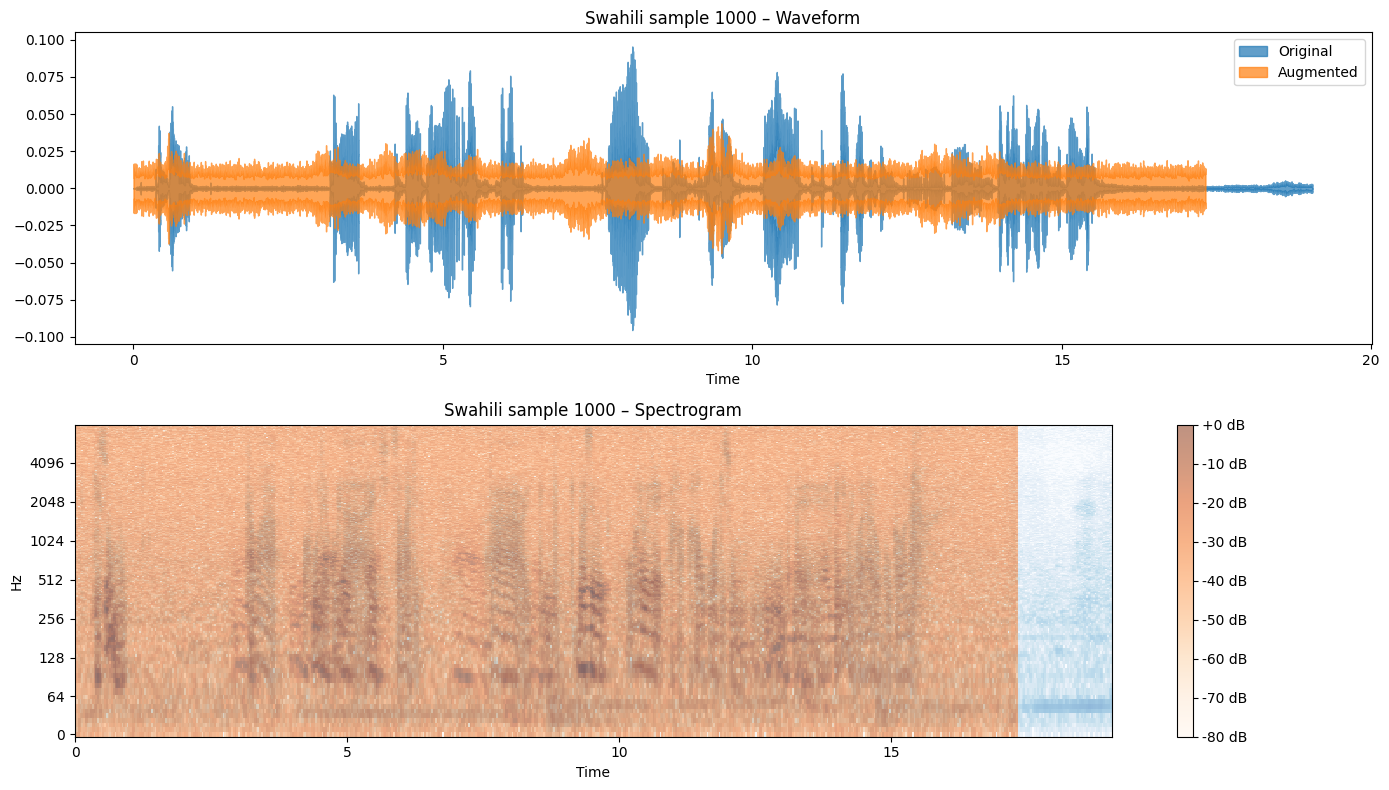

In [9]:
sample_idx = 1000 # try changing this number
sample = dataset[sample_idx]
audio = np.array(sample["audio"]["array"], dtype=np.float32)
sr = sample["audio"]["sampling_rate"]

if sr != 16000:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

aug_audio = AUGMENTER.augment(audio)

show_waveform_and_spectrogram(audio, aug_audio, sr=16000, title_prefix=f"Swahili sample {sample_idx}")


In [10]:
import pandas as pd
import os

# 🐾 Ensure you have an augmentation log list
# (if it doesn’t exist yet, create an empty one so this cell doesn’t crash)
if "augmentation_log" not in locals():
    augmentation_log = []

# ✅ Convert log to a DataFrame
log_df = pd.DataFrame(augmentation_log)

# ✅ Define save path
log_path = os.path.join(OUTPUT_DIR, "augmentation_log.csv")

# ✅ Save the log as CSV
log_df.to_csv(log_path, index=False)

# ✅ Print and preview
print(f"🐱 Augmentation log saved successfully at: {log_path}")
print(f"Total entries: {len(log_df)}")

# Optional — preview first few rows
display(log_df.head())


🐱 Augmentation log saved successfully at: augmented_swahili/augmentation_log.csv
Total entries: 0


""
